In [2]:
!mkdir /content/mypackages
!mkdir /content/mypackages/text_analyzer
!mkdir /content/mypackages/text_analyzer/text_analyzer
!mkdir /content/mypackages/text_analyzer/tests

In [19]:
%%file /content/mypackages/text_analyzer/setup.py
from setuptools import setup, find_packages

# Add install requirements
setup(
    author="<your-name>",
    description="A practiced package",
    name="text_analyzer",
    packages=find_packages(include=["text_analyzer", "text_analyzer.*"]),
    version="0.1.0",
    install_requires=["matplotlib"],
    python_requires=">=3.5",
)

Overwriting /content/mypackages/text_analyzer/setup.py


In [6]:
%%file /content/mypackages/text_analyzer/text_analyzer/__init__.py

__doc__ = """
text_analyzer
========
A package for analyze texts from various sources
"""

__author__ = """Arm Nakornthab"""
__version__ = "0.1.0"

from . import Document, SocialMedia, Tweets  # noqa : F401

Writing /content/mypackages/text_analyzer/text_analyzer/__init__.py


In [37]:
%%file /content/mypackages/text_analyzer/text_analyzer/utils.py

import re
from collections import Counter
import matplotlib.pyplot as plt
from copy import  copy

def filter_lines(text, first_chars):
    """Filter lines by beginning characters (case sensitive)
    
    :param text:  multi-line text to filter
    :param first_chars: required characters for line to start with to be returned
    :return: text with only lines starting with first_chars included
    
    >>> text = 'humpty dumpty\nsat on a wall\nhumpty dumpty\nhad a great fall'
    >>> filter_lines(text, 'h')
    'humpty dumpty\nhumpty dumpty\nhad a great fall'
    
    >>> filter_lines(text, 'humpty')
    'humpty dumpty\nhumpty dumpty'"""
    # สร้าง list โดยการตัด string เมื่อขึ้นบรรทัดใหม่
    new_text = text.split("\n")

    # เลือกเฉพาะประโยคใน list ที่ขึ้นต้นด้วย RT
    newer = [word for word in new_text if word[:2]=="RT"] 

    # ใช้ string method join กลับเข้าไปให้เป็น string เหมือนที่อธิบายใน docstrinhg
    return "\n".join(newer)
    

def tokenize(words):
    # เอา ตัวเลขออกไปโดยใช้ regular expression (ต้อง import re)
    return re.findall(r"[A-Za-z\_@#]+",  words)

# อยากจำลองการทำงานของโจทย์ ต้องเขียนฟังก์ชันพวกนี้เพิ่มเอง
def filter_word_counts(word_counts, first_char):
    """filter_word_counts(word_counts, first_char)
       Filter Document.word_counts by the first character of the word.

       :param word_counts: the word_counts attribute of a Document class instance
       :param first_char: only keep word counts that start with this character

       >>> # How to filter to only words that start with 'A'
       >>> filter_word_counts(document.word_counts, 'A')"""
    # word_counts คือ Counter object ที่มาจากกระบวนการ Tokenize และใช้ Counter กับ Tokenized list ที่เขียนไว้ด้านบน
    # SocialMedia.word_counts เป็น mutable object การเขียนด้านล่างโดยไม่ใช้ copy จะทำให้ word_counts เปลี่ยนไป
    # เมื่อผ่านกระบวนการด้านล่าง word_counts จะกลายเป็น Counter() ว่างๆ แก้ไขโดยการใช้ deep copy
    new_word_counts = copy(word_counts)
    if first_char == "@":
        # ทำไมต้องเขียนแบบนี้ ?
        # เพราะลองใช้วิธีเขียนแบบเติมแล้วไม่ได้ ลองทุกทาง list_comp, dict, defaultdict ทุกกลไกการเติม ทุกตัวได้ Count = 1 หมด
        # เช่น @DataCamp ควรจะนับได้ 299 แต่กล้บนับได้ 1

        # สร้าง list สำหรับคำที่จะเอาออก
        removal = [word for word in new_word_counts if (word[0] != first_char) | (word == first_char)]
        for key in removal:
            # ต้องทำแบบนี้ การ iterate ตัว dict ตรงๆ จะเกิด error เพราะขนาด size ของ dict เปลี่ยนแปลงขณะ iterate    
            new_word_counts.pop(key, None)
        return new_word_counts
    if first_char == "#":
        removal = [word for word in new_word_counts if (word[0] != first_char) | (word == first_char)]
        for key in removal:
            new_word_counts.pop(key, None)
        return new_word_counts


def sum_counters(counters):
    """Aggregate collections.Counter objects by summing counts

    :param counters: list/tuple of counters to sum
    :return: aggregated counters with counts summed

    >>> d1 = text_analyzer.Document('1 2 fizz 4 buzz fizz 7 8')
    >>> d2 = text_analyzer.Document('fizz buzz 11 fizz 13 14')
    >>> sum_counters([d1.word_counts, d2.word_counts])
    Counter({'fizz': 4, 'buzz': 2})
    """
    return sum(counters, Counter())

Overwriting /content/mypackages/text_analyzer/text_analyzer/utils.py


In [8]:
!mkdir /content/mypackages/text_analyzer/text_analyzer/Document
!mkdir /content/mypackages/text_analyzer/text_analyzer/SocialMedia
!mkdir /content/mypackages/text_analyzer/text_analyzer/Tweets

In [9]:
%%file /content/mypackages/text_analyzer/text_analyzer/Document/__init__.py
from .document import *

Writing /content/mypackages/text_analyzer/text_analyzer/Document/__init__.py


In [10]:
%%file /content/mypackages/text_analyzer/text_analyzer/SocialMedia/__init__.py
from .socialmedia import *

Writing /content/mypackages/text_analyzer/text_analyzer/SocialMedia/__init__.py


In [11]:
%%file /content/mypackages/text_analyzer/text_analyzer/Tweets/__init__.py
from .tweets import *

Writing /content/mypackages/text_analyzer/text_analyzer/Tweets/__init__.py


In [14]:
%%file /content/mypackages/text_analyzer/text_analyzer/Document/document.py

import re
from collections import Counter
import matplotlib.pyplot as plt
from copy import  copy
from text_analyzer.utils import *

class Document:
    """Analyze text data
    :param text: text to analyze

    :ivar text: text originally passed to the instance on creation
    :ivar tokens: Parsed list of words from text
    :ivar word_counts: Counter containing counts of hashtags used in text
    """
    def __init__(self, text):
        self.text = text
        # Tokenize the document with non-public tokenize method
        self.tokens = self._tokenize()
        # Perform word count with non-public count_words method
        self.word_counts = self._count_words()

    # Non public method จะมีเครื่องหมาย _ นำหน้า
    def _tokenize(self):
        return tokenize(self.text)
    
    # non-public method to tally document's word counts with Counter
    # Non public method จะมีเครื่องหมาย _ นำหน้า
    def _count_words(self):
        return Counter(self.tokens)

    # นำฟังก์ชันจากข้างนอก มาเขียนเป็น method
    def plot_counts(self, attribute, n_most_common=5):
        """plot_counts(attribute='word_counts', n_most_common=5) method of Document instance
        Plot most common elements of a ``collections.Counter`` instance attribute
        
        :param attribute: name of ``Counter`` attribute to use as object to plot
        :param n_most_common: number of elements to plot (using ``Counter.most_common()``)
        :return: None; a plot is shown using matplotlib
        
        >>> doc = Document("duck duck goose is fun when you're the goose")
        >>> doc.plot_counts('word_counts', n_most_common=5)  # same as default call"""
        # Subset the n_most_common items from the input counter
        if attribute == "hashtag_counts":
            top_items = self.hashtag_counts.most_common(n_most_common)
        if attribute == "mention_counts":
            top_items = self.mention_counts.most_common(n_most_common)
        
        # Plot `top_items`
        # topitems มันเป็น list ต้องแปลงกลับมาเป็น dict ก่อน
        dict_object = {key: value for key, value in top_items} # ใช้ dict_generator
        # ใช้ plt.bar ตัวแรกแกน x ตัวที่สองแกน y
        plt.bar(list(dict_object.keys()), list(dict_object.values()))
        # ทำตัวอักษรบนแกน x ให้ตั้งฉาก 90 องศา ต้องเปลี่ยน Dict_keys เป็น list ก่อน ไม่งั้น error
        plt.xticks(list(dict_object.keys()), rotation=90)
        plt.show()

Overwriting /content/mypackages/text_analyzer/text_analyzer/Document/document.py


In [15]:
%%file /content/mypackages/text_analyzer/text_analyzer/SocialMedia/socialmedia.py

import re
from collections import Counter
import matplotlib.pyplot as plt
from copy import  copy
from text_analyzer.utils import *
from text_analyzer.Document.document import *

class SocialMedia(Document):
    """Analyze text data from social media
    
    :param text: social media text to analyze

    :ivar hashtag_counts: Counter object containing counts of hashtags used in text
    :ivar mention_counts: Counter object containing counts of @mentions used in text
    """
    def __init__(self, text):
        Document.__init__(self, text)
        self.hashtag_counts = self._count_hashtags()
        self.mention_counts = self._count_mentions()

    def _count_hashtags(self):
        # Filter attribute so only words starting with '#' remain
        return filter_word_counts(self.word_counts, first_char='#')      
    
    def _count_mentions(self):
        # Filter attribute so only words starting with '@' remain
        return filter_word_counts(self.word_counts, first_char='@')

Writing /content/mypackages/text_analyzer/text_analyzer/SocialMedia/socialmedia.py


In [16]:
%%file /content/mypackages/text_analyzer/text_analyzer/Tweets/tweets.py

import re
from collections import Counter
import matplotlib.pyplot as plt
from copy import  copy
from text_analyzer.utils import *
from text_analyzer.Document.document import *
from text_analyzer.SocialMedia.socialmedia import *

class Tweets(SocialMedia):
    def __init__(self, text):
        # Call parent's __init__ with super()
        SocialMedia.__init__(self, text)
        # Define retweets attribute with non-public method
        self.retweets = self._process_retweets()

    def _process_retweets(self):
        # Filter tweet text to only include retweets
        retweet_text = filter_lines(self.text, first_chars='RT') # filter_lines เขียนมาแบบนี้ ต้องเอาไปเขียนข้างนอก
        # Return retweet_text as a SocialMedia object
        return SocialMedia(retweet_text)

Writing /content/mypackages/text_analyzer/text_analyzer/Tweets/tweets.py


In [20]:
import os
os.chdir("/content/mypackages/text_analyzer")
!pip install -e .

Obtaining file:///content/mypackages/text_analyzer
  Running setup.py develop for text-analyzer


In [1]:
import text_analyzer

In [3]:
datacamp_tweets = '[DataCamp] Introduction to H2O AutoML --> In this tutorial, you will learn about H2O and have a glimpse of its auto…\n[DataCamp] Stocks, Significance Testing & p-Hacking --> Learn how to manipulate time series data with pandas and co…\nRT @cbismuth: Linear regression example with most significant features detection. #DataCamp #DataScience #Python #sklearn …\nLinear regression example with most significant features detection. #DataCamp #DataScience #Python #sklearn\nBasic linear regression example. #DataCamp #DataScience #Python #sklearn\nRT @David_Makinde_: I just completed Introduction to Python for Data Science \n#Datacamp\n#DataScience \n#Python\n[DataCamp] Enter the #DataFramedChallenge for a chance to be on an upcoming podcast segment. --> DataCamp has a pod…\n[DataCamp] Introduction to Python Metaclasses --> In this tutorial, you\'ll learn about metaclasses in Python. by De…\nI just completed Introduction to Python for Data Science \n#Datacamp\n#DataScience \n#Python\nRT @cbismuth: My pretty first classifier! #DataCamp #Python #sklearn\nMy pretty first classifier! #DataCamp #Python #sklearn\nRT @ascentt: The different #DataScience roles on the job market. \n\n\n\n#SoftwareTesting #DataEngineer #DataScientist #…\nThe different #DataScience roles on the job market. \n\n\n\n#SoftwareTesting #DataEngineer…\nConseguí el contacto de una de las encargadas de la división informática de la OPP (gracias a la gente del…\nWeapons of Math Destruction #datacamp #podcast\n[DataCamp] Shareable Data Science with Kyso --> In this tutorial, you’ll learn how to create publishable and reprod…\nStudying has to be done every day, prepare yourself for the next opportunity. A leader must show how its done.…\n@DataCamp #learningR #programming #datacamp\nTrilha incrível de Programação em Python do projeto DataCamp, concluída com sucesso! 🙌🙌🙌\n#DataCamp #DataScience…\nDepois de um longo dia de trabalho é hora de investir no futuro. #OQueVamosAprenderHoje ?\n\n#datascience #dsa…\nRT @charlyingsparks: This is so spot on. \n@DataCamp @hugobowne #DataFramedchallenge @hmason #empathy\n#datascience #datacamp …\nRT @gastronomy: [DataCamp] Naive Bayes Classification using Scikit-learn --> Learn how to build and evaluate a Naive Bayes Classifier using…\n[DataCamp] Naive Bayes Classification using Scikit-learn --> Learn how to build and evaluate a Naive Bayes Classifi…\nThis is so spot on. \n@DataCamp @hugobowne #DataFramedchallenge @hmason #empathy\n#datascience #datacamp\nIf you want to learn Data Science, start with one of these programming classes by @venturidb…\nLearning about #Shiny in #Datacamp with @minebocek\nRT @aaysbt: Day 32 : I jsut completed the statistical thingking course @DataCamp.  There was lot of thinks to learn my brain is killing me…\n@BernieMat @epi_twit @DataCamp @RStudioJoe @zabormetrics\n@malco_barrett @epi_twit @DataCamp @RStudioJoe @zabormetrics This is perfect. You may have just saved me months of stress in one tweet.\n@BernieMat @epi_twit @DataCamp DataCamp has a course on survival analysis (\n@malco_barrett @epi_twit @DataCamp And thanks for the refs - extremely helpful.\n@malco_barrett @epi_twit @DataCamp Things such as setting up data for survival analysis. I use \'stset\' religiously in Stata.\nI can’t continue the class “Text Mining: Bag of Words”@DataCamp\n@BernieMat @epi_twit In general, I recommend @DataCamp and R for Data Science (\nRT @khalid__amer: Day 5 of #100DaysOfCode :\nI have finished the chapter "Customizing plots" from "Introduction to Data Visualization with P…\nRT @DataCamp: New Tutorial: Introduction to Python Metaclasses! In this tutorial, learn what #metaclasses are, how to implement them in #Py…\nI just completed the course "Joining Data in PostgreSQL"!\n“Business people do not need to apologize for wanting to know what the customer wants...” - @andrewgelman with…\n“Big data tends to be messy data. Instead of a random sample, you often get a convenient sample...” - @andrewgelman…\n@DataCamp do you have a curriculum suggestion to mimic the \'Quantitative Analyst with R\' track, but focused on…\nRT @mustafanafees: \u2066@DataCamp \u2069’s Data Science And #MachineLearning  Programs: A Review\n@drjekyll75 @DataCamp @dataquestio @kaggle ooh cool, I don\'t know them. might give something a try :)\n@iC0dE_ @dataquestio @DataCamp both offer courses that are really good. I’m doing the python pipeline and it’s free…\n@Dame_Of_Spades @DataCamp @dataquestio both offer free courses that are really good. @kaggle is another good one wi…\nThanks @NickCarchedi and @DataCamp for "Intro to SQL for Data Science". Great course!\nRT @DataCamp: Analyzing Police Activity with pandas! In this course, you’ll practice cleaning messy data & create visualizations. This cour…\nDay 32 : I jsut completed the statistical thingking course @DataCamp.  There was lot of thinks to learn my brain is…\nRT @gelliottmorris: Want to learn how to analyze political data? Trying to figure out #rstats and want a familiar dataset? I\'ve got somethi…\nRT @drjekyll75: #100DaysOfCode R1D23: I just completed the course "Intro to Python for Data Science"! …\nI just completed the course "Intro to Python for Data Science"!\n\u2066@DataCamp \u2069’s Data Science And #MachineLearning  Programs: A Review\nI just completed the course "Importing Data in Python (Part 2)"!\n@nnstats @DataCamp Another question .. any special reasons for using RStata? Are there things Stata can do that R can\'t? Tq\n#Python vs R battle for supremacy in #DataScience: \n\n#Infographic by @DataCamp\n\n#BigData…\n@DataCamp It would be awesome if we could bookmark courses we\'re interested in. It\'d be even more awesome if we could create playlists.\nRT @DataCamp: Modeling with Data in the Tidyverse! In this course, you will learn to model with data. Models attempt to capture the relatio…\n@JamesMarsh79 @DataCamp Thanks\n@ShipSystem @DataCamp I did think the interface worked well and directions were clear most of the time\n@JamesMarsh79 @DataCamp any feedback?\nI’m entering #dataframedchallenge and you’ll see me coming. Can’t wait to listen to some great podcasts! @DataCamp @hugobowne\nI just completed the course "Introduction to R"!\nThoroughly enjoyed the Introduction to the Tidyverse course @DataCamp by @drob. Great instructor!…\nRT @jenineharris: I am so excited to officially be a @DataCamp instructor! Thank you to the fantastic @old_man_chester and @venturidb for w…\n@jenineharris @DataCamp @old_man_chester @venturidb WHAT!!! Congrats Dr. HaRRis!!\nThoroughly enjoyed the Career Track Data Scientist with R @DataCamp course, great instructors!, getting the most ou…\nWant to learn how to analyze political data? Trying to figure out #rstats and want a familiar dataset? I\'ve got som…\nI just completed the course "Cleaning Data in R" @DataCamp. Learned a lot of functions from #tidyr, #stringr, and #lubridate packages!\nThoroughly enjoyed the Joining Data in PostgreSQL @DataCamp course by @old_man_chester. Great instructor!\nRT @DataCamp: Did you already get your Pandas basics cheat sheet? -\n#100DaysOfCode R1D23: I just completed the course "Intro to Python for Data Science"!\n@DataCamp Here\'s another introduction to (K-Means clustering) analysis applied to UK Police data…\n@DannyIsSerious @nnstats @DataCamp How good is the Rstata  package?\nRT @simplivllc: Python Programming Certification Course {40%OFF}\n\n#technology #Software #MachineLearning #tech #educ…\nRT @nnstats: ok, responses to the data science questions that have been thrown my way in the last 24 hours:\n\n• Python or R?\ndoesn’t matter.…\nRT @pisastero: I\'ve just discovered ggthemes and the many many hours of @DataCamp have just paid off a million times. This is a game change…\nJust got back from a week in Dublin with @DataCamp for our work week and I only have 100 or so Github notifications, far less than expected!\nRT @sctyner: Back from vacation today, and this lovely gift from my friend @chendaniely was waiting for me! Which reminds me, I need to get…\nBack from vacation today, and this lovely gift from my friend @chendaniely was waiting for me! Which reminds me, I…\nData science for biologists course @ucl is underway! A massive thank you to @DataCamp for giving us access to their wonderful tutorials!\nRT @rstudio: @DukeSSRI has been developing a free 7part @DataCamp series on Causal Inference with R. The first 3 parts are up;\n-Intro https…\n@jenineharris @DataCamp @old_man_chester @venturidb Awesome! Congrats!\nRT @aaysbt: Day 31 : Hypothesis test examples as apart of the statictical thingking course @DataCamp #100DaysOfCode #python #Statistics #Da…\nI am so excited to officially be a @DataCamp instructor! Thank you to the fantastic @old_man_chester and @venturidb…\nPython Programming Certification Course {40%OFF}\n\n#technology #Software #MachineLearning…\nRT @DataCamp: Intermediate Spreadsheets for Data Science! This course will expand your Google Sheets vocabulary. You\'ll dive deep into data…\nRT @DataCamp: Pivot Tables with Spreadsheets! Learn techniques such as sorting, subtotaling, & filtering your data using real world example…\nRT @DataCamp: Could TensorBoard help you? This tutorial will guide you on how to use TensorBoard, which is a fantastic utility that allows…\nDay 31 : Hypothesis test examples as apart of the statictical thingking course @DataCamp #100DaysOfCode #python…\nI just completed the course "Network Science in R - A Tidy Approach"!\n@nnstats @DataCamp Datacamp was nice bc you never had to set up an environment or manages package/version conflicts…\nRT @aaysbt: Day 30: bootstrap confidence intervals as a part of the statistical thinking in #python course @DataCamp #100DaysOfCode #CodeNe…\n@DataCamp It has been more than 4 days, you guys are not resolving the issues. I am waiting, Request #119967. Can a…\nRT @DataCamp: Are you manipulating time series data in R with xts? Get your copy of DataCamp\'s xts cheat sheet here: …\nRT @AndroidCiudadan: #100DaysOfCode R2Day41-42: I\'ve been grinding the @DataCamp Data science courses with python, having fun with the data…\n#100DaysOfCode R2Day41-42: I\'ve been grinding the @DataCamp Data science courses with python, having fun with the d…\nI just completed the course "Joining Data in PostgreSQL"!\nRT @DataCamp: New Tutorial: Naive Bayes Classification using Scikit-learn! Learn how to build and evaluate a #Naive #Bayes #Classifier usin…\n@nnstats @DataCamp Can R run SAP hockey analytics\n@MBMiller_AT @AcademicChatter @DataCamp You\'re welcome!  Hope that helps 😊\n@PNgsabrina @AcademicChatter @DataCamp Great thanks!\n@MBMiller_AT @AcademicChatter Highly recommend  @DataCamp ! They have detail video tutorials and practices to conso…\nGood tool for learners of #Datascience #Data #Python #Pandas #Numpy @DataCamp\n@nnstats @DataCamp Do a Twitter survey for the question: Python or R.\n@nnstats @hugobowne @DataCamp I like this post\nRT @DataCamp: New Tutorial: Shareable Data Science with @kyso_io! Learn how to create publishable and reproducible data science studies on…\n@PREDStotheCUP @nnstats @DataCamp Something pirates say\n@CodeNewbies A2: Just finished up my semester. Looking to keep working on @DataCamp courses during the down time. A…\nI\'ve just discovered ggthemes and the many many hours of @DataCamp have just paid off a million times. This is a game changer. #rstats\nDay 30: bootstrap confidence intervals as a part of the statistical thinking in #python course @DataCamp…\n@Rick_Scavetta I recently finished parts 1 and 2 of your Data Visualization with ggplot2 course on @datacamp. The d…\nRT @DataCamp: Tutorial: Bivariate Distribution Heatmaps in R! Learn how to visually show the relationship between two features, how they in…\n@nnstats @DataCamp where can i find the numbies\n@nnstats @DataCamp So I’m exploring the RStata package, but it doesn’t look like it can generate graphical output. Am I missing something?\nHello #R4DS community I’m getting into R course by @DataCamp... Any tips for some projects to play with?!\nI also vouch for @DataCamp\n@nnstats @DataCamp What is R?\nok, responses to the data science questions that have been thrown my way in the last 24 hours:\n\n• Python or R?\ndoes…\n@DataCamp Hi! do y’all have a phone number for customer service?\nRT @iPablo26: I just completed the Pandas foundation course on @DataCamp \n#DataScience #machinelearning #Python #learningcurve …\nI just completed the Pandas foundation course on @DataCamp \n#DataScience #machinelearning #Python #learningcurve\nI just completed the course "Importing Data in Python (Part 2)"!\nRT @DataCamp: This handy one-page cheat sheet presents the #Python basics that you need to perform data analysis!\n…\nRT @OyewoleIsmail: Yes!!!!!, Journey of over 90 days on @DataCamp,  learning Data Science. Thanks 2 @DataCamp and All the instructors for t…\nRT @BCBreeden: During my winter break I want to stay sharp. Going to tackle data imports and some visualization courses on @DataCamp. #Data…\nDuring my winter break I want to stay sharp. Going to tackle data imports and some visualization courses on…\nI try to split my days when i have time.\n\nOne day read my books\nSecond day continue my work @DataCamp \nThird day fo…\nI just completed the course "pandas Foundations"!\nThough I was asked by @DataCamp to share the tweet above, I am genuinely grateful for the opportunity to integrate…\n@AlenaShiryaev12 @DataCamp You’re welcome! Keep an eye out for a great follow-up course by @mona_khm coming soon!\n1 año más de @DataCamp  esta vez si lo aprovecharé jeje hay tanto que aprender\nWhen you start getting @DataCamp ads on your kpop videos...\n#gradschool #gradstudentlife #whyme\nRT @DataCamp: Watch a new webinar by @robinson_es, a data scientist at DataCamp, who will give a brief introduction to the concept of the #…\nThoroughly enjoyed the Joining Data in PostgreSQL @DataCamp course by @old_man_chester. Great instructor!…\nI just completed the course "Python Data Science Toolbox (Part 1)"!\nRT @muxevola: @DataCamp @hugobowne #DataFramedChallenge @wesmckinn\nPandas\' built-in assumption is that data fits in memory. If you want to…\nRT @DataCamp: New Course: Working with Data in the Tidyverse! You\'ll learn to work with data using tools from the #tidyverse in R. Througho…\nRT @MercyMarkus: I just completed the course "Importing Data in Python (Part 2)"!\nRT @RikaGorn: Taking notes during a podcast is def a first for me! Just listened to the brilliant @AngeBassa on @DataCamp DataFramed podcas…\n@MercyMarkus @DataCamp Congrats! Am coming to block you for you to teach me oh\nI just completed the course "Importing Data in Python (Part 2)"!\nI just completed the course "Importing Data in Python (Part 1)"!\n@DataCamp is generously supporting my class. Find out more about DataCamp for the Classroom:\nThoroughly enjoyed the Joining Data in PostgreSQL @DataCamp course by @old_man_chester. Great instructor!\n@DataCamp My annual subscription automatically renewed without any prior warning (such as an email). I did not want…\n@DataCamp Any sales coming?\nIn addition still work on my own programming language. \n\nWork on my other projects and earn my credentials to be a…\nI just completed the course "Python Data Science Toolbox (Part 1)"!\n@718143 @DataCamp @ProjectJupyter @codingphase Mind blown!\n@RikaGorn @AngeBassa @DataCamp @iRobot This was definitely of my memorable episodes from @DataCamp , actually I sho…\nI just completed the course "Intermediate Python for Data Science"!\nRT @718143: #Day39 \n📖 #Python reference material to break up my @DataCamp & @ProjectJupyter routine -\nAlso, THIS:  (…\n#Day39 \n📖 #Python reference material to break up my @DataCamp & @ProjectJupyter routine -\nAlso, THIS:…\n@RikaGorn @AngeBassa @DataCamp @iRobot ⭐️⭐️⭐️⭐️⭐️\nRT @Kunkakom: @maqartan @aecoppock \n\nChristmas is close.\nOn my wishlist: A @DataCamp intro course to DeclareDesign.\n\nThank you, Santa!\n@Kunkakom @maqartan @DataCamp That\'s a fantastic idea. We\'ll send it up north and see what he says!\n@maqartan @aecoppock \n\nChristmas is close.\nOn my wishlist: A @DataCamp intro course to DeclareDesign.\n\nThank you, Santa!\n@DataCamp @jpls93 Definitely didn’t get a reminder email.\n@DataCamp @shankarSRC I’m in the same situation with no renewal reminder.\n@DataCamp @jpls93 I have the same problem - no refund? Guess I’ll have to dispute it with my CC.\nTaking notes during a podcast is def a first for me! Just listened to the brilliant @AngeBassa on @DataCamp DataFra…\nRT @DataCamp: New Project by @venturidb: Introduction to DataCamp Projects! An introduction to DataCamp projects, we\'ll walk you through th…\nThanks @DataCamp for refunding the unintentional annual subscription!\nRT @capigian: Excited to be using @DataCamp for the Classroom in my Predictive Analytics class. They support education for free via this in…\nBlended learning üzerine güzel bir haber! Leuphana Üniversitesi “Data Science” kürsüsü, premium üyelik için…\nYes!!!!!, Journey of over 90 days on @DataCamp,  learning Data Science. Thanks 2 @DataCamp and All the instructors…\nExcited to be using @DataCamp for the Classroom in my Predictive Analytics class. They support education for free v…\nRT @hahaha_it_is_i: Day 45 #100DaysOfCode\n\nSome @DataCamp, some #pytorchudacityscholar challenge. Nothing significant in either. Just chugg…\nThoroughly enjoyed the Introduction to the Tidyverse course @DataCamp by @drob. Great instructor!…\nAdvice for Applying to #DataScience Jobs\n@techmariah @DataCamp Yes!\n@hahaha_it_is_i @DataCamp Keep it up! Inspired to continue by seeing other women do the challenge! #WomenWhoCode\nDay 45 #100DaysOfCode\n\nSome @DataCamp, some #pytorchudacityscholar challenge. Nothing significant in either. Just c…\nRT @AndroidCiudadan: #100DaysOfCode R2Day40: Today I started a course of data science on @DataCamp, I learned about numpy, matplotlib and I…\n#100DaysOfCode R2Day40: Today I started a course of data science on @DataCamp, I learned about numpy, matplotlib an…\nIf this football game has you down, you can always learn some linear algebra here :)\n\n\n\n@DataCamp\nRT @hugobowne: Nearly everybody: If you want to run machine learning in production you use python.\n\nMe: You\'re wrong.\n\nNearly everybody: WT…\nRT @DaveRubal: Bokeh is the #Python #datavisualization library that enables high-performance visual presentation of large datasets in moder…\nRT @tyleransom: I was on the team that created these free @DataCamp courses on causal inference in R. Check them out if you think they’d be…\nRT @aaysbt: Day 29 : Statistical thinking for #DataScience and learning Parameter estimation by optimization @DataCamp #100DaysOfCode #pyth…\nRT @charlyingsparks: We can\'t forget to have fun in what we do.\n\n@datacamp @hugobowne "First and foremost just keep your excitement for it,…\nWe can\'t forget to have fun in what we do.\n\n@datacamp @hugobowne "First and foremost just keep your excitement for…\n@DataCamp by @drob --> if I\'ve got good mark at my assessment thanks to your lesson, I gonna follow them all ! (by…\nNew Tutorial posted on @DataCamp !\nRT @DataCamp: New Tutorial: Automated Machine Learning with Auto-Keras! Learn about automated machine learning and how it can be done using…\n@dsimposters @BecomingDataSci @DataCamp Thank you very much. I appreciate your input.\n@jpls93 @DataCamp Same here this is not only shows bad business practices but also the true intentions to rip off\n@DataCamp I had so much of respect for you guys as your company but today they are all going to be ruined when I se…\nHi @DataCamp - I missed the cyber monday sale. Any chance I can get it still or are there any other sales coming up? Thanks!\nThoroughly enjoyed the Introduction to the Tidyverse course @DataCamp by @drob. Great instructor!\nWelcome:    :)\n@GalarnykMichael @vivekkhetan_ism @PurpleBooth @willems_karlijn @DataCamp Thanks! I think you’re right, and have ju…\n@markchand @PurpleBooth @willems_karlijn @GalarnykMichael @DataCamp Great work @markchand.      Keep doing it with…\n@PurpleBooth @vivekkhetan_ism @willems_karlijn @GalarnykMichael @DataCamp Thanks! Good questions. I mostly wrote it…\n@DataCamp MVPs of the team: @JimSpeckart and @mattmasten\nI was on the team that created these free @DataCamp courses on causal inference in R. Check them out if you think t…\n@aaysbt @DataCamp Kudos! 🎉\nThoroughly enjoyed the Introduction to the Tidyverse course @DataCamp by @drob. Great instructor! I am left wonderi…\n@MercyMarkus @DataCamp ok I\'ll go check it out. Thank you.\n@itsDonmonc @DataCamp Just the first module, you\'ll need to pay to access the rest of the course content.\nI just completed the course "Intro to Python for Data Science"!\n@MercyMarkus @DataCamp is this under one of their free courses?\nBokeh is the #Python #datavisualization library that enables high-performance visual presentation of large datasets…\n@DataCamp Extremely angry to see that my yearly subscription auto-renewed without warning today! Help article…\nDay 29 : Statistical thinking for #DataScience and learning Parameter estimation by optimization @DataCamp…\nLoved @juliasilge tidy text mining with R on @DataCamp, particularly the Shakespeare text/outfit! #moreplease\n@DataCamp You have a good product. I\'ll subscribe to you again anytime I consider studying Data Science again. But…\n@markchand @vivekkhetan_ism @willems_karlijn @GalarnykMichael @DataCamp Great work! You have a very approachable wr…\nLearned a lot with subquerying exercises!\nThoroughly enjoyed the Joining Data in PostgreSQL @DataCamp course by…\nThoroughly enjoyed the Joining Data in PostgreSQL @DataCamp course by @old_man_chester. Great instructor!\nRT @718143: #Day38\nMore! More! More Methods review in @DataCamp 📝📝😁📃\n\nLess actual programming today and more focus on those basic #Python p…\n#Day38\nMore! More! More Methods review in @DataCamp 📝📝😁📃\n\nLess actual programming today and more focus on those bas…\nRT @DataCamp: Working with Dates and Times in R by @CVWickham! This course teaches you the essentials of parsing, manipulating, and computi…\nRT @nebelgrau77: Incorporating @DataCamp\'s "DataFramed" into my daily soundstream was a great idea! There\'s so much to learn, this time fro…\nRT @charlyingsparks: @DataCamp @hugobowne  "I think we all really need to push for openness of data. I think there\'s an incredible opportun…\n@markchand @vivekkhetan_ism @PurpleBooth @willems_karlijn @DataCamp Its nice! My only advice is to put it a blog ty…\nI\'m trying to learn #Python, so I wrote a thing. What do you think, Internet? \nWith thanks t…\nRT @mkuehn10: I just completed the course "Foundations of Functional Programming with purrr"! …\nI just completed the course "Foundations of Functional Programming with purrr"!\n@DataCamp @hugobowne  "I think we all really need to push for openness of data. I think there\'s an incredible oppor…\n@LukeNdatigh @DataCamp Thank you 🤗\nIncorporating @DataCamp\'s "DataFramed" into my daily soundstream was a great idea! There\'s so much to learn, this t…\n@MercyMarkus @DataCamp Congratulations!\n@DataCamp Hello, I would like to speak to customer service\n@DataCamp Thank you, dropped an email.\n@DataCamp #learningR #programming #datacamp\n@DataCamp @hugobowne @mathbabedotorg I would suggest everyone to first check your support page for number of people…\n@MercyMarkus @DataCamp Sist...🙌🙌\n@DataCamp @hugobowne @mathbabedotorg I did, there is no response. This is an unethical business conduct. Every othe…\nI just completed the course "Importing Data in Python (Part 1)"!\nRT @DataCamp: Scikit-learn cheat sheet: #machinelearning with #Python -\n@DataCamp @hugobowne @mathbabedotorg Please do not subscribe to this fraud courses. Datacamp deducted money from my…\n@DukeSSRI has been developing a free 7part @DataCamp series on Causal Inference with R. The first 3 parts are up;\n-…\n@DataCamp can you please cancel the subscription which got auto processed today.\n#Day37\nMore on-the-go coding with both @DataCamp & @dcodermobile using #Python functions while index calling from a…\n@DataCamp You guys keep me hooked more than Netflix\nRT @dataiku: Being a data science manager isn\'t about giving your team all the answers - it\'s about guiding them there instead. Learn how t…\n@nicholdav @DarknetDiaries @USTpodcast @pgmid @twimlai @DataCamp @TalkPython @thedollop @CucubanoPod Weird flex, but OK\n@KirkDBorne @MusicComposer1 @alcgroup @data_nerd @Shirastweet @dez_blanchfield @digitalcloudgal @TeachTheMachine…\nI just completed the course "Introduction to Data Visualization with Python"!\nRT @KirkDBorne: @NexWebSites @MusicComposer1 @alcgroup @data_nerd @Shirastweet @dez_blanchfield @digitalcloudgal @TeachTheMachine @edXOnlin…\n@NexWebSites @MusicComposer1 @alcgroup @data_nerd @Shirastweet @dez_blanchfield @digitalcloudgal @TeachTheMachine…\nRT @ikayz360: Done, up and running with Python for #DataScience #DevCTraining cheers @DataCamp\nDone, up and running with Python for #DataScience #DevCTraining cheers @DataCamp\nI just completed the course "Intro to Python for Data Science"!\n@MihiretuKebede1 @thomasp85 @DataCamp Yes! I though there was a section in the current courses. This will appear in…\nRT @charlyingsparks: This is so spot on. \n@DataCamp @hugobowne #DataFramedchallenge @hmason #empathy\n#datascience #datacamp …\nThanks @DataCamp for making my Bioinformatics class better next year!  Excited to use your lessons to get biologists to love R.\n@DerekChia @DataCamp Thanks! Be on the lookout for a great follow-up course from @mona_khm coming soon!\nRT @uomodlamansarda: @hugobowne @DataCamp @mathbabedotorg Your podcasts are amazing! I never miss one! :)\nRT @aaysbt: Day 28 : I have been complete the course Statistical Thinking in Python (Part 1) @DataCamp #100DaysOfCode #PYTHONPROGRAMMING #P…\n@hahaha_it_is_i @DataCamp I just finished lesson 2 as well 🙂\n@nerdnomadmom @DollaSignBeezy @DataCamp Look at the Azure certs.\nThis is so spot on. \n@DataCamp @hugobowne #DataFramedchallenge @hmason #empathy\n#datascience #datacamp\nDay 28 : I have been complete the course Statistical Thinking in Python (Part 1) @DataCamp #100DaysOfCode…\n@muxevola @DataCamp @hugobowne @wesmckinn although, even if it should fit in memory... sometimes it doesn\'t\nRT @muxevola: @DataCamp @hugobowne #DataFramedChallenge @wesmckinn\nPandas is occupying the sweet spot of being the ultimate Swiss army knif…\nRT @muxevola: @DataCamp @hugobowne @mathbabedotorg #DataFramedChallenge\nFairness and transparency do not seem a proper incentive to undergo…\nThoroughly enjoyed the Joining Data in PostgreSQL @DataCamp course by @old_man_chester. Great instructor!\n@nerdnomadmom @DollaSignBeezy @DataCamp Crazy random, but Ari and I have the same birthday lmaoo small world.\n@nerdnomadmom @DollaSignBeezy @DataCamp Any hints on how to learn data science ?\n@nerdnomadmom @DollaSignBeezy @DataCamp Which cert is for data science for security ?\n@nerdnomadmom @DataCamp That Data Science one seems interesting . Big $$$\n@iPablo26 @DataCamp Congrats 🎉🎈🍾 keep on going 😀\nHaving auto-renewal of subscription turned on as default is very bad UX. Disappointed, @DataCamp. It would\'ve been…\nJust finished my @DataCamp \'s "Python Programmer Track" while have no related \'background\' whatsoever with the cour…\nRT @jsjoeio: Friends who are looking for a job! 😀\n\nIf you\'re passionate about education, JavaScript and looking to work in NYC, check out t…\n@DataCamp @hugobowne @mathbabedotorg #DataFramedChallenge\nFairness and transparency do not seem a proper incentive…\n@DataCamp @hugobowne #DataFramedChallenge @wesmckinn\nPandas is occupying the sweet spot of being the ultimate Swiss…\n@DataCamp @hugobowne #DataFramedChallenge @wesmckinn\nPandas\' built-in assumption is that data fits in memory. If yo…\n@DataCamp is there a Cyber Monday discount code for this year?\nRT @QuantStratTradR: New post using technology from @OptimizeRisk \'s @DataCamp course …\n#Day36\nTrying out the @DataCamp app on the go 🏃 today to further the #Python benefits gained through repetition 📖…\nRT @charlyingsparks: @hugobowne @DataCamp "...inspiration is cheap, but rigor is expensive." -@quaesita #truth #DataScience #dataframedchal…\n@hugobowne @DataCamp "...inspiration is cheap, but rigor is expensive." -@quaesita #truth #DataScience #dataframedchallenge\nRT @hahaha_it_is_i: Day 42 #100DaysOfCode\n\nAnother chapter @DataCamp.\n\nFinished lesson 2 in the pytorch challenge. Feels good to be moving…\nRT @JamesMarsh79: I’ve been using @DataCamp free courses in R and I must say for a super beginner like me, they have been pretty intuitive.\nI’ve been using @DataCamp free courses in R and I must say for a super beginner like me, they have been pretty intuitive.\nFriends who are looking for a job! 😀\n\nIf you\'re passionate about education, JavaScript and looking to work in NYC,…\nDay 42 #100DaysOfCode\n\nAnother chapter @DataCamp.\n\nFinished lesson 2 in the pytorch challenge. Feels good to be mov…\nNew post using technology from @OptimizeRisk \'s @DataCamp course\nRT @DataCamp: 🎙New #DataFramed Episode: @hugobowne speaks with @pjbull, a data scientist for social good and co-founder of @drivendataorg,…\n@iPablo26 @DataCamp Congratulations\nRT @DataCamp: This #SciPy SciPy cheat sheet covers the basics of linear algebra in #Python that you need to get started - …\n@DarknetDiaries wonder how easy it would be to scrape the iTunes charts and do some anomaly detection? Obvs Apple a…\n@CMastication @woody_gsd @voidspace I agree. I started out with just google - and I was able to learn ways to do th…\n@EconoTodd @DataCamp @hugobowne you’ve got a fan! Let’s all get a beer soon.\n¿Diferencias entre el aprendizaje automático y el aprendizaje profundo?\nUna visión general de la Inteligencia Artif…\nRT @muxevola: Fairness is a statistical concept. It\'s a notion that we need to understand at an aggregate level. @DataCamp @hugobowne @math…\nRT @spenafajuri: Hoy estoy haciendo este curso en @DataCamp: Designing and Analysing Clinical Trials in R\nHoy estoy haciendo este curso en @DataCamp: Designing and Analysing Clinical Trials in R\nFairness is a statistical concept. It\'s a notion that we need to understand at an aggregate level. @DataCamp…\nRT @iPablo26: I completed the Cleaning Data in Python Course on @DataCamp  on the 1st of December 2018. On to Pandas foundation.\n#datascien…\nRT @JSnunki: Muy orgullosa \U0001f929\U0001f929\U0001f929 Thanks @DataCamp 👩\u200d🎓👩\u200d🎓👩\u200d🎓 ahora somos 15 😎😎 2019 tal vez 30.👩\u200d🏫👩\u200d🏫\n@vannyozogu @DataCamp Thank you\n@iPablo26 @DataCamp Well done!💪🏾💪🏾\n@DataCamp very useful\nI completed the Cleaning Data in Python Course on @DataCamp  on the 1st of December 2018. On to Pandas foundation.…\n#AI #ArtificialIntelligence #ML #MachineIntelligence #MachineLearning #neuralnetwork #programmers #developers…\nRT @malco_barrett: @nskajaa For learning R in general, I always recommend @DataCamp and R for Data Science (…\nI must say that I\'m very much enjoying the @DataCamp - Data Framed podcast. A nice mix of commentary, history, and…\nI was selected as a recipient of @DataCamp’s Women and Minorities scholarship, and though I’ve already completed a…\nRT @DataCamp: Demystifying crucial statistics in Python! In this tutorial, learn about the basic statistics required for Data Science and M…\nAmen @DataCamp is absolutely amazing! I’m always excited for the next TEMPORARY CHALLENGE! #codinglife #javascript\nI just completed the course "Importing Data in Python (Part 1)"!\nRT @DataCamp: Join us next Thursday for a new live coding event on Facebook! Introduction to the Tidyverse: Survivors of the Titanic, the T…\nRT @HaSN_CH: #100DaysOfCode \nA #day well spent on @DataCamp \n#DataScience #Database #sql #developers #Python\n@nskajaa For learning R in general, I always recommend @DataCamp and R for Data Science (\n#100DaysOfCode \nA #day well spent on @DataCamp \n#DataScience #Database #sql #developers #Python\nI just completed the course "Reporting with R Markdown"!\nRT @dataelixir: Managing Data Science Teams with @AngeBassa via @DataCamp\n@brandibeals @DataCamp Oh well. Even though it didn\'t work for me, thanks for posting!\nBeing a data science manager isn\'t about giving your team all the answers - it\'s about guiding them there instead.…\nRT @doodssiton: Learned so much sifting through the Visualizing Geospatial Data With Python course @DataCamp by @marylvv. Thank you! https:…\n@Gators80 @kearneymw @DataCamp @dataandme Thank you for the recommendations.\nRT @Mteheran: @calypso_bronte @DataScienceFEM @DataCamp Felicitaciones!!!\n@doodssiton @DataCamp Glad to hear this!\nRT @promptcloud: In case you are taken in by the #DataScience buzz, take a look at the five resources listed in this blog - …\n@calypso_bronte @DataScienceFEM @DataCamp Felicitaciones!!!\n@cringngedup3 @DataCamp Thank you...\n@iamchantelphd @kearneymw I would recommend @DataCamp. I really like their teaching method (short videos followed b…\nI just completed the course "Analyzing Election and Polling Data in R"!\nIn case you are taken in by the #DataScience buzz, take a look at the five resources listed in this blog -…\n@Ugyen2007Norbu @DataCamp Congratulations boss\nRT @DataScienceFEM: Thank you @DataCamp @DataScienceFEM 💜💜💜👩\u200d🎓👩\u200d🎓#DataScientists #DataChallenge365Fem #DataScience #WomenInTech #Python htt…\nI just completed the course "Intermediate Python for Data Science"!\nLearned so much sifting through the Visualizing Geospatial Data With Python course @DataCamp by @marylvv. Thank you!\nLearning R is fun. Thanks for the great app @DataCamp\nRT @suryast_: @DataCamp your iOS app has a weird bug - in my case I am registered in youe database using my LinkedIn credential. Your login…\n@DataCamp your iOS app has a weird bug - in my case I am registered in youe database using my LinkedIn credential.…\nManaging Data Science Teams with @AngeBassa via @DataCamp\nMuy orgullosa \U0001f929\U0001f929\U0001f929 Thanks @DataCamp 👩\u200d🎓👩\u200d🎓👩\u200d🎓 ahora somos 15 😎😎 2019 tal vez 30.👩\u200d🏫👩\u200d🏫\nThank you @DataCamp @DataScienceFEM 💜💜💜👩\u200d🎓👩\u200d🎓#DataScientists #DataChallenge365Fem #DataScience #WomenInTech #Python\nRT @calypso_bronte: Nuestro grado como #DataScientists con @DataScienceFEM @DataCamp\nGreat refresher by @drob\'s @DataCamp course "Introduction to the Tidyverse"!\nNuestro grado como #DataScientists con @DataScienceFEM @DataCamp\nRT @iris9112: Purpose of 2018 ready! 🎉\nI am very happy because of the effort, the dedication, the help of my girls @DataScienceFEM and to @…\nRT @AgroNatureNig: …\n@keatonwilson @Chrismartin76 @JCSkewesDK @Gairan_P @DataCamp Theory vs facts. Datacamp has a million people taking their courses?\nRT @danielagsrm: Can’t believe we did it!!! 👩🏻\u200d💻💪🏼😱\n“Teach a girl to code and she’ll change the world” @DataScienceFEM \nThank you @DataCamp…\nRT @hugobowne: In Ep. 50 of #DataFramed, our Season 1 finale of the @DataCamp pod, I speak with @mathbabedotorg, author of Weapons of Math…\nRT @danielagsrm: @iris9112 @DataScienceFEM @DataCamp CONGRAAAAATS!!!!!! \U0001f942👯\u200d♀️❤️\nRT @GarbaAdams3: @Navas96Sofia @IamIgoche @DataCamp @DataScienceFEM Congrats\nRT @iris9112: @stifflerBassMan @DataScienceFEM @DataCamp Muchas gracias! Tal vez más adelante pueda aplicar. Aun necesito aprender mucho má…\nRT @stifflerBassMan: @iris9112 @DataScienceFEM @DataCamp @iris9112 por si te interesa:\n@stifflerBassMan @DataScienceFEM @DataCamp Muchas gracias! Tal vez más adelante pueda aplicar. Aun necesito aprender mucho más 🤘🤘\nCan’t believe we did it!!! 👩🏻\u200d💻💪🏼😱\n“Teach a girl to code and she’ll change the world” @DataScienceFEM \nThank you…\nRT @DataScienceFEM: Today graduation 👩\u200d🎓👩\u200d🎓 of the first scholarships of our fraternity @datasciencefem #datachallenge365fem 💜 sponsored by…\n@iris9112 @DataScienceFEM @DataCamp CONGRAAAAATS!!!!!! \U0001f942👯\u200d♀️❤️\nWE ARE DONE!\nI just completed the course "Network Analysis in Python (Part 1)"!\n@mrnavrc @DataCamp @Codecademy @hackerrank is a good site with small problems that can make you learn by doing. Wor…\n@iris9112 @DataScienceFEM @DataCamp @iris9112 por si te interesa:\nRT @mrnavrc: I found out that I didn\'t like the format of the Treehouse Python course (sorry guys). There are too many videos and I need a…\nI found out that I didn\'t like the format of the Treehouse Python course (sorry guys). There are too many videos an…\nGoing deeper!!! \nI just completed the course "Deep Learning in Python"!\nRT @DataCamp: New Tutorial: Working With Zip Files In Python! In this tutorial, you are going to learn how to work with #Zip Files in Pytho…\nNew Tutorial: Introduction to Python Metaclasses! In this tutorial, learn what #metaclasses are, how to implement t…\n@abhijitnsharma Hello, our support team has notified us that the issues have been resolved. Thank you for your patience.\nRT @gelliottmorris: Want to learn how to analyze political data? Trying to figure out #rstats and want a familiar dataset? I\'ve got somethi…\nAnalyzing Police Activity with pandas! In this course, you’ll practice cleaning messy data & create visualizations.…\nModeling with Data in the Tidyverse! In this course, you will learn to model with data. Models attempt to capture t…\nDid you already get your Pandas basics cheat sheet? -\nPivot Tables with Spreadsheets! Learn techniques such as sorting, subtotaling, & filtering your data using real wor…\nCould TensorBoard help you? This tutorial will guide you on how to use TensorBoard, which is a fantastic utility th…\nIntermediate Spreadsheets for Data Science! This course will expand your Google Sheets vocabulary. You\'ll dive deep…\nAre you manipulating time series data in R with xts? Get your copy of DataCamp\'s xts cheat sheet here:…\nNew Tutorial: Shareable Data Science with @kyso_io! Learn how to create publishable and reproducible data science s…\nWatch a new webinar by @robinson_es, a data scientist at DataCamp, who will give a brief introduction to the concep…\n@mbenchi10 Hello, please contact support@datacamp.com.\nWorking with Dates and Times in R by @CVWickham! This course teaches you the essentials of parsing, manipulating, a…\n@jpls93 Hi John, please contact support@datacamp.com. They will be able to look into your specific situation.\n@shankarSRC Hi Shankar, please contact support@datacamp.com. They will be able to look into your specific issue.\n@ur_zee @hugobowne @mathbabedotorg Hi Zaid, please contact support@datacamp.com. They will be able to look into your specific issue.\nNew Tutorial: Naive Bayes Classification using Scikit-learn! Learn how to build and evaluate a #Naive #Bayes…\nThis #SciPy SciPy cheat sheet covers the basics of linear algebra in #Python that you need to get started -…\nScikit-learn cheat sheet: #machinelearning with #Python -\nTutorial: Bivariate Distribution Heatmaps in R! Learn how to visually show the relationship between two features, h…\nDemystifying crucial statistics in Python! In this tutorial, learn about the basic statistics required for Data Sci…\n@aayushraman Hi, please contact support@datacamp.com. They will be able to assist you with this issue.\nNew Blog Post by @venturidb- Request for Proposal: Topical Projects for January 2019! Learn how to become a DataCam…\nNew Tutorial: Working With Zip Files In Python! In this tutorial, you are going to learn how to work with #Zip File…\nNew Tutorial- Regularization: Ridge, Lasso and Elastic Net! In this tutorial, you will get acquainted with the bias…\n@_nighthawk69_ Hi, please contact support@datacamp.com.\nRT @data_jen: I’m at #wintechseries all week representing @DataCamp and looking for #datascience and #analytics experts. We’re hiring!  Mes…\nNew Tutorial: Automated Machine Learning with Auto-Keras! Learn about automated machine learning and how it can be…\nRT @hugobowne: In Ep. 50 of #DataFramed, our Season 1 finale of the @DataCamp pod, I speak with @mathbabedotorg, author of Weapons of Math…\n@itsmevidhya_k Hi Vidhya, please contact support@datacamp.com if the issue still exists.\nNew Tutorial: Introduction to Machine Learning in Python! Get introduced to the world of Machine Learning (#ML) wit…\n@m8in_s Hi Martin, please contact support@datacamp.com. They will be able to help.\nNew Tutorial: Comparison of BI and Analytics Platforms! In this tutorial, you will learn about different factors th…\n🎙New #DataFramed Episode: @hugobowne speaks with @mathbabedotorg, author of Weapons of Math Destruction, about the…\n@hizoka_andou Hi, please contact support@datacamp.com.\nThis handy one-page cheat sheet presents the #Python basics that you need to perform data analysis!…\nDiscover why you should use Amazon Web Services Elastic Compute Cloud (EC2) and how you can set up a basic data sci…\nIntroduction to Monte Carlo Methods! In this tutorial, the reader will learn the Monte Carlo methodology and its ap…\nWorking with #Spark #SQL and DataFrames in #Python? Get your #PySpark SQL cheat sheet:\nNew Tutorial: Overview of Atom #IDE! In this tutorial, you\'ll learn the importance of IDEs, how to set-up #Atom, an…\nNew Project by @venturidb: Introduction to DataCamp Projects! An introduction to DataCamp projects, we\'ll walk you…\nThe issue has been resolved, and everything is currently back up and running. Thank you for your patience.\nWe are aware that our courses are currently down. We are working hard to get them back working. We will update you…\nNew Project by @ErinLaBrecq: Where Are the Fishes? In this project, you will explore two georeferenced data files c…\nNew Course: Multivariate Probability Distributions in R! In this course, you\'ll learn about common #multivariate…\nRT @hugobowne: In Ep. 49 of #DataFramed, the @DataCamp podcast, I speak with @wesmckinn, Director of Ursa Labs and creator of the pandas pr…\nNew Tutorial: AdaBoost Classifier in Python! Understand the ensemble approach, working of the #AdaBoost algorithm a…\nNew Tutorial: Differences Between Machine Learning & Deep Learning! In this tutorial, you\'ll get an overview of Art…\nNew DataFramed Episode: @hugobowne speaks with @wesmckinn, Director of Ursa Labs and creator of the #pandas project…\nScalable Data Processing in R! In this course, learn tools for processing, exploring, & analyzing data directly fro…\nIf you want to take a fresh, interactive approach to telling your data story, let users interact with your data and…\nApache Spark in Python: Beginner\'s Guide! A beginner\'s tutorial to Spark in Python based on 9 popular questions, su…\nIn this course, you\'ll get experience developing fun and realistic Shiny apps for different common use cases, such…\nApache Spark Tutorial: ML with PySpark! This Apache Spark tutorial introduces you to big data processing, analysis…\nIntroduction to R for Finance by @LoreDirick! In this finance oriented introduction to R, you will learn essential…\nRT @ACSundermann: #DataVisualization is key for understanding your own data and for communicating findings with others. 📊📈\n\nSo geeked to ta…\nNew Tutorial: Simplifying Sentiment Analysis in Python!\nLearn the basics of #sentiment #analysis and how to build a…\nNew Course by Tamuno Alfred: Designing and Analyzing Clinical Trials in R! You\'ll gain an overview of the important…\n@dirtymodelling @nj_tierney Hi Sarah, thank you for letting us know. We are looking into it now. Also, for future,…\nNew Course by @RallidaeRule: Foundations of Functional Programming with #purrr! Learn to easily extract, summarize,…\nNew Course by @nj_tierney: Dealing With Missing Data in R! Learn how to use #tidyverse tools and the #naniar R pack…\nRT @drivendataorg: Listen as our own @pjbull, a data scientist for social good and co-founder of Driven Data, talks with @hugobowne about t…\nRT @MaryLvV: I\'ll show you how to get insight from your #geospatial #data in this DataCamp course using #Nashville #OpenData . Check it out…\n@xZorex Thank you for bringing this to our attention. We will look into it.\n@mmughal @maartenlambert @BigData_LDN All of our cheat sheets are located on our Community. Here is the link:\n@JonathanEStarr Hi Jonathan, on the bottom right of the course page, the datasets are available for you to download…\nRT @hugobowne: I am having a helluva time editing next week\'s ep. of #DataFramed, the @DataCamp podcast, a conversation w/ @wesmckinn about…\nNew Course by @MaryLvV: Visualizing Geospatial Data in Python! In this course, you\'ll learn to make attractive…\n@EnterEnergy @maartenlambert @BigData_LDN All of our cheat sheets are located on our Community. Here is the link:\nRT @maartenlambert: Come and collect your DataCamp swag at our @BigData_LDN stand today! We also handout free trials for everyone passing b…\nNew Course by @emilyriederer: Financial Analytics in R! This course is an intro to the world of #finance where cash…\nRT @hugobowne: In Episode 48 of #DataFramed, a @DataCamp pod, I speak with @AngeBassa, Director of Data Science at @iRobot, about managing…\n@ashutoshkaushal Hey, the first chapter to every course is free and so is our entire Introduction to R course. Here…\nCluster analysis is used to find groups of observations that share similar characteristics. This course will introd…\nRT @Rbloggers: Angela Bassa discusses managing data science teams and much more.\n🎙New DataFramed Episode: @hugobowne speaks with @AngeBassa, Director of Data Science at @iRobot, about leading data…\nStemming and Lemmatization in Python! This tutorial covers the introduction to Stemming & Lemmatization used in Tex…\nWorking with Dates and Times in R by @CVWickham! This course teaches you the essentials of parsing, manipulating, a…\nGraph Optimization with NetworkX in Python! This #NetworkX tutorial will show you how to do graph optimization in…\nBuilding Web Applications in R with Shiny by @minebocek! This course will take you from R programmer to Shiny devel…\nData Visualization with Highcharter in R! Learn how to use Highcharter to create a visualization that creates a buz…\nUnsupervised Learning in R by @hankroark! This course provides a basic introduction to clustering and dimensionalit…\nTake our Intro to Python for Finance course taught by @teeniedeenie! The financial industry is increasingly adoptin…\nRT @hugobowne: Get ready for next week\'s ep of #DataFramed, a @DataCamp pod, a conversation w/ @AngeBassa, Director of Data Science @iRobot…\n@goonereyang Hi, thank you for bringing this to our attention, could you please contact support@datacamp.com with a…\nRT @rstatsnyc: Emily Robinson from @datacamp walks us through how to set up A/B testing to discover meaningful insights. #rstatsdc @robinso…\nNew Tutorial: Introduction to Monte Carlo Methods! In this tutorial, the reader will learn the Monte Carlo methodol…\nPreprocessing for Machine Learning in Python! This #Python course by @sarah_guido covers the basics of how and when…\nNew Course by @HEX0x6C: Network Science in R - A Tidy Approach! This course will demonstrate network analysis using…\nRT @mona_khm: How we create simulated data sets here at @DataCamp. Thanks to @HillGreenLerman for coordinating this 😅 …\nRT @HillGreenLerman: The folks at @DataCamp are having fun coming up with Data Science themed TV Shows! #datascience #nerds @mona_khm https…\nRT @pjbull: 👋 it\'s always such a delight to talk with @hugobowne, given his insightful questions and thoughtful engagement. Glad one of our…\nNew Course by Frank Sumanski: Pivot Tables with #Spreadsheets! Learn techniques such as sorting, subtotaling, & fil…\nNew Course by @richierocks: Intermediate #Spreadsheets for Data Science! This course will expand your Google Sheets…\nRT @hugobowne: In Episode 47 of #DataFramed, a @DataCamp pod, I speak with @pjbull of @drivendataorg about the importance of human-centered…\nParallel Computing with Dask! This course will introduce you to Dask, a flexible parallel computing library for ana…\nIn honor of #ElectionDay in the US, take our new Analyzing #Election and #Polling Data in R course by…\nRT @drivendataorg: 🤓🙌\n🎙New #DataFramed Episode: @hugobowne speaks with @pjbull, a data scientist for social good and co-founder of…\nHave you taken our new Analyzing Election and Polling Data in R course by @gelliottmorris? In this course, you\'ll a…\n@tbalci Please contact support@datacamp.com.\nTime series are all around us, from server logs to high-frequency financial data. In this course, you will learn ev…\nApache Spark Tutorial: ML with PySpark! This Apache Spark tutorial introduces you to big data processing, analysis…\nMany phenomena in our day-to-day lives, such as the movement of stock prices, are measured in intervals over a peri…\nApache Spark in Python: Beginner\'s Guide! A beginner\'s tutorial to Spark in Python based on 9 popular questions, su…\nIntroduction to R for Finance by @LoreDirick! In this finance oriented introduction to R, you will learn essential…\n@masadowski Hi Mark, please contact support@datacamp.com. They will be able to better assist you.\nNew Tutorial: JSON Data in Python! In this tutorial, you\'ll learn about different ways to use #JSON in #Python.…\nNew Tutorial: Essentials of Linear Regression in Python! Learn what formulates a regression problem and how a…\nRT @gelliottmorris: Hello! 👋 \n\nToday is an exciting day, for we officially launch my #Rstats course teaching data science with analyses of…\nRT @Rbloggers: New Course: Analyzing Election and Polling Data in R\n@gary614thomas @DannyProl @gelliottmorris Analyzing Election and Polling Data in R! Here is the link:\nRT @DannyProl: Just finished @gelliottmorris course on @DataCamp. He is an amazing professor, hope he will do more courses!\nNew Course by @gelliottmorris: Analyzing #Election and #Polling Data! In this course learn how to wrangle, visualiz…\nNew Project (#Python) by @rabaath: A Visual History of Nobel Prize Winners! In this project, you get to explore pat…\nRT @Rbloggers: Arnaub Chatterjee discusses artificial intelligence (AI) and machine learning (ML) in …\nRT @ayanalytics: Want to learn about #healthcare #DataAnalytics with real data? Check out the project I designed for @DataCamp with step by…\nRT @hugobowne: In Episode 46 of #DataFramed, a @DataCamp pod, I speaks with @AK_Chatterjee of @McKAnalytics as he cuts through the hype abo…\nNew Project by @ayanalytics: What Your Heart Rate Is Telling You! In this R project, you will examine the relations…\nNew Course by @CrackedEggman: Machine Learning in the Tidyverse! This course will teach you to leverage the tools i…\nWith this beginner tutorial, you\'ll start to explore PEP-8, Python\'s style guide, so that you can start formatting…\nRT @AshleyLucchese: One of our #analytics experts recently spoke with @hugobowne for #DataFramed, the @DataCamp podcast, about cutting thro…\nRT @koehrsen_will: Thoroughly enjoyed this DataCamp podcast. @AllenDowney talks about how to think about and model uncertainty in real-worl…\nRT @old_man_chester: Curious about what it takes to build premium #rstats, #python, #sql, or #spreadsheets content for @DataCamp? We\'ve rev…\nNew Tutorial: Introduction to MongoDB and Python! In this tutorial, you\'ll learn how to integrate #MongoDB with you…\nRT @DigitalMcKinsey: Check out the latest #DataFramed, the @DataCamp podcast, where we cut through the hype on #AI and machine learning in…\n🎙New DataFramed Episode: @hugobowne speaks with @AK_Chatterjee of @McKAnalytics to discuss cutting through the hype…\nNew Tutorial: Merging Datasets in R! In this tutorial, you\'ll learn to join multiple datasets in R.…\nData Visualization with Highcharter in R! Learn how to use Highcharter to create a visualization that creates a buz…\nUnsupervised Learning in R by @hankroark! This course provides a basic introduction to clustering and dimensionalit…\nGraph Optimization with NetworkX in Python! This NetworkX tutorial will show you how to do graph optimization in Py…\nBuilding Web Applications in R with Shiny by @minebocek! This course will take you from R programmer to Shiny devel…\nRT @hugobowne: Launching a wonderful conversation w/ @AK_Chatterjee of @McKAnalytics tomo on #DataFramed, the @DataCamp podcast, an insider…\nStemming and Lemmatization in Python! This tutorial covers the introduction to Stemming & Lemmatization used in Tex…\nWorking with Dates and Times in R by @CVWickham! This course teaches you the essentials of parsing, manipulating, a…\nRT @kaelen_medeiros: lol-ing in the best way at @robinson_es\'s talk about building out an A/B testing system at @DataCamp #noreastr18 https…\nRT @robinson_es: .@richierocks shows a great trick at #noreastr18 if you have a list column (col) and want to filter for ones that contain…\nIntroduction to Machine Learning! In this course, you\'ll get a broad overview of the discipline\'s most common techn…\n@mc_alila XP points are a way to track your progress.\n@_brohrer_ @tymwol We have updated the source. Thank you for pointing that out.\n@mc_alila Hi, you can click on hints, show the answer, and then run the script. It will give you credit for complet…\n@OleksiyAnokhin Thank you for the feedback, it\'s a good suggestion. We are working on something related to this.\nCongrats to @bigreddot, @pwang, and the @anacondainc team for releasing @BokehPlots 1.0!\nRT @hugobowne: So excited to see @BokehPlots 1.0 out there! Congrats to @bigreddot, @pwang, @anacondainc & the whole team. …\nNew Tutorial: Turning Machine Learning Models into APIs in Python! Learn to how to create a simple #API from a mach…\nNew Tutorial: Introduction to Geospatial Data in #Python! In this tutorial, you will use #geospatial #data to #plot…\nRT @hugobowne: Chatting w/ Brian is always a lot of fun & full of insight. Stoked to have recorded this and put it out there! /…\nRT @kyle_e_walker: I\'m excited to share that my @DataCamp course on working with @uscensusbureau data in #rstats has launched!  Take the co…\nNew Course by @kyle_e_walker: Analyzing US Census Data in R! In this course, you\'ll be able to rapidly visualize &…\nRT @hugobowne: In Ep. 45 of #DataFramed, the @DataCamp pod, I speak w/ @quaesita, Chief Decision Scientist @googlecloud, about decision mak…\nRT @venturidb: PROS/CONS OF CREATING A @DATACAMP PROJECT\n\nPROS: Impact a global audience, build your #datascience brand, supplement your in…\nRT @PFF_Eric: This was a cool thing I started between my time at UWL and starting full time at PFF.  \n\nIf you\'re interested in one of the b…\nRT @ellisonbg: I recently spoke with @hugobowne for #DataFramed, the @DataCamp podcast, about @ProjectJupyter, open source software, intera…\nRT @old_man_chester: Love this course by @PFF_Eric! What other mathematical topics would you like to see taught in this interactive coding…\nNew Course by @PFF_Eric: Linear Algebra for Data Science in R! In this course, you’ll learn how to work with vector…\nRT @noamross: Jazzed to launch my new course on @DataCamp, Nonlinear Modeling in #rstats with GAMs!  Learn to use Generalized Additive Mode…\nNew Course by @noamross: Nonlinear Modeling in R with GAMs! In this course, you\'ll learn how GAMs work & how to con…\nRT @Rbloggers: Cassie Kozyrkov discusses decision making and decision intelligence!\nRT @hugobowne: I\'ve been thinking a lot about what 21st century data literacy can look like & started writing it down for @HarvardBiz. Watc…\nRT @BillBrazell: Your Data Literacy Depends on Understanding the Types of Data & How They\'re Captured, says @hugobowne …\nRT @Rbloggers: New Course: Visualization Best Practices in R\nRT @Rbloggers: New Course: Interactive Data Visualization with rbokeh\nNew Tutorial: Stemming and Lemmatization in #Python! This tutorial covers the introduction to #Stemming &…\nRT @mona_khm: What do you want to learn next at @DataCamp?\nRT @andrea4animals: I agree! @DataCamp is amazing!\n🎙New #DataFramed Episode: @hugobowne speaks with @quaesita, Chief Decision Scientist at @googlecloud, about decisio…\nRT @hugobowne: Ep 44 of #DataFramed, the @DataCamp podcast, w/ @ellisonbg: what has contributed to the rise of interactive computing & @Pro…\nIn this tutorial, data science meets Search Engine Marketing: learn to create Google AdWords campaigns by generatin…\nBuilding Chatbots in Python! Learn how to turn human language into machine instructions with rule-based systems & m…\nDive into the lyrics of Prince\'s music with R: use text mining and Exploratory Data Analysis (EDA) to shed insight…\nThey say that a picture is worth a thousand words. This course teaches you how to leverage the power of the tidyver…\nLearn how to apply matrix factorization on user clicks on hundreds of names in the recommender system…\nLearn to set up a data science environment on Google Cloud: create an instance on Google Compute Engine, install An…\nRT @OmaymaS_: And here\'s my course on @DataCamp. \n\nThanks to everyone who worked with me during the previous months & to the beta testers w…\nNew Tutorial: Introduction To GUI With Tkinter In Python! In this tutorial, you are going to learn how to create…\nNew Tutorial: Probability Distributions in #Python! In this tutorial, you\'ll learn about commonly used #probability…\nRT @hugobowne: Got back to my #python roots this week: gave a talk at #PyDataNYC, released a @DataCamp pod w/ @ellisonbg about @ProjectJupy…\nNew Tutorial: Time Series Analysis using R! Learn Time Series Analysis with R along with using a package in R for f…\nRT @NicholasStrayer: It’s a pretty giant honor to launch my DataCamp course on #dataviz. Help bring your #rstats viz skills to the next lev…\nCheck out this new course by @NicholasStrayer who currently is a #biostatistician & data scientist @VanderbiltU. Hi…\nGet in the Halloween spirit by taking this New Project by @NickSolomon10: Explore 538\'s #Halloween Candy Rankings!…\nRT @hugobowne: You won\'t want to miss next week\'s ep. of #DataFramed, the @DataCamp podcast, a conversation w/ @quaesita, Chief Decision Sc…\nNew Project by @richierocks: Functions for Food Price Forecasts! In this project, you will practice writing…\nTake this new Intro to Python for Finance course taught by @teeniedeenie! Her research at Iowa State University foc…\n@fjsosah Thank you for bringing it to our attention. We will look into it.\nRT @hugobowne: hey! I just gave a talk at #PyDataNYC on what I\'ve discovered about #datascience while hosting #DataFramed, the @DataCamp po…\nRT @seanmylaw: .@hugobowne from .@DataCamp helping us figure out what data scientists really do #PyDataNYC\nTake our new Data Visualization with #rbokeh course taught by Omayma Said. She has worked on developing #algorithms…\nNew Course by @teeniedeenie: Intro to Python for Finance! The financial industry is increasingly adopting Python fo…\nRT @Leuven_MindGate: Our speakers are on a roll... On stage is @_ddmkr Dieter De Mesmaeker from @DataCamp: "How can we teach people data sc…\nRT @ed_berry: Nice episode of @DataCamp\'s podcast with @drewconway from March. They emphasise the famous Venn diagram is of Data Science, n…\nNew Course by @NicholasStrayer: Visualization Best Practices in R! This course will help you take your #data…\nRT @mona_khm: I wrote a post for @DataCamp\'s blog about learning SQL: where to start, what are the differences, and how we can help you on…\n@dunjanik Hi, please contact support@datacamp.com. They will be able to help you with your specific problem.\nNew Course by Omayma Said: Interactive Data Visualization with rbokeh! Data visualization is an integral part of th…\nRT @manideeplanka: @DataCamp, this animation is as beautiful and wonderful as your courses are! 😍\nNew Tutorial: Decorators in Python! In this tutorial, learn how to implement #decorators in #Python.…\nRT @drob: We\'re hiring an Instructor Recruiting Intern at @DataCamp: great for someone enthusiastic about DataCamp who wants to find great…\nRead our new tutorial on Hacking Date Functions in #SQLite!'

from text_analyzer import Document
from text_analyzer import SocialMedia
from text_analyzer import Tweets



In [5]:
my_tweets = text_analyzer.Tweets.Tweets(datacamp_tweets)

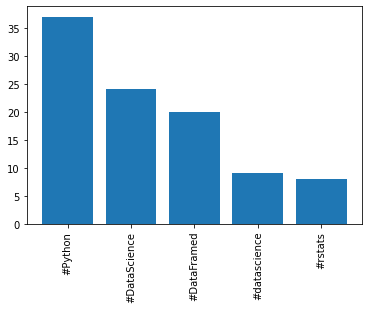

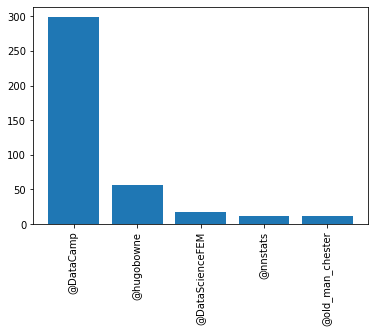

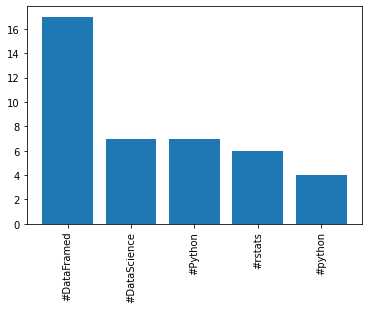

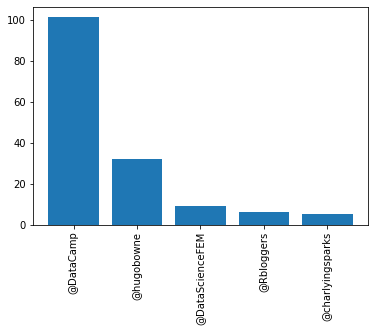

In [8]:
my_tweets = text_analyzer.Tweets.Tweets(datacamp_tweets)
my_tweets.plot_counts('hashtag_counts')
my_tweets.plot_counts('mention_counts')
my_tweets.retweets.plot_counts("hashtag_counts")
my_tweets.retweets.plot_counts("mention_counts")

# จริงๆควรเป็นแบบที่ทำมานะ แต่ลองลดพวก subpackages ดู เผื่อเวลาเรียกใช้มันจะกระชับขึ้น

## ลองทำให้โครงสร้างใกล้เคียงกับที่ใช้ในเว็บ DataCamp ซึ่งไม่ได้เขียนเป็น subpackages

### ใช้โค้ดแบบเราก่อน แล้วค่อยใช้โค้ดแบบเค้า 



In [ ]:
!mkdir /content/mypackages
!mkdir /content/mypackages/text_analyzer
!mkdir /content/mypackages/text_analyzer/text_analyzer
!mkdir /content/mypackages/text_analyzer/tests

In [3]:
%%file /content/mypackages/text_analyzer/setup.py
from setuptools import setup, find_packages

# Add install requirements
setup(
    author="<your-name>",
    description="A practiced package",
    name="text_analyzer",
    packages=find_packages(include=["text_analyzer", "text_analyzer.*"]),
    version="0.1.0",
    install_requires=["matplotlib"],
    python_requires=">=3.5",
)

Writing /content/mypackages/text_analyzer/setup.py


In [2]:
%%file /content/mypackages/text_analyzer/text_analyzer/__init__.py

__doc__ = """
text_analyzer
========
A package for analyze texts from various sources
"""

__author__ = """Arm Nakornthab"""
__version__ = "0.1.0"

from .utils import *
from .document import Document
from .socialmedia import SocialMedia
from .tweets import Tweets

Overwriting /content/mypackages/text_analyzer/text_analyzer/__init__.py


In [5]:
%%file /content/mypackages/text_analyzer/text_analyzer/utils.py

import re
from collections import Counter
import matplotlib.pyplot as plt
from copy import  copy

def tokenize(words):
    return re.findall(r"[A-Za-z\_@#]+",  words)

def filter_word_counts(word_counts, first_char):
    new_word_counts = copy(word_counts)
    if first_char == "@":
        removal = [word for word in new_word_counts if (word[0] != first_char) | (word == first_char)]
        for key in removal:
            new_word_counts.pop(key, None)
        return new_word_counts
    if first_char == "#":
        removal = [word for word in new_word_counts if (word[0] != first_char) | (word == first_char)]
        for key in removal:
            new_word_counts.pop(key, None)
        return new_word_counts

def filter_lines(text, first_chars):
    new_text = text.split("\n")
    newer = [word for word in new_text if word[:2]==first_chars]
    return "\n".join(newer)

def sum_counters(counters):
    return sum(counters, Counter())

Writing /content/mypackages/text_analyzer/text_analyzer/utils.py


In [6]:
%%file /content/mypackages/text_analyzer/text_analyzer/document.py
from collections import Counter
from  text_analyzer.utils import *
import matplotlib.pyplot as plt

class Document:
    def __init__(self, text):
        self.text = text
        self.tokens = self._tokenize()
        self.word_counts = self._count_words()

    def _tokenize(self):
        return tokenize(self.text)
    
    def _count_words(self):
        return Counter(self.tokens)

    def plot_counts(self, attribute=None, n_most_common=5):
        if attribute is None:
            top_items = self.word_counts.most_common(n_most_common)
        if attribute == "hashtag_counts":
            top_items = self.hashtag_counts.most_common(n_most_common)
        if attribute == "mention_counts":
            top_items = self.mention_counts.most_common(n_most_common)
        
        dict_object = {key: value for key, value in top_items} 
        plt.bar(list(dict_object.keys()), list(dict_object.values()))
        plt.xticks(list(dict_object.keys()), rotation=90)
        plt.show()




Writing /content/mypackages/text_analyzer/text_analyzer/document.py


In [7]:
%%file /content/mypackages/text_analyzer/text_analyzer/socialmedia.py

from text_analyzer.utils import *
from text_analyzer.document import *

class SocialMedia(Document):
    def __init__(self, text):
        Document.__init__(self, text)
        self.hashtag_counts = self._count_hashtags()
        self.mention_counts = self._count_mentions()

    def _count_hashtags(self):
        return filter_word_counts(self.word_counts, first_char='#')      
    
    def _count_mentions(self):
        return filter_word_counts(self.word_counts, first_char='@')

Writing /content/mypackages/text_analyzer/text_analyzer/socialmedia.py


In [8]:
%%file /content/mypackages/text_analyzer/text_analyzer/tweets.py

from text_analyzer. utils import *
from text_analyzer.document import *
from text_analyzer.socialmedia import *

class Tweets(SocialMedia):
    def __init__(self, text):
        # SocialMedia.__init__(self, text)
        super().__init__(text)
        self.retweets = self._process_retweets()

    def _process_retweets(self):
        retweet_text = filter_lines(self.text, first_chars='RT')
        return SocialMedia(retweet_text)

Overwriting /content/mypackages/text_analyzer/text_analyzer/tweets.py


In [9]:
import os
os.chdir("/content/mypackages/text_analyzer")
!pip install -e .

Obtaining file:///content/mypackages/text_analyzer
  Running setup.py develop for text-analyzer


In [1]:
import text_analyzer

In [2]:
datacamp_tweets = '[DataCamp] Introduction to H2O AutoML --> In this tutorial, you will learn about H2O and have a glimpse of its auto…\n[DataCamp] Stocks, Significance Testing & p-Hacking --> Learn how to manipulate time series data with pandas and co…\nRT @cbismuth: Linear regression example with most significant features detection. #DataCamp #DataScience #Python #sklearn …\nLinear regression example with most significant features detection. #DataCamp #DataScience #Python #sklearn\nBasic linear regression example. #DataCamp #DataScience #Python #sklearn\nRT @David_Makinde_: I just completed Introduction to Python for Data Science \n#Datacamp\n#DataScience \n#Python\n[DataCamp] Enter the #DataFramedChallenge for a chance to be on an upcoming podcast segment. --> DataCamp has a pod…\n[DataCamp] Introduction to Python Metaclasses --> In this tutorial, you\'ll learn about metaclasses in Python. by De…\nI just completed Introduction to Python for Data Science \n#Datacamp\n#DataScience \n#Python\nRT @cbismuth: My pretty first classifier! #DataCamp #Python #sklearn\nMy pretty first classifier! #DataCamp #Python #sklearn\nRT @ascentt: The different #DataScience roles on the job market. \n\n\n\n#SoftwareTesting #DataEngineer #DataScientist #…\nThe different #DataScience roles on the job market. \n\n\n\n#SoftwareTesting #DataEngineer…\nConseguí el contacto de una de las encargadas de la división informática de la OPP (gracias a la gente del…\nWeapons of Math Destruction #datacamp #podcast\n[DataCamp] Shareable Data Science with Kyso --> In this tutorial, you’ll learn how to create publishable and reprod…\nStudying has to be done every day, prepare yourself for the next opportunity. A leader must show how its done.…\n@DataCamp #learningR #programming #datacamp\nTrilha incrível de Programação em Python do projeto DataCamp, concluída com sucesso! 🙌🙌🙌\n#DataCamp #DataScience…\nDepois de um longo dia de trabalho é hora de investir no futuro. #OQueVamosAprenderHoje ?\n\n#datascience #dsa…\nRT @charlyingsparks: This is so spot on. \n@DataCamp @hugobowne #DataFramedchallenge @hmason #empathy\n#datascience #datacamp …\nRT @gastronomy: [DataCamp] Naive Bayes Classification using Scikit-learn --> Learn how to build and evaluate a Naive Bayes Classifier using…\n[DataCamp] Naive Bayes Classification using Scikit-learn --> Learn how to build and evaluate a Naive Bayes Classifi…\nThis is so spot on. \n@DataCamp @hugobowne #DataFramedchallenge @hmason #empathy\n#datascience #datacamp\nIf you want to learn Data Science, start with one of these programming classes by @venturidb…\nLearning about #Shiny in #Datacamp with @minebocek\nRT @aaysbt: Day 32 : I jsut completed the statistical thingking course @DataCamp.  There was lot of thinks to learn my brain is killing me…\n@BernieMat @epi_twit @DataCamp @RStudioJoe @zabormetrics\n@malco_barrett @epi_twit @DataCamp @RStudioJoe @zabormetrics This is perfect. You may have just saved me months of stress in one tweet.\n@BernieMat @epi_twit @DataCamp DataCamp has a course on survival analysis (\n@malco_barrett @epi_twit @DataCamp And thanks for the refs - extremely helpful.\n@malco_barrett @epi_twit @DataCamp Things such as setting up data for survival analysis. I use \'stset\' religiously in Stata.\nI can’t continue the class “Text Mining: Bag of Words”@DataCamp\n@BernieMat @epi_twit In general, I recommend @DataCamp and R for Data Science (\nRT @khalid__amer: Day 5 of #100DaysOfCode :\nI have finished the chapter "Customizing plots" from "Introduction to Data Visualization with P…\nRT @DataCamp: New Tutorial: Introduction to Python Metaclasses! In this tutorial, learn what #metaclasses are, how to implement them in #Py…\nI just completed the course "Joining Data in PostgreSQL"!\n“Business people do not need to apologize for wanting to know what the customer wants...” - @andrewgelman with…\n“Big data tends to be messy data. Instead of a random sample, you often get a convenient sample...” - @andrewgelman…\n@DataCamp do you have a curriculum suggestion to mimic the \'Quantitative Analyst with R\' track, but focused on…\nRT @mustafanafees: \u2066@DataCamp \u2069’s Data Science And #MachineLearning  Programs: A Review\n@drjekyll75 @DataCamp @dataquestio @kaggle ooh cool, I don\'t know them. might give something a try :)\n@iC0dE_ @dataquestio @DataCamp both offer courses that are really good. I’m doing the python pipeline and it’s free…\n@Dame_Of_Spades @DataCamp @dataquestio both offer free courses that are really good. @kaggle is another good one wi…\nThanks @NickCarchedi and @DataCamp for "Intro to SQL for Data Science". Great course!\nRT @DataCamp: Analyzing Police Activity with pandas! In this course, you’ll practice cleaning messy data & create visualizations. This cour…\nDay 32 : I jsut completed the statistical thingking course @DataCamp.  There was lot of thinks to learn my brain is…\nRT @gelliottmorris: Want to learn how to analyze political data? Trying to figure out #rstats and want a familiar dataset? I\'ve got somethi…\nRT @drjekyll75: #100DaysOfCode R1D23: I just completed the course "Intro to Python for Data Science"! …\nI just completed the course "Intro to Python for Data Science"!\n\u2066@DataCamp \u2069’s Data Science And #MachineLearning  Programs: A Review\nI just completed the course "Importing Data in Python (Part 2)"!\n@nnstats @DataCamp Another question .. any special reasons for using RStata? Are there things Stata can do that R can\'t? Tq\n#Python vs R battle for supremacy in #DataScience: \n\n#Infographic by @DataCamp\n\n#BigData…\n@DataCamp It would be awesome if we could bookmark courses we\'re interested in. It\'d be even more awesome if we could create playlists.\nRT @DataCamp: Modeling with Data in the Tidyverse! In this course, you will learn to model with data. Models attempt to capture the relatio…\n@JamesMarsh79 @DataCamp Thanks\n@ShipSystem @DataCamp I did think the interface worked well and directions were clear most of the time\n@JamesMarsh79 @DataCamp any feedback?\nI’m entering #dataframedchallenge and you’ll see me coming. Can’t wait to listen to some great podcasts! @DataCamp @hugobowne\nI just completed the course "Introduction to R"!\nThoroughly enjoyed the Introduction to the Tidyverse course @DataCamp by @drob. Great instructor!…\nRT @jenineharris: I am so excited to officially be a @DataCamp instructor! Thank you to the fantastic @old_man_chester and @venturidb for w…\n@jenineharris @DataCamp @old_man_chester @venturidb WHAT!!! Congrats Dr. HaRRis!!\nThoroughly enjoyed the Career Track Data Scientist with R @DataCamp course, great instructors!, getting the most ou…\nWant to learn how to analyze political data? Trying to figure out #rstats and want a familiar dataset? I\'ve got som…\nI just completed the course "Cleaning Data in R" @DataCamp. Learned a lot of functions from #tidyr, #stringr, and #lubridate packages!\nThoroughly enjoyed the Joining Data in PostgreSQL @DataCamp course by @old_man_chester. Great instructor!\nRT @DataCamp: Did you already get your Pandas basics cheat sheet? -\n#100DaysOfCode R1D23: I just completed the course "Intro to Python for Data Science"!\n@DataCamp Here\'s another introduction to (K-Means clustering) analysis applied to UK Police data…\n@DannyIsSerious @nnstats @DataCamp How good is the Rstata  package?\nRT @simplivllc: Python Programming Certification Course {40%OFF}\n\n#technology #Software #MachineLearning #tech #educ…\nRT @nnstats: ok, responses to the data science questions that have been thrown my way in the last 24 hours:\n\n• Python or R?\ndoesn’t matter.…\nRT @pisastero: I\'ve just discovered ggthemes and the many many hours of @DataCamp have just paid off a million times. This is a game change…\nJust got back from a week in Dublin with @DataCamp for our work week and I only have 100 or so Github notifications, far less than expected!\nRT @sctyner: Back from vacation today, and this lovely gift from my friend @chendaniely was waiting for me! Which reminds me, I need to get…\nBack from vacation today, and this lovely gift from my friend @chendaniely was waiting for me! Which reminds me, I…\nData science for biologists course @ucl is underway! A massive thank you to @DataCamp for giving us access to their wonderful tutorials!\nRT @rstudio: @DukeSSRI has been developing a free 7part @DataCamp series on Causal Inference with R. The first 3 parts are up;\n-Intro https…\n@jenineharris @DataCamp @old_man_chester @venturidb Awesome! Congrats!\nRT @aaysbt: Day 31 : Hypothesis test examples as apart of the statictical thingking course @DataCamp #100DaysOfCode #python #Statistics #Da…\nI am so excited to officially be a @DataCamp instructor! Thank you to the fantastic @old_man_chester and @venturidb…\nPython Programming Certification Course {40%OFF}\n\n#technology #Software #MachineLearning…\nRT @DataCamp: Intermediate Spreadsheets for Data Science! This course will expand your Google Sheets vocabulary. You\'ll dive deep into data…\nRT @DataCamp: Pivot Tables with Spreadsheets! Learn techniques such as sorting, subtotaling, & filtering your data using real world example…\nRT @DataCamp: Could TensorBoard help you? This tutorial will guide you on how to use TensorBoard, which is a fantastic utility that allows…\nDay 31 : Hypothesis test examples as apart of the statictical thingking course @DataCamp #100DaysOfCode #python…\nI just completed the course "Network Science in R - A Tidy Approach"!\n@nnstats @DataCamp Datacamp was nice bc you never had to set up an environment or manages package/version conflicts…\nRT @aaysbt: Day 30: bootstrap confidence intervals as a part of the statistical thinking in #python course @DataCamp #100DaysOfCode #CodeNe…\n@DataCamp It has been more than 4 days, you guys are not resolving the issues. I am waiting, Request #119967. Can a…\nRT @DataCamp: Are you manipulating time series data in R with xts? Get your copy of DataCamp\'s xts cheat sheet here: …\nRT @AndroidCiudadan: #100DaysOfCode R2Day41-42: I\'ve been grinding the @DataCamp Data science courses with python, having fun with the data…\n#100DaysOfCode R2Day41-42: I\'ve been grinding the @DataCamp Data science courses with python, having fun with the d…\nI just completed the course "Joining Data in PostgreSQL"!\nRT @DataCamp: New Tutorial: Naive Bayes Classification using Scikit-learn! Learn how to build and evaluate a #Naive #Bayes #Classifier usin…\n@nnstats @DataCamp Can R run SAP hockey analytics\n@MBMiller_AT @AcademicChatter @DataCamp You\'re welcome!  Hope that helps 😊\n@PNgsabrina @AcademicChatter @DataCamp Great thanks!\n@MBMiller_AT @AcademicChatter Highly recommend  @DataCamp ! They have detail video tutorials and practices to conso…\nGood tool for learners of #Datascience #Data #Python #Pandas #Numpy @DataCamp\n@nnstats @DataCamp Do a Twitter survey for the question: Python or R.\n@nnstats @hugobowne @DataCamp I like this post\nRT @DataCamp: New Tutorial: Shareable Data Science with @kyso_io! Learn how to create publishable and reproducible data science studies on…\n@PREDStotheCUP @nnstats @DataCamp Something pirates say\n@CodeNewbies A2: Just finished up my semester. Looking to keep working on @DataCamp courses during the down time. A…\nI\'ve just discovered ggthemes and the many many hours of @DataCamp have just paid off a million times. This is a game changer. #rstats\nDay 30: bootstrap confidence intervals as a part of the statistical thinking in #python course @DataCamp…\n@Rick_Scavetta I recently finished parts 1 and 2 of your Data Visualization with ggplot2 course on @datacamp. The d…\nRT @DataCamp: Tutorial: Bivariate Distribution Heatmaps in R! Learn how to visually show the relationship between two features, how they in…\n@nnstats @DataCamp where can i find the numbies\n@nnstats @DataCamp So I’m exploring the RStata package, but it doesn’t look like it can generate graphical output. Am I missing something?\nHello #R4DS community I’m getting into R course by @DataCamp... Any tips for some projects to play with?!\nI also vouch for @DataCamp\n@nnstats @DataCamp What is R?\nok, responses to the data science questions that have been thrown my way in the last 24 hours:\n\n• Python or R?\ndoes…\n@DataCamp Hi! do y’all have a phone number for customer service?\nRT @iPablo26: I just completed the Pandas foundation course on @DataCamp \n#DataScience #machinelearning #Python #learningcurve …\nI just completed the Pandas foundation course on @DataCamp \n#DataScience #machinelearning #Python #learningcurve\nI just completed the course "Importing Data in Python (Part 2)"!\nRT @DataCamp: This handy one-page cheat sheet presents the #Python basics that you need to perform data analysis!\n…\nRT @OyewoleIsmail: Yes!!!!!, Journey of over 90 days on @DataCamp,  learning Data Science. Thanks 2 @DataCamp and All the instructors for t…\nRT @BCBreeden: During my winter break I want to stay sharp. Going to tackle data imports and some visualization courses on @DataCamp. #Data…\nDuring my winter break I want to stay sharp. Going to tackle data imports and some visualization courses on…\nI try to split my days when i have time.\n\nOne day read my books\nSecond day continue my work @DataCamp \nThird day fo…\nI just completed the course "pandas Foundations"!\nThough I was asked by @DataCamp to share the tweet above, I am genuinely grateful for the opportunity to integrate…\n@AlenaShiryaev12 @DataCamp You’re welcome! Keep an eye out for a great follow-up course by @mona_khm coming soon!\n1 año más de @DataCamp  esta vez si lo aprovecharé jeje hay tanto que aprender\nWhen you start getting @DataCamp ads on your kpop videos...\n#gradschool #gradstudentlife #whyme\nRT @DataCamp: Watch a new webinar by @robinson_es, a data scientist at DataCamp, who will give a brief introduction to the concept of the #…\nThoroughly enjoyed the Joining Data in PostgreSQL @DataCamp course by @old_man_chester. Great instructor!…\nI just completed the course "Python Data Science Toolbox (Part 1)"!\nRT @muxevola: @DataCamp @hugobowne #DataFramedChallenge @wesmckinn\nPandas\' built-in assumption is that data fits in memory. If you want to…\nRT @DataCamp: New Course: Working with Data in the Tidyverse! You\'ll learn to work with data using tools from the #tidyverse in R. Througho…\nRT @MercyMarkus: I just completed the course "Importing Data in Python (Part 2)"!\nRT @RikaGorn: Taking notes during a podcast is def a first for me! Just listened to the brilliant @AngeBassa on @DataCamp DataFramed podcas…\n@MercyMarkus @DataCamp Congrats! Am coming to block you for you to teach me oh\nI just completed the course "Importing Data in Python (Part 2)"!\nI just completed the course "Importing Data in Python (Part 1)"!\n@DataCamp is generously supporting my class. Find out more about DataCamp for the Classroom:\nThoroughly enjoyed the Joining Data in PostgreSQL @DataCamp course by @old_man_chester. Great instructor!\n@DataCamp My annual subscription automatically renewed without any prior warning (such as an email). I did not want…\n@DataCamp Any sales coming?\nIn addition still work on my own programming language. \n\nWork on my other projects and earn my credentials to be a…\nI just completed the course "Python Data Science Toolbox (Part 1)"!\n@718143 @DataCamp @ProjectJupyter @codingphase Mind blown!\n@RikaGorn @AngeBassa @DataCamp @iRobot This was definitely of my memorable episodes from @DataCamp , actually I sho…\nI just completed the course "Intermediate Python for Data Science"!\nRT @718143: #Day39 \n📖 #Python reference material to break up my @DataCamp & @ProjectJupyter routine -\nAlso, THIS:  (…\n#Day39 \n📖 #Python reference material to break up my @DataCamp & @ProjectJupyter routine -\nAlso, THIS:…\n@RikaGorn @AngeBassa @DataCamp @iRobot ⭐️⭐️⭐️⭐️⭐️\nRT @Kunkakom: @maqartan @aecoppock \n\nChristmas is close.\nOn my wishlist: A @DataCamp intro course to DeclareDesign.\n\nThank you, Santa!\n@Kunkakom @maqartan @DataCamp That\'s a fantastic idea. We\'ll send it up north and see what he says!\n@maqartan @aecoppock \n\nChristmas is close.\nOn my wishlist: A @DataCamp intro course to DeclareDesign.\n\nThank you, Santa!\n@DataCamp @jpls93 Definitely didn’t get a reminder email.\n@DataCamp @shankarSRC I’m in the same situation with no renewal reminder.\n@DataCamp @jpls93 I have the same problem - no refund? Guess I’ll have to dispute it with my CC.\nTaking notes during a podcast is def a first for me! Just listened to the brilliant @AngeBassa on @DataCamp DataFra…\nRT @DataCamp: New Project by @venturidb: Introduction to DataCamp Projects! An introduction to DataCamp projects, we\'ll walk you through th…\nThanks @DataCamp for refunding the unintentional annual subscription!\nRT @capigian: Excited to be using @DataCamp for the Classroom in my Predictive Analytics class. They support education for free via this in…\nBlended learning üzerine güzel bir haber! Leuphana Üniversitesi “Data Science” kürsüsü, premium üyelik için…\nYes!!!!!, Journey of over 90 days on @DataCamp,  learning Data Science. Thanks 2 @DataCamp and All the instructors…\nExcited to be using @DataCamp for the Classroom in my Predictive Analytics class. They support education for free v…\nRT @hahaha_it_is_i: Day 45 #100DaysOfCode\n\nSome @DataCamp, some #pytorchudacityscholar challenge. Nothing significant in either. Just chugg…\nThoroughly enjoyed the Introduction to the Tidyverse course @DataCamp by @drob. Great instructor!…\nAdvice for Applying to #DataScience Jobs\n@techmariah @DataCamp Yes!\n@hahaha_it_is_i @DataCamp Keep it up! Inspired to continue by seeing other women do the challenge! #WomenWhoCode\nDay 45 #100DaysOfCode\n\nSome @DataCamp, some #pytorchudacityscholar challenge. Nothing significant in either. Just c…\nRT @AndroidCiudadan: #100DaysOfCode R2Day40: Today I started a course of data science on @DataCamp, I learned about numpy, matplotlib and I…\n#100DaysOfCode R2Day40: Today I started a course of data science on @DataCamp, I learned about numpy, matplotlib an…\nIf this football game has you down, you can always learn some linear algebra here :)\n\n\n\n@DataCamp\nRT @hugobowne: Nearly everybody: If you want to run machine learning in production you use python.\n\nMe: You\'re wrong.\n\nNearly everybody: WT…\nRT @DaveRubal: Bokeh is the #Python #datavisualization library that enables high-performance visual presentation of large datasets in moder…\nRT @tyleransom: I was on the team that created these free @DataCamp courses on causal inference in R. Check them out if you think they’d be…\nRT @aaysbt: Day 29 : Statistical thinking for #DataScience and learning Parameter estimation by optimization @DataCamp #100DaysOfCode #pyth…\nRT @charlyingsparks: We can\'t forget to have fun in what we do.\n\n@datacamp @hugobowne "First and foremost just keep your excitement for it,…\nWe can\'t forget to have fun in what we do.\n\n@datacamp @hugobowne "First and foremost just keep your excitement for…\n@DataCamp by @drob --> if I\'ve got good mark at my assessment thanks to your lesson, I gonna follow them all ! (by…\nNew Tutorial posted on @DataCamp !\nRT @DataCamp: New Tutorial: Automated Machine Learning with Auto-Keras! Learn about automated machine learning and how it can be done using…\n@dsimposters @BecomingDataSci @DataCamp Thank you very much. I appreciate your input.\n@jpls93 @DataCamp Same here this is not only shows bad business practices but also the true intentions to rip off\n@DataCamp I had so much of respect for you guys as your company but today they are all going to be ruined when I se…\nHi @DataCamp - I missed the cyber monday sale. Any chance I can get it still or are there any other sales coming up? Thanks!\nThoroughly enjoyed the Introduction to the Tidyverse course @DataCamp by @drob. Great instructor!\nWelcome:    :)\n@GalarnykMichael @vivekkhetan_ism @PurpleBooth @willems_karlijn @DataCamp Thanks! I think you’re right, and have ju…\n@markchand @PurpleBooth @willems_karlijn @GalarnykMichael @DataCamp Great work @markchand.      Keep doing it with…\n@PurpleBooth @vivekkhetan_ism @willems_karlijn @GalarnykMichael @DataCamp Thanks! Good questions. I mostly wrote it…\n@DataCamp MVPs of the team: @JimSpeckart and @mattmasten\nI was on the team that created these free @DataCamp courses on causal inference in R. Check them out if you think t…\n@aaysbt @DataCamp Kudos! 🎉\nThoroughly enjoyed the Introduction to the Tidyverse course @DataCamp by @drob. Great instructor! I am left wonderi…\n@MercyMarkus @DataCamp ok I\'ll go check it out. Thank you.\n@itsDonmonc @DataCamp Just the first module, you\'ll need to pay to access the rest of the course content.\nI just completed the course "Intro to Python for Data Science"!\n@MercyMarkus @DataCamp is this under one of their free courses?\nBokeh is the #Python #datavisualization library that enables high-performance visual presentation of large datasets…\n@DataCamp Extremely angry to see that my yearly subscription auto-renewed without warning today! Help article…\nDay 29 : Statistical thinking for #DataScience and learning Parameter estimation by optimization @DataCamp…\nLoved @juliasilge tidy text mining with R on @DataCamp, particularly the Shakespeare text/outfit! #moreplease\n@DataCamp You have a good product. I\'ll subscribe to you again anytime I consider studying Data Science again. But…\n@markchand @vivekkhetan_ism @willems_karlijn @GalarnykMichael @DataCamp Great work! You have a very approachable wr…\nLearned a lot with subquerying exercises!\nThoroughly enjoyed the Joining Data in PostgreSQL @DataCamp course by…\nThoroughly enjoyed the Joining Data in PostgreSQL @DataCamp course by @old_man_chester. Great instructor!\nRT @718143: #Day38\nMore! More! More Methods review in @DataCamp 📝📝😁📃\n\nLess actual programming today and more focus on those basic #Python p…\n#Day38\nMore! More! More Methods review in @DataCamp 📝📝😁📃\n\nLess actual programming today and more focus on those bas…\nRT @DataCamp: Working with Dates and Times in R by @CVWickham! This course teaches you the essentials of parsing, manipulating, and computi…\nRT @nebelgrau77: Incorporating @DataCamp\'s "DataFramed" into my daily soundstream was a great idea! There\'s so much to learn, this time fro…\nRT @charlyingsparks: @DataCamp @hugobowne  "I think we all really need to push for openness of data. I think there\'s an incredible opportun…\n@markchand @vivekkhetan_ism @PurpleBooth @willems_karlijn @DataCamp Its nice! My only advice is to put it a blog ty…\nI\'m trying to learn #Python, so I wrote a thing. What do you think, Internet? \nWith thanks t…\nRT @mkuehn10: I just completed the course "Foundations of Functional Programming with purrr"! …\nI just completed the course "Foundations of Functional Programming with purrr"!\n@DataCamp @hugobowne  "I think we all really need to push for openness of data. I think there\'s an incredible oppor…\n@LukeNdatigh @DataCamp Thank you 🤗\nIncorporating @DataCamp\'s "DataFramed" into my daily soundstream was a great idea! There\'s so much to learn, this t…\n@MercyMarkus @DataCamp Congratulations!\n@DataCamp Hello, I would like to speak to customer service\n@DataCamp Thank you, dropped an email.\n@DataCamp #learningR #programming #datacamp\n@DataCamp @hugobowne @mathbabedotorg I would suggest everyone to first check your support page for number of people…\n@MercyMarkus @DataCamp Sist...🙌🙌\n@DataCamp @hugobowne @mathbabedotorg I did, there is no response. This is an unethical business conduct. Every othe…\nI just completed the course "Importing Data in Python (Part 1)"!\nRT @DataCamp: Scikit-learn cheat sheet: #machinelearning with #Python -\n@DataCamp @hugobowne @mathbabedotorg Please do not subscribe to this fraud courses. Datacamp deducted money from my…\n@DukeSSRI has been developing a free 7part @DataCamp series on Causal Inference with R. The first 3 parts are up;\n-…\n@DataCamp can you please cancel the subscription which got auto processed today.\n#Day37\nMore on-the-go coding with both @DataCamp & @dcodermobile using #Python functions while index calling from a…\n@DataCamp You guys keep me hooked more than Netflix\nRT @dataiku: Being a data science manager isn\'t about giving your team all the answers - it\'s about guiding them there instead. Learn how t…\n@nicholdav @DarknetDiaries @USTpodcast @pgmid @twimlai @DataCamp @TalkPython @thedollop @CucubanoPod Weird flex, but OK\n@KirkDBorne @MusicComposer1 @alcgroup @data_nerd @Shirastweet @dez_blanchfield @digitalcloudgal @TeachTheMachine…\nI just completed the course "Introduction to Data Visualization with Python"!\nRT @KirkDBorne: @NexWebSites @MusicComposer1 @alcgroup @data_nerd @Shirastweet @dez_blanchfield @digitalcloudgal @TeachTheMachine @edXOnlin…\n@NexWebSites @MusicComposer1 @alcgroup @data_nerd @Shirastweet @dez_blanchfield @digitalcloudgal @TeachTheMachine…\nRT @ikayz360: Done, up and running with Python for #DataScience #DevCTraining cheers @DataCamp\nDone, up and running with Python for #DataScience #DevCTraining cheers @DataCamp\nI just completed the course "Intro to Python for Data Science"!\n@MihiretuKebede1 @thomasp85 @DataCamp Yes! I though there was a section in the current courses. This will appear in…\nRT @charlyingsparks: This is so spot on. \n@DataCamp @hugobowne #DataFramedchallenge @hmason #empathy\n#datascience #datacamp …\nThanks @DataCamp for making my Bioinformatics class better next year!  Excited to use your lessons to get biologists to love R.\n@DerekChia @DataCamp Thanks! Be on the lookout for a great follow-up course from @mona_khm coming soon!\nRT @uomodlamansarda: @hugobowne @DataCamp @mathbabedotorg Your podcasts are amazing! I never miss one! :)\nRT @aaysbt: Day 28 : I have been complete the course Statistical Thinking in Python (Part 1) @DataCamp #100DaysOfCode #PYTHONPROGRAMMING #P…\n@hahaha_it_is_i @DataCamp I just finished lesson 2 as well 🙂\n@nerdnomadmom @DollaSignBeezy @DataCamp Look at the Azure certs.\nThis is so spot on. \n@DataCamp @hugobowne #DataFramedchallenge @hmason #empathy\n#datascience #datacamp\nDay 28 : I have been complete the course Statistical Thinking in Python (Part 1) @DataCamp #100DaysOfCode…\n@muxevola @DataCamp @hugobowne @wesmckinn although, even if it should fit in memory... sometimes it doesn\'t\nRT @muxevola: @DataCamp @hugobowne #DataFramedChallenge @wesmckinn\nPandas is occupying the sweet spot of being the ultimate Swiss army knif…\nRT @muxevola: @DataCamp @hugobowne @mathbabedotorg #DataFramedChallenge\nFairness and transparency do not seem a proper incentive to undergo…\nThoroughly enjoyed the Joining Data in PostgreSQL @DataCamp course by @old_man_chester. Great instructor!\n@nerdnomadmom @DollaSignBeezy @DataCamp Crazy random, but Ari and I have the same birthday lmaoo small world.\n@nerdnomadmom @DollaSignBeezy @DataCamp Any hints on how to learn data science ?\n@nerdnomadmom @DollaSignBeezy @DataCamp Which cert is for data science for security ?\n@nerdnomadmom @DataCamp That Data Science one seems interesting . Big $$$\n@iPablo26 @DataCamp Congrats 🎉🎈🍾 keep on going 😀\nHaving auto-renewal of subscription turned on as default is very bad UX. Disappointed, @DataCamp. It would\'ve been…\nJust finished my @DataCamp \'s "Python Programmer Track" while have no related \'background\' whatsoever with the cour…\nRT @jsjoeio: Friends who are looking for a job! 😀\n\nIf you\'re passionate about education, JavaScript and looking to work in NYC, check out t…\n@DataCamp @hugobowne @mathbabedotorg #DataFramedChallenge\nFairness and transparency do not seem a proper incentive…\n@DataCamp @hugobowne #DataFramedChallenge @wesmckinn\nPandas is occupying the sweet spot of being the ultimate Swiss…\n@DataCamp @hugobowne #DataFramedChallenge @wesmckinn\nPandas\' built-in assumption is that data fits in memory. If yo…\n@DataCamp is there a Cyber Monday discount code for this year?\nRT @QuantStratTradR: New post using technology from @OptimizeRisk \'s @DataCamp course …\n#Day36\nTrying out the @DataCamp app on the go 🏃 today to further the #Python benefits gained through repetition 📖…\nRT @charlyingsparks: @hugobowne @DataCamp "...inspiration is cheap, but rigor is expensive." -@quaesita #truth #DataScience #dataframedchal…\n@hugobowne @DataCamp "...inspiration is cheap, but rigor is expensive." -@quaesita #truth #DataScience #dataframedchallenge\nRT @hahaha_it_is_i: Day 42 #100DaysOfCode\n\nAnother chapter @DataCamp.\n\nFinished lesson 2 in the pytorch challenge. Feels good to be moving…\nRT @JamesMarsh79: I’ve been using @DataCamp free courses in R and I must say for a super beginner like me, they have been pretty intuitive.\nI’ve been using @DataCamp free courses in R and I must say for a super beginner like me, they have been pretty intuitive.\nFriends who are looking for a job! 😀\n\nIf you\'re passionate about education, JavaScript and looking to work in NYC,…\nDay 42 #100DaysOfCode\n\nAnother chapter @DataCamp.\n\nFinished lesson 2 in the pytorch challenge. Feels good to be mov…\nNew post using technology from @OptimizeRisk \'s @DataCamp course\nRT @DataCamp: 🎙New #DataFramed Episode: @hugobowne speaks with @pjbull, a data scientist for social good and co-founder of @drivendataorg,…\n@iPablo26 @DataCamp Congratulations\nRT @DataCamp: This #SciPy SciPy cheat sheet covers the basics of linear algebra in #Python that you need to get started - …\n@DarknetDiaries wonder how easy it would be to scrape the iTunes charts and do some anomaly detection? Obvs Apple a…\n@CMastication @woody_gsd @voidspace I agree. I started out with just google - and I was able to learn ways to do th…\n@EconoTodd @DataCamp @hugobowne you’ve got a fan! Let’s all get a beer soon.\n¿Diferencias entre el aprendizaje automático y el aprendizaje profundo?\nUna visión general de la Inteligencia Artif…\nRT @muxevola: Fairness is a statistical concept. It\'s a notion that we need to understand at an aggregate level. @DataCamp @hugobowne @math…\nRT @spenafajuri: Hoy estoy haciendo este curso en @DataCamp: Designing and Analysing Clinical Trials in R\nHoy estoy haciendo este curso en @DataCamp: Designing and Analysing Clinical Trials in R\nFairness is a statistical concept. It\'s a notion that we need to understand at an aggregate level. @DataCamp…\nRT @iPablo26: I completed the Cleaning Data in Python Course on @DataCamp  on the 1st of December 2018. On to Pandas foundation.\n#datascien…\nRT @JSnunki: Muy orgullosa \U0001f929\U0001f929\U0001f929 Thanks @DataCamp 👩\u200d🎓👩\u200d🎓👩\u200d🎓 ahora somos 15 😎😎 2019 tal vez 30.👩\u200d🏫👩\u200d🏫\n@vannyozogu @DataCamp Thank you\n@iPablo26 @DataCamp Well done!💪🏾💪🏾\n@DataCamp very useful\nI completed the Cleaning Data in Python Course on @DataCamp  on the 1st of December 2018. On to Pandas foundation.…\n#AI #ArtificialIntelligence #ML #MachineIntelligence #MachineLearning #neuralnetwork #programmers #developers…\nRT @malco_barrett: @nskajaa For learning R in general, I always recommend @DataCamp and R for Data Science (…\nI must say that I\'m very much enjoying the @DataCamp - Data Framed podcast. A nice mix of commentary, history, and…\nI was selected as a recipient of @DataCamp’s Women and Minorities scholarship, and though I’ve already completed a…\nRT @DataCamp: Demystifying crucial statistics in Python! In this tutorial, learn about the basic statistics required for Data Science and M…\nAmen @DataCamp is absolutely amazing! I’m always excited for the next TEMPORARY CHALLENGE! #codinglife #javascript\nI just completed the course "Importing Data in Python (Part 1)"!\nRT @DataCamp: Join us next Thursday for a new live coding event on Facebook! Introduction to the Tidyverse: Survivors of the Titanic, the T…\nRT @HaSN_CH: #100DaysOfCode \nA #day well spent on @DataCamp \n#DataScience #Database #sql #developers #Python\n@nskajaa For learning R in general, I always recommend @DataCamp and R for Data Science (\n#100DaysOfCode \nA #day well spent on @DataCamp \n#DataScience #Database #sql #developers #Python\nI just completed the course "Reporting with R Markdown"!\nRT @dataelixir: Managing Data Science Teams with @AngeBassa via @DataCamp\n@brandibeals @DataCamp Oh well. Even though it didn\'t work for me, thanks for posting!\nBeing a data science manager isn\'t about giving your team all the answers - it\'s about guiding them there instead.…\nRT @doodssiton: Learned so much sifting through the Visualizing Geospatial Data With Python course @DataCamp by @marylvv. Thank you! https:…\n@Gators80 @kearneymw @DataCamp @dataandme Thank you for the recommendations.\nRT @Mteheran: @calypso_bronte @DataScienceFEM @DataCamp Felicitaciones!!!\n@doodssiton @DataCamp Glad to hear this!\nRT @promptcloud: In case you are taken in by the #DataScience buzz, take a look at the five resources listed in this blog - …\n@calypso_bronte @DataScienceFEM @DataCamp Felicitaciones!!!\n@cringngedup3 @DataCamp Thank you...\n@iamchantelphd @kearneymw I would recommend @DataCamp. I really like their teaching method (short videos followed b…\nI just completed the course "Analyzing Election and Polling Data in R"!\nIn case you are taken in by the #DataScience buzz, take a look at the five resources listed in this blog -…\n@Ugyen2007Norbu @DataCamp Congratulations boss\nRT @DataScienceFEM: Thank you @DataCamp @DataScienceFEM 💜💜💜👩\u200d🎓👩\u200d🎓#DataScientists #DataChallenge365Fem #DataScience #WomenInTech #Python htt…\nI just completed the course "Intermediate Python for Data Science"!\nLearned so much sifting through the Visualizing Geospatial Data With Python course @DataCamp by @marylvv. Thank you!\nLearning R is fun. Thanks for the great app @DataCamp\nRT @suryast_: @DataCamp your iOS app has a weird bug - in my case I am registered in youe database using my LinkedIn credential. Your login…\n@DataCamp your iOS app has a weird bug - in my case I am registered in youe database using my LinkedIn credential.…\nManaging Data Science Teams with @AngeBassa via @DataCamp\nMuy orgullosa \U0001f929\U0001f929\U0001f929 Thanks @DataCamp 👩\u200d🎓👩\u200d🎓👩\u200d🎓 ahora somos 15 😎😎 2019 tal vez 30.👩\u200d🏫👩\u200d🏫\nThank you @DataCamp @DataScienceFEM 💜💜💜👩\u200d🎓👩\u200d🎓#DataScientists #DataChallenge365Fem #DataScience #WomenInTech #Python\nRT @calypso_bronte: Nuestro grado como #DataScientists con @DataScienceFEM @DataCamp\nGreat refresher by @drob\'s @DataCamp course "Introduction to the Tidyverse"!\nNuestro grado como #DataScientists con @DataScienceFEM @DataCamp\nRT @iris9112: Purpose of 2018 ready! 🎉\nI am very happy because of the effort, the dedication, the help of my girls @DataScienceFEM and to @…\nRT @AgroNatureNig: …\n@keatonwilson @Chrismartin76 @JCSkewesDK @Gairan_P @DataCamp Theory vs facts. Datacamp has a million people taking their courses?\nRT @danielagsrm: Can’t believe we did it!!! 👩🏻\u200d💻💪🏼😱\n“Teach a girl to code and she’ll change the world” @DataScienceFEM \nThank you @DataCamp…\nRT @hugobowne: In Ep. 50 of #DataFramed, our Season 1 finale of the @DataCamp pod, I speak with @mathbabedotorg, author of Weapons of Math…\nRT @danielagsrm: @iris9112 @DataScienceFEM @DataCamp CONGRAAAAATS!!!!!! \U0001f942👯\u200d♀️❤️\nRT @GarbaAdams3: @Navas96Sofia @IamIgoche @DataCamp @DataScienceFEM Congrats\nRT @iris9112: @stifflerBassMan @DataScienceFEM @DataCamp Muchas gracias! Tal vez más adelante pueda aplicar. Aun necesito aprender mucho má…\nRT @stifflerBassMan: @iris9112 @DataScienceFEM @DataCamp @iris9112 por si te interesa:\n@stifflerBassMan @DataScienceFEM @DataCamp Muchas gracias! Tal vez más adelante pueda aplicar. Aun necesito aprender mucho más 🤘🤘\nCan’t believe we did it!!! 👩🏻\u200d💻💪🏼😱\n“Teach a girl to code and she’ll change the world” @DataScienceFEM \nThank you…\nRT @DataScienceFEM: Today graduation 👩\u200d🎓👩\u200d🎓 of the first scholarships of our fraternity @datasciencefem #datachallenge365fem 💜 sponsored by…\n@iris9112 @DataScienceFEM @DataCamp CONGRAAAAATS!!!!!! \U0001f942👯\u200d♀️❤️\nWE ARE DONE!\nI just completed the course "Network Analysis in Python (Part 1)"!\n@mrnavrc @DataCamp @Codecademy @hackerrank is a good site with small problems that can make you learn by doing. Wor…\n@iris9112 @DataScienceFEM @DataCamp @iris9112 por si te interesa:\nRT @mrnavrc: I found out that I didn\'t like the format of the Treehouse Python course (sorry guys). There are too many videos and I need a…\nI found out that I didn\'t like the format of the Treehouse Python course (sorry guys). There are too many videos an…\nGoing deeper!!! \nI just completed the course "Deep Learning in Python"!\nRT @DataCamp: New Tutorial: Working With Zip Files In Python! In this tutorial, you are going to learn how to work with #Zip Files in Pytho…\nNew Tutorial: Introduction to Python Metaclasses! In this tutorial, learn what #metaclasses are, how to implement t…\n@abhijitnsharma Hello, our support team has notified us that the issues have been resolved. Thank you for your patience.\nRT @gelliottmorris: Want to learn how to analyze political data? Trying to figure out #rstats and want a familiar dataset? I\'ve got somethi…\nAnalyzing Police Activity with pandas! In this course, you’ll practice cleaning messy data & create visualizations.…\nModeling with Data in the Tidyverse! In this course, you will learn to model with data. Models attempt to capture t…\nDid you already get your Pandas basics cheat sheet? -\nPivot Tables with Spreadsheets! Learn techniques such as sorting, subtotaling, & filtering your data using real wor…\nCould TensorBoard help you? This tutorial will guide you on how to use TensorBoard, which is a fantastic utility th…\nIntermediate Spreadsheets for Data Science! This course will expand your Google Sheets vocabulary. You\'ll dive deep…\nAre you manipulating time series data in R with xts? Get your copy of DataCamp\'s xts cheat sheet here:…\nNew Tutorial: Shareable Data Science with @kyso_io! Learn how to create publishable and reproducible data science s…\nWatch a new webinar by @robinson_es, a data scientist at DataCamp, who will give a brief introduction to the concep…\n@mbenchi10 Hello, please contact support@datacamp.com.\nWorking with Dates and Times in R by @CVWickham! This course teaches you the essentials of parsing, manipulating, a…\n@jpls93 Hi John, please contact support@datacamp.com. They will be able to look into your specific situation.\n@shankarSRC Hi Shankar, please contact support@datacamp.com. They will be able to look into your specific issue.\n@ur_zee @hugobowne @mathbabedotorg Hi Zaid, please contact support@datacamp.com. They will be able to look into your specific issue.\nNew Tutorial: Naive Bayes Classification using Scikit-learn! Learn how to build and evaluate a #Naive #Bayes…\nThis #SciPy SciPy cheat sheet covers the basics of linear algebra in #Python that you need to get started -…\nScikit-learn cheat sheet: #machinelearning with #Python -\nTutorial: Bivariate Distribution Heatmaps in R! Learn how to visually show the relationship between two features, h…\nDemystifying crucial statistics in Python! In this tutorial, learn about the basic statistics required for Data Sci…\n@aayushraman Hi, please contact support@datacamp.com. They will be able to assist you with this issue.\nNew Blog Post by @venturidb- Request for Proposal: Topical Projects for January 2019! Learn how to become a DataCam…\nNew Tutorial: Working With Zip Files In Python! In this tutorial, you are going to learn how to work with #Zip File…\nNew Tutorial- Regularization: Ridge, Lasso and Elastic Net! In this tutorial, you will get acquainted with the bias…\n@_nighthawk69_ Hi, please contact support@datacamp.com.\nRT @data_jen: I’m at #wintechseries all week representing @DataCamp and looking for #datascience and #analytics experts. We’re hiring!  Mes…\nNew Tutorial: Automated Machine Learning with Auto-Keras! Learn about automated machine learning and how it can be…\nRT @hugobowne: In Ep. 50 of #DataFramed, our Season 1 finale of the @DataCamp pod, I speak with @mathbabedotorg, author of Weapons of Math…\n@itsmevidhya_k Hi Vidhya, please contact support@datacamp.com if the issue still exists.\nNew Tutorial: Introduction to Machine Learning in Python! Get introduced to the world of Machine Learning (#ML) wit…\n@m8in_s Hi Martin, please contact support@datacamp.com. They will be able to help.\nNew Tutorial: Comparison of BI and Analytics Platforms! In this tutorial, you will learn about different factors th…\n🎙New #DataFramed Episode: @hugobowne speaks with @mathbabedotorg, author of Weapons of Math Destruction, about the…\n@hizoka_andou Hi, please contact support@datacamp.com.\nThis handy one-page cheat sheet presents the #Python basics that you need to perform data analysis!…\nDiscover why you should use Amazon Web Services Elastic Compute Cloud (EC2) and how you can set up a basic data sci…\nIntroduction to Monte Carlo Methods! In this tutorial, the reader will learn the Monte Carlo methodology and its ap…\nWorking with #Spark #SQL and DataFrames in #Python? Get your #PySpark SQL cheat sheet:\nNew Tutorial: Overview of Atom #IDE! In this tutorial, you\'ll learn the importance of IDEs, how to set-up #Atom, an…\nNew Project by @venturidb: Introduction to DataCamp Projects! An introduction to DataCamp projects, we\'ll walk you…\nThe issue has been resolved, and everything is currently back up and running. Thank you for your patience.\nWe are aware that our courses are currently down. We are working hard to get them back working. We will update you…\nNew Project by @ErinLaBrecq: Where Are the Fishes? In this project, you will explore two georeferenced data files c…\nNew Course: Multivariate Probability Distributions in R! In this course, you\'ll learn about common #multivariate…\nRT @hugobowne: In Ep. 49 of #DataFramed, the @DataCamp podcast, I speak with @wesmckinn, Director of Ursa Labs and creator of the pandas pr…\nNew Tutorial: AdaBoost Classifier in Python! Understand the ensemble approach, working of the #AdaBoost algorithm a…\nNew Tutorial: Differences Between Machine Learning & Deep Learning! In this tutorial, you\'ll get an overview of Art…\nNew DataFramed Episode: @hugobowne speaks with @wesmckinn, Director of Ursa Labs and creator of the #pandas project…\nScalable Data Processing in R! In this course, learn tools for processing, exploring, & analyzing data directly fro…\nIf you want to take a fresh, interactive approach to telling your data story, let users interact with your data and…\nApache Spark in Python: Beginner\'s Guide! A beginner\'s tutorial to Spark in Python based on 9 popular questions, su…\nIn this course, you\'ll get experience developing fun and realistic Shiny apps for different common use cases, such…\nApache Spark Tutorial: ML with PySpark! This Apache Spark tutorial introduces you to big data processing, analysis…\nIntroduction to R for Finance by @LoreDirick! In this finance oriented introduction to R, you will learn essential…\nRT @ACSundermann: #DataVisualization is key for understanding your own data and for communicating findings with others. 📊📈\n\nSo geeked to ta…\nNew Tutorial: Simplifying Sentiment Analysis in Python!\nLearn the basics of #sentiment #analysis and how to build a…\nNew Course by Tamuno Alfred: Designing and Analyzing Clinical Trials in R! You\'ll gain an overview of the important…\n@dirtymodelling @nj_tierney Hi Sarah, thank you for letting us know. We are looking into it now. Also, for future,…\nNew Course by @RallidaeRule: Foundations of Functional Programming with #purrr! Learn to easily extract, summarize,…\nNew Course by @nj_tierney: Dealing With Missing Data in R! Learn how to use #tidyverse tools and the #naniar R pack…\nRT @drivendataorg: Listen as our own @pjbull, a data scientist for social good and co-founder of Driven Data, talks with @hugobowne about t…\nRT @MaryLvV: I\'ll show you how to get insight from your #geospatial #data in this DataCamp course using #Nashville #OpenData . Check it out…\n@xZorex Thank you for bringing this to our attention. We will look into it.\n@mmughal @maartenlambert @BigData_LDN All of our cheat sheets are located on our Community. Here is the link:\n@JonathanEStarr Hi Jonathan, on the bottom right of the course page, the datasets are available for you to download…\nRT @hugobowne: I am having a helluva time editing next week\'s ep. of #DataFramed, the @DataCamp podcast, a conversation w/ @wesmckinn about…\nNew Course by @MaryLvV: Visualizing Geospatial Data in Python! In this course, you\'ll learn to make attractive…\n@EnterEnergy @maartenlambert @BigData_LDN All of our cheat sheets are located on our Community. Here is the link:\nRT @maartenlambert: Come and collect your DataCamp swag at our @BigData_LDN stand today! We also handout free trials for everyone passing b…\nNew Course by @emilyriederer: Financial Analytics in R! This course is an intro to the world of #finance where cash…\nRT @hugobowne: In Episode 48 of #DataFramed, a @DataCamp pod, I speak with @AngeBassa, Director of Data Science at @iRobot, about managing…\n@ashutoshkaushal Hey, the first chapter to every course is free and so is our entire Introduction to R course. Here…\nCluster analysis is used to find groups of observations that share similar characteristics. This course will introd…\nRT @Rbloggers: Angela Bassa discusses managing data science teams and much more.\n🎙New DataFramed Episode: @hugobowne speaks with @AngeBassa, Director of Data Science at @iRobot, about leading data…\nStemming and Lemmatization in Python! This tutorial covers the introduction to Stemming & Lemmatization used in Tex…\nWorking with Dates and Times in R by @CVWickham! This course teaches you the essentials of parsing, manipulating, a…\nGraph Optimization with NetworkX in Python! This #NetworkX tutorial will show you how to do graph optimization in…\nBuilding Web Applications in R with Shiny by @minebocek! This course will take you from R programmer to Shiny devel…\nData Visualization with Highcharter in R! Learn how to use Highcharter to create a visualization that creates a buz…\nUnsupervised Learning in R by @hankroark! This course provides a basic introduction to clustering and dimensionalit…\nTake our Intro to Python for Finance course taught by @teeniedeenie! The financial industry is increasingly adoptin…\nRT @hugobowne: Get ready for next week\'s ep of #DataFramed, a @DataCamp pod, a conversation w/ @AngeBassa, Director of Data Science @iRobot…\n@goonereyang Hi, thank you for bringing this to our attention, could you please contact support@datacamp.com with a…\nRT @rstatsnyc: Emily Robinson from @datacamp walks us through how to set up A/B testing to discover meaningful insights. #rstatsdc @robinso…\nNew Tutorial: Introduction to Monte Carlo Methods! In this tutorial, the reader will learn the Monte Carlo methodol…\nPreprocessing for Machine Learning in Python! This #Python course by @sarah_guido covers the basics of how and when…\nNew Course by @HEX0x6C: Network Science in R - A Tidy Approach! This course will demonstrate network analysis using…\nRT @mona_khm: How we create simulated data sets here at @DataCamp. Thanks to @HillGreenLerman for coordinating this 😅 …\nRT @HillGreenLerman: The folks at @DataCamp are having fun coming up with Data Science themed TV Shows! #datascience #nerds @mona_khm https…\nRT @pjbull: 👋 it\'s always such a delight to talk with @hugobowne, given his insightful questions and thoughtful engagement. Glad one of our…\nNew Course by Frank Sumanski: Pivot Tables with #Spreadsheets! Learn techniques such as sorting, subtotaling, & fil…\nNew Course by @richierocks: Intermediate #Spreadsheets for Data Science! This course will expand your Google Sheets…\nRT @hugobowne: In Episode 47 of #DataFramed, a @DataCamp pod, I speak with @pjbull of @drivendataorg about the importance of human-centered…\nParallel Computing with Dask! This course will introduce you to Dask, a flexible parallel computing library for ana…\nIn honor of #ElectionDay in the US, take our new Analyzing #Election and #Polling Data in R course by…\nRT @drivendataorg: 🤓🙌\n🎙New #DataFramed Episode: @hugobowne speaks with @pjbull, a data scientist for social good and co-founder of…\nHave you taken our new Analyzing Election and Polling Data in R course by @gelliottmorris? In this course, you\'ll a…\n@tbalci Please contact support@datacamp.com.\nTime series are all around us, from server logs to high-frequency financial data. In this course, you will learn ev…\nApache Spark Tutorial: ML with PySpark! This Apache Spark tutorial introduces you to big data processing, analysis…\nMany phenomena in our day-to-day lives, such as the movement of stock prices, are measured in intervals over a peri…\nApache Spark in Python: Beginner\'s Guide! A beginner\'s tutorial to Spark in Python based on 9 popular questions, su…\nIntroduction to R for Finance by @LoreDirick! In this finance oriented introduction to R, you will learn essential…\n@masadowski Hi Mark, please contact support@datacamp.com. They will be able to better assist you.\nNew Tutorial: JSON Data in Python! In this tutorial, you\'ll learn about different ways to use #JSON in #Python.…\nNew Tutorial: Essentials of Linear Regression in Python! Learn what formulates a regression problem and how a…\nRT @gelliottmorris: Hello! 👋 \n\nToday is an exciting day, for we officially launch my #Rstats course teaching data science with analyses of…\nRT @Rbloggers: New Course: Analyzing Election and Polling Data in R\n@gary614thomas @DannyProl @gelliottmorris Analyzing Election and Polling Data in R! Here is the link:\nRT @DannyProl: Just finished @gelliottmorris course on @DataCamp. He is an amazing professor, hope he will do more courses!\nNew Course by @gelliottmorris: Analyzing #Election and #Polling Data! In this course learn how to wrangle, visualiz…\nNew Project (#Python) by @rabaath: A Visual History of Nobel Prize Winners! In this project, you get to explore pat…\nRT @Rbloggers: Arnaub Chatterjee discusses artificial intelligence (AI) and machine learning (ML) in …\nRT @ayanalytics: Want to learn about #healthcare #DataAnalytics with real data? Check out the project I designed for @DataCamp with step by…\nRT @hugobowne: In Episode 46 of #DataFramed, a @DataCamp pod, I speaks with @AK_Chatterjee of @McKAnalytics as he cuts through the hype abo…\nNew Project by @ayanalytics: What Your Heart Rate Is Telling You! In this R project, you will examine the relations…\nNew Course by @CrackedEggman: Machine Learning in the Tidyverse! This course will teach you to leverage the tools i…\nWith this beginner tutorial, you\'ll start to explore PEP-8, Python\'s style guide, so that you can start formatting…\nRT @AshleyLucchese: One of our #analytics experts recently spoke with @hugobowne for #DataFramed, the @DataCamp podcast, about cutting thro…\nRT @koehrsen_will: Thoroughly enjoyed this DataCamp podcast. @AllenDowney talks about how to think about and model uncertainty in real-worl…\nRT @old_man_chester: Curious about what it takes to build premium #rstats, #python, #sql, or #spreadsheets content for @DataCamp? We\'ve rev…\nNew Tutorial: Introduction to MongoDB and Python! In this tutorial, you\'ll learn how to integrate #MongoDB with you…\nRT @DigitalMcKinsey: Check out the latest #DataFramed, the @DataCamp podcast, where we cut through the hype on #AI and machine learning in…\n🎙New DataFramed Episode: @hugobowne speaks with @AK_Chatterjee of @McKAnalytics to discuss cutting through the hype…\nNew Tutorial: Merging Datasets in R! In this tutorial, you\'ll learn to join multiple datasets in R.…\nData Visualization with Highcharter in R! Learn how to use Highcharter to create a visualization that creates a buz…\nUnsupervised Learning in R by @hankroark! This course provides a basic introduction to clustering and dimensionalit…\nGraph Optimization with NetworkX in Python! This NetworkX tutorial will show you how to do graph optimization in Py…\nBuilding Web Applications in R with Shiny by @minebocek! This course will take you from R programmer to Shiny devel…\nRT @hugobowne: Launching a wonderful conversation w/ @AK_Chatterjee of @McKAnalytics tomo on #DataFramed, the @DataCamp podcast, an insider…\nStemming and Lemmatization in Python! This tutorial covers the introduction to Stemming & Lemmatization used in Tex…\nWorking with Dates and Times in R by @CVWickham! This course teaches you the essentials of parsing, manipulating, a…\nRT @kaelen_medeiros: lol-ing in the best way at @robinson_es\'s talk about building out an A/B testing system at @DataCamp #noreastr18 https…\nRT @robinson_es: .@richierocks shows a great trick at #noreastr18 if you have a list column (col) and want to filter for ones that contain…\nIntroduction to Machine Learning! In this course, you\'ll get a broad overview of the discipline\'s most common techn…\n@mc_alila XP points are a way to track your progress.\n@_brohrer_ @tymwol We have updated the source. Thank you for pointing that out.\n@mc_alila Hi, you can click on hints, show the answer, and then run the script. It will give you credit for complet…\n@OleksiyAnokhin Thank you for the feedback, it\'s a good suggestion. We are working on something related to this.\nCongrats to @bigreddot, @pwang, and the @anacondainc team for releasing @BokehPlots 1.0!\nRT @hugobowne: So excited to see @BokehPlots 1.0 out there! Congrats to @bigreddot, @pwang, @anacondainc & the whole team. …\nNew Tutorial: Turning Machine Learning Models into APIs in Python! Learn to how to create a simple #API from a mach…\nNew Tutorial: Introduction to Geospatial Data in #Python! In this tutorial, you will use #geospatial #data to #plot…\nRT @hugobowne: Chatting w/ Brian is always a lot of fun & full of insight. Stoked to have recorded this and put it out there! /…\nRT @kyle_e_walker: I\'m excited to share that my @DataCamp course on working with @uscensusbureau data in #rstats has launched!  Take the co…\nNew Course by @kyle_e_walker: Analyzing US Census Data in R! In this course, you\'ll be able to rapidly visualize &…\nRT @hugobowne: In Ep. 45 of #DataFramed, the @DataCamp pod, I speak w/ @quaesita, Chief Decision Scientist @googlecloud, about decision mak…\nRT @venturidb: PROS/CONS OF CREATING A @DATACAMP PROJECT\n\nPROS: Impact a global audience, build your #datascience brand, supplement your in…\nRT @PFF_Eric: This was a cool thing I started between my time at UWL and starting full time at PFF.  \n\nIf you\'re interested in one of the b…\nRT @ellisonbg: I recently spoke with @hugobowne for #DataFramed, the @DataCamp podcast, about @ProjectJupyter, open source software, intera…\nRT @old_man_chester: Love this course by @PFF_Eric! What other mathematical topics would you like to see taught in this interactive coding…\nNew Course by @PFF_Eric: Linear Algebra for Data Science in R! In this course, you’ll learn how to work with vector…\nRT @noamross: Jazzed to launch my new course on @DataCamp, Nonlinear Modeling in #rstats with GAMs!  Learn to use Generalized Additive Mode…\nNew Course by @noamross: Nonlinear Modeling in R with GAMs! In this course, you\'ll learn how GAMs work & how to con…\nRT @Rbloggers: Cassie Kozyrkov discusses decision making and decision intelligence!\nRT @hugobowne: I\'ve been thinking a lot about what 21st century data literacy can look like & started writing it down for @HarvardBiz. Watc…\nRT @BillBrazell: Your Data Literacy Depends on Understanding the Types of Data & How They\'re Captured, says @hugobowne …\nRT @Rbloggers: New Course: Visualization Best Practices in R\nRT @Rbloggers: New Course: Interactive Data Visualization with rbokeh\nNew Tutorial: Stemming and Lemmatization in #Python! This tutorial covers the introduction to #Stemming &…\nRT @mona_khm: What do you want to learn next at @DataCamp?\nRT @andrea4animals: I agree! @DataCamp is amazing!\n🎙New #DataFramed Episode: @hugobowne speaks with @quaesita, Chief Decision Scientist at @googlecloud, about decisio…\nRT @hugobowne: Ep 44 of #DataFramed, the @DataCamp podcast, w/ @ellisonbg: what has contributed to the rise of interactive computing & @Pro…\nIn this tutorial, data science meets Search Engine Marketing: learn to create Google AdWords campaigns by generatin…\nBuilding Chatbots in Python! Learn how to turn human language into machine instructions with rule-based systems & m…\nDive into the lyrics of Prince\'s music with R: use text mining and Exploratory Data Analysis (EDA) to shed insight…\nThey say that a picture is worth a thousand words. This course teaches you how to leverage the power of the tidyver…\nLearn how to apply matrix factorization on user clicks on hundreds of names in the recommender system…\nLearn to set up a data science environment on Google Cloud: create an instance on Google Compute Engine, install An…\nRT @OmaymaS_: And here\'s my course on @DataCamp. \n\nThanks to everyone who worked with me during the previous months & to the beta testers w…\nNew Tutorial: Introduction To GUI With Tkinter In Python! In this tutorial, you are going to learn how to create…\nNew Tutorial: Probability Distributions in #Python! In this tutorial, you\'ll learn about commonly used #probability…\nRT @hugobowne: Got back to my #python roots this week: gave a talk at #PyDataNYC, released a @DataCamp pod w/ @ellisonbg about @ProjectJupy…\nNew Tutorial: Time Series Analysis using R! Learn Time Series Analysis with R along with using a package in R for f…\nRT @NicholasStrayer: It’s a pretty giant honor to launch my DataCamp course on #dataviz. Help bring your #rstats viz skills to the next lev…\nCheck out this new course by @NicholasStrayer who currently is a #biostatistician & data scientist @VanderbiltU. Hi…\nGet in the Halloween spirit by taking this New Project by @NickSolomon10: Explore 538\'s #Halloween Candy Rankings!…\nRT @hugobowne: You won\'t want to miss next week\'s ep. of #DataFramed, the @DataCamp podcast, a conversation w/ @quaesita, Chief Decision Sc…\nNew Project by @richierocks: Functions for Food Price Forecasts! In this project, you will practice writing…\nTake this new Intro to Python for Finance course taught by @teeniedeenie! Her research at Iowa State University foc…\n@fjsosah Thank you for bringing it to our attention. We will look into it.\nRT @hugobowne: hey! I just gave a talk at #PyDataNYC on what I\'ve discovered about #datascience while hosting #DataFramed, the @DataCamp po…\nRT @seanmylaw: .@hugobowne from .@DataCamp helping us figure out what data scientists really do #PyDataNYC\nTake our new Data Visualization with #rbokeh course taught by Omayma Said. She has worked on developing #algorithms…\nNew Course by @teeniedeenie: Intro to Python for Finance! The financial industry is increasingly adopting Python fo…\nRT @Leuven_MindGate: Our speakers are on a roll... On stage is @_ddmkr Dieter De Mesmaeker from @DataCamp: "How can we teach people data sc…\nRT @ed_berry: Nice episode of @DataCamp\'s podcast with @drewconway from March. They emphasise the famous Venn diagram is of Data Science, n…\nNew Course by @NicholasStrayer: Visualization Best Practices in R! This course will help you take your #data…\nRT @mona_khm: I wrote a post for @DataCamp\'s blog about learning SQL: where to start, what are the differences, and how we can help you on…\n@dunjanik Hi, please contact support@datacamp.com. They will be able to help you with your specific problem.\nNew Course by Omayma Said: Interactive Data Visualization with rbokeh! Data visualization is an integral part of th…\nRT @manideeplanka: @DataCamp, this animation is as beautiful and wonderful as your courses are! 😍\nNew Tutorial: Decorators in Python! In this tutorial, learn how to implement #decorators in #Python.…\nRT @drob: We\'re hiring an Instructor Recruiting Intern at @DataCamp: great for someone enthusiastic about DataCamp who wants to find great…\nRead our new tutorial on Hacking Date Functions in #SQLite!'

# ที่เรียก Tweets ได้เลย เพราะใน /content/mypackages/text_analyzer/text_analyzer/__init__.py
# ได้ import ให้แล้ว
my_tweets = text_analyzer.Tweets(datacamp_tweets)


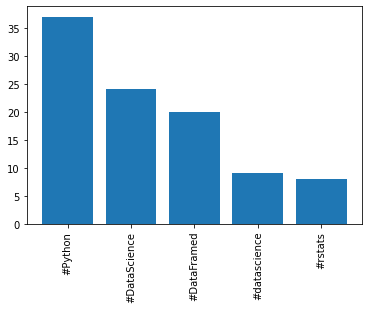

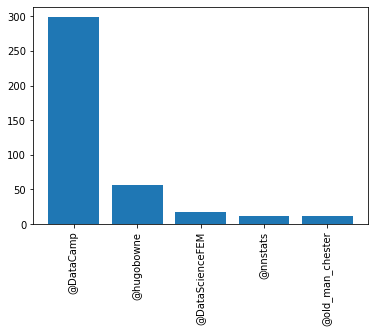

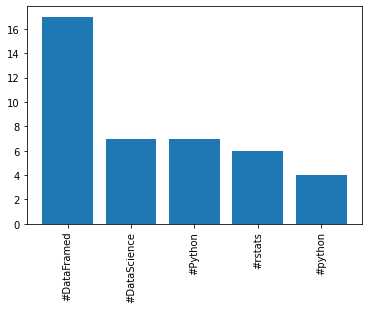

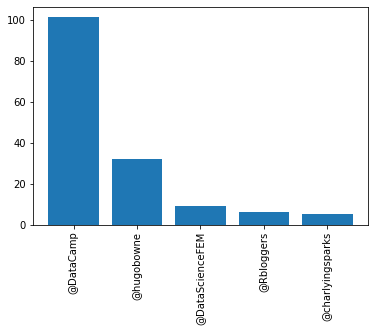

In [3]:
my_tweets.plot_counts('hashtag_counts')
my_tweets.plot_counts('mention_counts')
my_tweets.retweets.plot_counts("hashtag_counts")
my_tweets.retweets.plot_counts("mention_counts")

In [4]:
help(text_analyzer.Document)

Help on class Document in module text_analyzer.document:

class Document(builtins.object)
 |  Document(text)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, text)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  plot_counts(self, attribute, n_most_common=5)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



['DataCamp', 'Introduction', 'to', 'H', 'O', 'AutoML', 'In', 'this', 'tutorial', 'you', 'will', 'learn', 'about', 'H', 'O', 'and', 'have', 'a', 'glimpse', 'of', 'its', 'auto', 'DataCamp', 'Stocks', 'Significance', 'Testing', 'p', 'Hacking', 'Learn', 'how', 'to', 'manipulate', 'time', 'series', 'data', 'with', 'pandas', 'and', 'co', 'RT', '@cbismuth', 'Linear', 'regression', 'example', 'with', 'most', 'significant', 'features', 'detection', '#DataCamp', '#DataScience', '#Python', '#sklearn', 'Linear', 'regression', 'example', 'with', 'most', 'significant', 'features', 'detection', '#DataCamp', '#DataScience', '#Python', '#sklearn', 'Basic', 'linear', 'regression', 'example', '#DataCamp', '#DataScience', '#Python', '#sklearn', 'RT', '@David_Makinde_', 'I', 'just', 'completed', 'Introduction', 'to', 'Python', 'for', 'Data', 'Science', '#Datacamp', '#DataScience', '#Python', 'DataCamp', 'Enter', 'the', '#DataFramedChallenge', 'for', 'a', 'chance', 'to', 'be', 'on', 'an', 'upcoming', 'podca

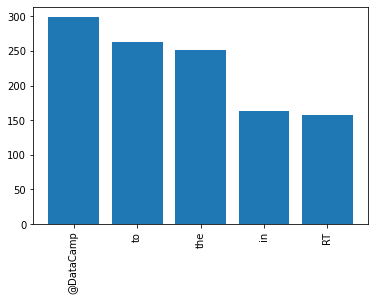

In [4]:
datacamp_tweets = '[DataCamp] Introduction to H2O AutoML --> In this tutorial, you will learn about H2O and have a glimpse of its auto…\n[DataCamp] Stocks, Significance Testing & p-Hacking --> Learn how to manipulate time series data with pandas and co…\nRT @cbismuth: Linear regression example with most significant features detection. #DataCamp #DataScience #Python #sklearn …\nLinear regression example with most significant features detection. #DataCamp #DataScience #Python #sklearn\nBasic linear regression example. #DataCamp #DataScience #Python #sklearn\nRT @David_Makinde_: I just completed Introduction to Python for Data Science \n#Datacamp\n#DataScience \n#Python\n[DataCamp] Enter the #DataFramedChallenge for a chance to be on an upcoming podcast segment. --> DataCamp has a pod…\n[DataCamp] Introduction to Python Metaclasses --> In this tutorial, you\'ll learn about metaclasses in Python. by De…\nI just completed Introduction to Python for Data Science \n#Datacamp\n#DataScience \n#Python\nRT @cbismuth: My pretty first classifier! #DataCamp #Python #sklearn\nMy pretty first classifier! #DataCamp #Python #sklearn\nRT @ascentt: The different #DataScience roles on the job market. \n\n\n\n#SoftwareTesting #DataEngineer #DataScientist #…\nThe different #DataScience roles on the job market. \n\n\n\n#SoftwareTesting #DataEngineer…\nConseguí el contacto de una de las encargadas de la división informática de la OPP (gracias a la gente del…\nWeapons of Math Destruction #datacamp #podcast\n[DataCamp] Shareable Data Science with Kyso --> In this tutorial, you’ll learn how to create publishable and reprod…\nStudying has to be done every day, prepare yourself for the next opportunity. A leader must show how its done.…\n@DataCamp #learningR #programming #datacamp\nTrilha incrível de Programação em Python do projeto DataCamp, concluída com sucesso! 🙌🙌🙌\n#DataCamp #DataScience…\nDepois de um longo dia de trabalho é hora de investir no futuro. #OQueVamosAprenderHoje ?\n\n#datascience #dsa…\nRT @charlyingsparks: This is so spot on. \n@DataCamp @hugobowne #DataFramedchallenge @hmason #empathy\n#datascience #datacamp …\nRT @gastronomy: [DataCamp] Naive Bayes Classification using Scikit-learn --> Learn how to build and evaluate a Naive Bayes Classifier using…\n[DataCamp] Naive Bayes Classification using Scikit-learn --> Learn how to build and evaluate a Naive Bayes Classifi…\nThis is so spot on. \n@DataCamp @hugobowne #DataFramedchallenge @hmason #empathy\n#datascience #datacamp\nIf you want to learn Data Science, start with one of these programming classes by @venturidb…\nLearning about #Shiny in #Datacamp with @minebocek\nRT @aaysbt: Day 32 : I jsut completed the statistical thingking course @DataCamp.  There was lot of thinks to learn my brain is killing me…\n@BernieMat @epi_twit @DataCamp @RStudioJoe @zabormetrics\n@malco_barrett @epi_twit @DataCamp @RStudioJoe @zabormetrics This is perfect. You may have just saved me months of stress in one tweet.\n@BernieMat @epi_twit @DataCamp DataCamp has a course on survival analysis (\n@malco_barrett @epi_twit @DataCamp And thanks for the refs - extremely helpful.\n@malco_barrett @epi_twit @DataCamp Things such as setting up data for survival analysis. I use \'stset\' religiously in Stata.\nI can’t continue the class “Text Mining: Bag of Words”@DataCamp\n@BernieMat @epi_twit In general, I recommend @DataCamp and R for Data Science (\nRT @khalid__amer: Day 5 of #100DaysOfCode :\nI have finished the chapter "Customizing plots" from "Introduction to Data Visualization with P…\nRT @DataCamp: New Tutorial: Introduction to Python Metaclasses! In this tutorial, learn what #metaclasses are, how to implement them in #Py…\nI just completed the course "Joining Data in PostgreSQL"!\n“Business people do not need to apologize for wanting to know what the customer wants...” - @andrewgelman with…\n“Big data tends to be messy data. Instead of a random sample, you often get a convenient sample...” - @andrewgelman…\n@DataCamp do you have a curriculum suggestion to mimic the \'Quantitative Analyst with R\' track, but focused on…\nRT @mustafanafees: \u2066@DataCamp \u2069’s Data Science And #MachineLearning  Programs: A Review\n@drjekyll75 @DataCamp @dataquestio @kaggle ooh cool, I don\'t know them. might give something a try :)\n@iC0dE_ @dataquestio @DataCamp both offer courses that are really good. I’m doing the python pipeline and it’s free…\n@Dame_Of_Spades @DataCamp @dataquestio both offer free courses that are really good. @kaggle is another good one wi…\nThanks @NickCarchedi and @DataCamp for "Intro to SQL for Data Science". Great course!\nRT @DataCamp: Analyzing Police Activity with pandas! In this course, you’ll practice cleaning messy data & create visualizations. This cour…\nDay 32 : I jsut completed the statistical thingking course @DataCamp.  There was lot of thinks to learn my brain is…\nRT @gelliottmorris: Want to learn how to analyze political data? Trying to figure out #rstats and want a familiar dataset? I\'ve got somethi…\nRT @drjekyll75: #100DaysOfCode R1D23: I just completed the course "Intro to Python for Data Science"! …\nI just completed the course "Intro to Python for Data Science"!\n\u2066@DataCamp \u2069’s Data Science And #MachineLearning  Programs: A Review\nI just completed the course "Importing Data in Python (Part 2)"!\n@nnstats @DataCamp Another question .. any special reasons for using RStata? Are there things Stata can do that R can\'t? Tq\n#Python vs R battle for supremacy in #DataScience: \n\n#Infographic by @DataCamp\n\n#BigData…\n@DataCamp It would be awesome if we could bookmark courses we\'re interested in. It\'d be even more awesome if we could create playlists.\nRT @DataCamp: Modeling with Data in the Tidyverse! In this course, you will learn to model with data. Models attempt to capture the relatio…\n@JamesMarsh79 @DataCamp Thanks\n@ShipSystem @DataCamp I did think the interface worked well and directions were clear most of the time\n@JamesMarsh79 @DataCamp any feedback?\nI’m entering #dataframedchallenge and you’ll see me coming. Can’t wait to listen to some great podcasts! @DataCamp @hugobowne\nI just completed the course "Introduction to R"!\nThoroughly enjoyed the Introduction to the Tidyverse course @DataCamp by @drob. Great instructor!…\nRT @jenineharris: I am so excited to officially be a @DataCamp instructor! Thank you to the fantastic @old_man_chester and @venturidb for w…\n@jenineharris @DataCamp @old_man_chester @venturidb WHAT!!! Congrats Dr. HaRRis!!\nThoroughly enjoyed the Career Track Data Scientist with R @DataCamp course, great instructors!, getting the most ou…\nWant to learn how to analyze political data? Trying to figure out #rstats and want a familiar dataset? I\'ve got som…\nI just completed the course "Cleaning Data in R" @DataCamp. Learned a lot of functions from #tidyr, #stringr, and #lubridate packages!\nThoroughly enjoyed the Joining Data in PostgreSQL @DataCamp course by @old_man_chester. Great instructor!\nRT @DataCamp: Did you already get your Pandas basics cheat sheet? -\n#100DaysOfCode R1D23: I just completed the course "Intro to Python for Data Science"!\n@DataCamp Here\'s another introduction to (K-Means clustering) analysis applied to UK Police data…\n@DannyIsSerious @nnstats @DataCamp How good is the Rstata  package?\nRT @simplivllc: Python Programming Certification Course {40%OFF}\n\n#technology #Software #MachineLearning #tech #educ…\nRT @nnstats: ok, responses to the data science questions that have been thrown my way in the last 24 hours:\n\n• Python or R?\ndoesn’t matter.…\nRT @pisastero: I\'ve just discovered ggthemes and the many many hours of @DataCamp have just paid off a million times. This is a game change…\nJust got back from a week in Dublin with @DataCamp for our work week and I only have 100 or so Github notifications, far less than expected!\nRT @sctyner: Back from vacation today, and this lovely gift from my friend @chendaniely was waiting for me! Which reminds me, I need to get…\nBack from vacation today, and this lovely gift from my friend @chendaniely was waiting for me! Which reminds me, I…\nData science for biologists course @ucl is underway! A massive thank you to @DataCamp for giving us access to their wonderful tutorials!\nRT @rstudio: @DukeSSRI has been developing a free 7part @DataCamp series on Causal Inference with R. The first 3 parts are up;\n-Intro https…\n@jenineharris @DataCamp @old_man_chester @venturidb Awesome! Congrats!\nRT @aaysbt: Day 31 : Hypothesis test examples as apart of the statictical thingking course @DataCamp #100DaysOfCode #python #Statistics #Da…\nI am so excited to officially be a @DataCamp instructor! Thank you to the fantastic @old_man_chester and @venturidb…\nPython Programming Certification Course {40%OFF}\n\n#technology #Software #MachineLearning…\nRT @DataCamp: Intermediate Spreadsheets for Data Science! This course will expand your Google Sheets vocabulary. You\'ll dive deep into data…\nRT @DataCamp: Pivot Tables with Spreadsheets! Learn techniques such as sorting, subtotaling, & filtering your data using real world example…\nRT @DataCamp: Could TensorBoard help you? This tutorial will guide you on how to use TensorBoard, which is a fantastic utility that allows…\nDay 31 : Hypothesis test examples as apart of the statictical thingking course @DataCamp #100DaysOfCode #python…\nI just completed the course "Network Science in R - A Tidy Approach"!\n@nnstats @DataCamp Datacamp was nice bc you never had to set up an environment or manages package/version conflicts…\nRT @aaysbt: Day 30: bootstrap confidence intervals as a part of the statistical thinking in #python course @DataCamp #100DaysOfCode #CodeNe…\n@DataCamp It has been more than 4 days, you guys are not resolving the issues. I am waiting, Request #119967. Can a…\nRT @DataCamp: Are you manipulating time series data in R with xts? Get your copy of DataCamp\'s xts cheat sheet here: …\nRT @AndroidCiudadan: #100DaysOfCode R2Day41-42: I\'ve been grinding the @DataCamp Data science courses with python, having fun with the data…\n#100DaysOfCode R2Day41-42: I\'ve been grinding the @DataCamp Data science courses with python, having fun with the d…\nI just completed the course "Joining Data in PostgreSQL"!\nRT @DataCamp: New Tutorial: Naive Bayes Classification using Scikit-learn! Learn how to build and evaluate a #Naive #Bayes #Classifier usin…\n@nnstats @DataCamp Can R run SAP hockey analytics\n@MBMiller_AT @AcademicChatter @DataCamp You\'re welcome!  Hope that helps 😊\n@PNgsabrina @AcademicChatter @DataCamp Great thanks!\n@MBMiller_AT @AcademicChatter Highly recommend  @DataCamp ! They have detail video tutorials and practices to conso…\nGood tool for learners of #Datascience #Data #Python #Pandas #Numpy @DataCamp\n@nnstats @DataCamp Do a Twitter survey for the question: Python or R.\n@nnstats @hugobowne @DataCamp I like this post\nRT @DataCamp: New Tutorial: Shareable Data Science with @kyso_io! Learn how to create publishable and reproducible data science studies on…\n@PREDStotheCUP @nnstats @DataCamp Something pirates say\n@CodeNewbies A2: Just finished up my semester. Looking to keep working on @DataCamp courses during the down time. A…\nI\'ve just discovered ggthemes and the many many hours of @DataCamp have just paid off a million times. This is a game changer. #rstats\nDay 30: bootstrap confidence intervals as a part of the statistical thinking in #python course @DataCamp…\n@Rick_Scavetta I recently finished parts 1 and 2 of your Data Visualization with ggplot2 course on @datacamp. The d…\nRT @DataCamp: Tutorial: Bivariate Distribution Heatmaps in R! Learn how to visually show the relationship between two features, how they in…\n@nnstats @DataCamp where can i find the numbies\n@nnstats @DataCamp So I’m exploring the RStata package, but it doesn’t look like it can generate graphical output. Am I missing something?\nHello #R4DS community I’m getting into R course by @DataCamp... Any tips for some projects to play with?!\nI also vouch for @DataCamp\n@nnstats @DataCamp What is R?\nok, responses to the data science questions that have been thrown my way in the last 24 hours:\n\n• Python or R?\ndoes…\n@DataCamp Hi! do y’all have a phone number for customer service?\nRT @iPablo26: I just completed the Pandas foundation course on @DataCamp \n#DataScience #machinelearning #Python #learningcurve …\nI just completed the Pandas foundation course on @DataCamp \n#DataScience #machinelearning #Python #learningcurve\nI just completed the course "Importing Data in Python (Part 2)"!\nRT @DataCamp: This handy one-page cheat sheet presents the #Python basics that you need to perform data analysis!\n…\nRT @OyewoleIsmail: Yes!!!!!, Journey of over 90 days on @DataCamp,  learning Data Science. Thanks 2 @DataCamp and All the instructors for t…\nRT @BCBreeden: During my winter break I want to stay sharp. Going to tackle data imports and some visualization courses on @DataCamp. #Data…\nDuring my winter break I want to stay sharp. Going to tackle data imports and some visualization courses on…\nI try to split my days when i have time.\n\nOne day read my books\nSecond day continue my work @DataCamp \nThird day fo…\nI just completed the course "pandas Foundations"!\nThough I was asked by @DataCamp to share the tweet above, I am genuinely grateful for the opportunity to integrate…\n@AlenaShiryaev12 @DataCamp You’re welcome! Keep an eye out for a great follow-up course by @mona_khm coming soon!\n1 año más de @DataCamp  esta vez si lo aprovecharé jeje hay tanto que aprender\nWhen you start getting @DataCamp ads on your kpop videos...\n#gradschool #gradstudentlife #whyme\nRT @DataCamp: Watch a new webinar by @robinson_es, a data scientist at DataCamp, who will give a brief introduction to the concept of the #…\nThoroughly enjoyed the Joining Data in PostgreSQL @DataCamp course by @old_man_chester. Great instructor!…\nI just completed the course "Python Data Science Toolbox (Part 1)"!\nRT @muxevola: @DataCamp @hugobowne #DataFramedChallenge @wesmckinn\nPandas\' built-in assumption is that data fits in memory. If you want to…\nRT @DataCamp: New Course: Working with Data in the Tidyverse! You\'ll learn to work with data using tools from the #tidyverse in R. Througho…\nRT @MercyMarkus: I just completed the course "Importing Data in Python (Part 2)"!\nRT @RikaGorn: Taking notes during a podcast is def a first for me! Just listened to the brilliant @AngeBassa on @DataCamp DataFramed podcas…\n@MercyMarkus @DataCamp Congrats! Am coming to block you for you to teach me oh\nI just completed the course "Importing Data in Python (Part 2)"!\nI just completed the course "Importing Data in Python (Part 1)"!\n@DataCamp is generously supporting my class. Find out more about DataCamp for the Classroom:\nThoroughly enjoyed the Joining Data in PostgreSQL @DataCamp course by @old_man_chester. Great instructor!\n@DataCamp My annual subscription automatically renewed without any prior warning (such as an email). I did not want…\n@DataCamp Any sales coming?\nIn addition still work on my own programming language. \n\nWork on my other projects and earn my credentials to be a…\nI just completed the course "Python Data Science Toolbox (Part 1)"!\n@718143 @DataCamp @ProjectJupyter @codingphase Mind blown!\n@RikaGorn @AngeBassa @DataCamp @iRobot This was definitely of my memorable episodes from @DataCamp , actually I sho…\nI just completed the course "Intermediate Python for Data Science"!\nRT @718143: #Day39 \n📖 #Python reference material to break up my @DataCamp & @ProjectJupyter routine -\nAlso, THIS:  (…\n#Day39 \n📖 #Python reference material to break up my @DataCamp & @ProjectJupyter routine -\nAlso, THIS:…\n@RikaGorn @AngeBassa @DataCamp @iRobot ⭐️⭐️⭐️⭐️⭐️\nRT @Kunkakom: @maqartan @aecoppock \n\nChristmas is close.\nOn my wishlist: A @DataCamp intro course to DeclareDesign.\n\nThank you, Santa!\n@Kunkakom @maqartan @DataCamp That\'s a fantastic idea. We\'ll send it up north and see what he says!\n@maqartan @aecoppock \n\nChristmas is close.\nOn my wishlist: A @DataCamp intro course to DeclareDesign.\n\nThank you, Santa!\n@DataCamp @jpls93 Definitely didn’t get a reminder email.\n@DataCamp @shankarSRC I’m in the same situation with no renewal reminder.\n@DataCamp @jpls93 I have the same problem - no refund? Guess I’ll have to dispute it with my CC.\nTaking notes during a podcast is def a first for me! Just listened to the brilliant @AngeBassa on @DataCamp DataFra…\nRT @DataCamp: New Project by @venturidb: Introduction to DataCamp Projects! An introduction to DataCamp projects, we\'ll walk you through th…\nThanks @DataCamp for refunding the unintentional annual subscription!\nRT @capigian: Excited to be using @DataCamp for the Classroom in my Predictive Analytics class. They support education for free via this in…\nBlended learning üzerine güzel bir haber! Leuphana Üniversitesi “Data Science” kürsüsü, premium üyelik için…\nYes!!!!!, Journey of over 90 days on @DataCamp,  learning Data Science. Thanks 2 @DataCamp and All the instructors…\nExcited to be using @DataCamp for the Classroom in my Predictive Analytics class. They support education for free v…\nRT @hahaha_it_is_i: Day 45 #100DaysOfCode\n\nSome @DataCamp, some #pytorchudacityscholar challenge. Nothing significant in either. Just chugg…\nThoroughly enjoyed the Introduction to the Tidyverse course @DataCamp by @drob. Great instructor!…\nAdvice for Applying to #DataScience Jobs\n@techmariah @DataCamp Yes!\n@hahaha_it_is_i @DataCamp Keep it up! Inspired to continue by seeing other women do the challenge! #WomenWhoCode\nDay 45 #100DaysOfCode\n\nSome @DataCamp, some #pytorchudacityscholar challenge. Nothing significant in either. Just c…\nRT @AndroidCiudadan: #100DaysOfCode R2Day40: Today I started a course of data science on @DataCamp, I learned about numpy, matplotlib and I…\n#100DaysOfCode R2Day40: Today I started a course of data science on @DataCamp, I learned about numpy, matplotlib an…\nIf this football game has you down, you can always learn some linear algebra here :)\n\n\n\n@DataCamp\nRT @hugobowne: Nearly everybody: If you want to run machine learning in production you use python.\n\nMe: You\'re wrong.\n\nNearly everybody: WT…\nRT @DaveRubal: Bokeh is the #Python #datavisualization library that enables high-performance visual presentation of large datasets in moder…\nRT @tyleransom: I was on the team that created these free @DataCamp courses on causal inference in R. Check them out if you think they’d be…\nRT @aaysbt: Day 29 : Statistical thinking for #DataScience and learning Parameter estimation by optimization @DataCamp #100DaysOfCode #pyth…\nRT @charlyingsparks: We can\'t forget to have fun in what we do.\n\n@datacamp @hugobowne "First and foremost just keep your excitement for it,…\nWe can\'t forget to have fun in what we do.\n\n@datacamp @hugobowne "First and foremost just keep your excitement for…\n@DataCamp by @drob --> if I\'ve got good mark at my assessment thanks to your lesson, I gonna follow them all ! (by…\nNew Tutorial posted on @DataCamp !\nRT @DataCamp: New Tutorial: Automated Machine Learning with Auto-Keras! Learn about automated machine learning and how it can be done using…\n@dsimposters @BecomingDataSci @DataCamp Thank you very much. I appreciate your input.\n@jpls93 @DataCamp Same here this is not only shows bad business practices but also the true intentions to rip off\n@DataCamp I had so much of respect for you guys as your company but today they are all going to be ruined when I se…\nHi @DataCamp - I missed the cyber monday sale. Any chance I can get it still or are there any other sales coming up? Thanks!\nThoroughly enjoyed the Introduction to the Tidyverse course @DataCamp by @drob. Great instructor!\nWelcome:    :)\n@GalarnykMichael @vivekkhetan_ism @PurpleBooth @willems_karlijn @DataCamp Thanks! I think you’re right, and have ju…\n@markchand @PurpleBooth @willems_karlijn @GalarnykMichael @DataCamp Great work @markchand.      Keep doing it with…\n@PurpleBooth @vivekkhetan_ism @willems_karlijn @GalarnykMichael @DataCamp Thanks! Good questions. I mostly wrote it…\n@DataCamp MVPs of the team: @JimSpeckart and @mattmasten\nI was on the team that created these free @DataCamp courses on causal inference in R. Check them out if you think t…\n@aaysbt @DataCamp Kudos! 🎉\nThoroughly enjoyed the Introduction to the Tidyverse course @DataCamp by @drob. Great instructor! I am left wonderi…\n@MercyMarkus @DataCamp ok I\'ll go check it out. Thank you.\n@itsDonmonc @DataCamp Just the first module, you\'ll need to pay to access the rest of the course content.\nI just completed the course "Intro to Python for Data Science"!\n@MercyMarkus @DataCamp is this under one of their free courses?\nBokeh is the #Python #datavisualization library that enables high-performance visual presentation of large datasets…\n@DataCamp Extremely angry to see that my yearly subscription auto-renewed without warning today! Help article…\nDay 29 : Statistical thinking for #DataScience and learning Parameter estimation by optimization @DataCamp…\nLoved @juliasilge tidy text mining with R on @DataCamp, particularly the Shakespeare text/outfit! #moreplease\n@DataCamp You have a good product. I\'ll subscribe to you again anytime I consider studying Data Science again. But…\n@markchand @vivekkhetan_ism @willems_karlijn @GalarnykMichael @DataCamp Great work! You have a very approachable wr…\nLearned a lot with subquerying exercises!\nThoroughly enjoyed the Joining Data in PostgreSQL @DataCamp course by…\nThoroughly enjoyed the Joining Data in PostgreSQL @DataCamp course by @old_man_chester. Great instructor!\nRT @718143: #Day38\nMore! More! More Methods review in @DataCamp 📝📝😁📃\n\nLess actual programming today and more focus on those basic #Python p…\n#Day38\nMore! More! More Methods review in @DataCamp 📝📝😁📃\n\nLess actual programming today and more focus on those bas…\nRT @DataCamp: Working with Dates and Times in R by @CVWickham! This course teaches you the essentials of parsing, manipulating, and computi…\nRT @nebelgrau77: Incorporating @DataCamp\'s "DataFramed" into my daily soundstream was a great idea! There\'s so much to learn, this time fro…\nRT @charlyingsparks: @DataCamp @hugobowne  "I think we all really need to push for openness of data. I think there\'s an incredible opportun…\n@markchand @vivekkhetan_ism @PurpleBooth @willems_karlijn @DataCamp Its nice! My only advice is to put it a blog ty…\nI\'m trying to learn #Python, so I wrote a thing. What do you think, Internet? \nWith thanks t…\nRT @mkuehn10: I just completed the course "Foundations of Functional Programming with purrr"! …\nI just completed the course "Foundations of Functional Programming with purrr"!\n@DataCamp @hugobowne  "I think we all really need to push for openness of data. I think there\'s an incredible oppor…\n@LukeNdatigh @DataCamp Thank you 🤗\nIncorporating @DataCamp\'s "DataFramed" into my daily soundstream was a great idea! There\'s so much to learn, this t…\n@MercyMarkus @DataCamp Congratulations!\n@DataCamp Hello, I would like to speak to customer service\n@DataCamp Thank you, dropped an email.\n@DataCamp #learningR #programming #datacamp\n@DataCamp @hugobowne @mathbabedotorg I would suggest everyone to first check your support page for number of people…\n@MercyMarkus @DataCamp Sist...🙌🙌\n@DataCamp @hugobowne @mathbabedotorg I did, there is no response. This is an unethical business conduct. Every othe…\nI just completed the course "Importing Data in Python (Part 1)"!\nRT @DataCamp: Scikit-learn cheat sheet: #machinelearning with #Python -\n@DataCamp @hugobowne @mathbabedotorg Please do not subscribe to this fraud courses. Datacamp deducted money from my…\n@DukeSSRI has been developing a free 7part @DataCamp series on Causal Inference with R. The first 3 parts are up;\n-…\n@DataCamp can you please cancel the subscription which got auto processed today.\n#Day37\nMore on-the-go coding with both @DataCamp & @dcodermobile using #Python functions while index calling from a…\n@DataCamp You guys keep me hooked more than Netflix\nRT @dataiku: Being a data science manager isn\'t about giving your team all the answers - it\'s about guiding them there instead. Learn how t…\n@nicholdav @DarknetDiaries @USTpodcast @pgmid @twimlai @DataCamp @TalkPython @thedollop @CucubanoPod Weird flex, but OK\n@KirkDBorne @MusicComposer1 @alcgroup @data_nerd @Shirastweet @dez_blanchfield @digitalcloudgal @TeachTheMachine…\nI just completed the course "Introduction to Data Visualization with Python"!\nRT @KirkDBorne: @NexWebSites @MusicComposer1 @alcgroup @data_nerd @Shirastweet @dez_blanchfield @digitalcloudgal @TeachTheMachine @edXOnlin…\n@NexWebSites @MusicComposer1 @alcgroup @data_nerd @Shirastweet @dez_blanchfield @digitalcloudgal @TeachTheMachine…\nRT @ikayz360: Done, up and running with Python for #DataScience #DevCTraining cheers @DataCamp\nDone, up and running with Python for #DataScience #DevCTraining cheers @DataCamp\nI just completed the course "Intro to Python for Data Science"!\n@MihiretuKebede1 @thomasp85 @DataCamp Yes! I though there was a section in the current courses. This will appear in…\nRT @charlyingsparks: This is so spot on. \n@DataCamp @hugobowne #DataFramedchallenge @hmason #empathy\n#datascience #datacamp …\nThanks @DataCamp for making my Bioinformatics class better next year!  Excited to use your lessons to get biologists to love R.\n@DerekChia @DataCamp Thanks! Be on the lookout for a great follow-up course from @mona_khm coming soon!\nRT @uomodlamansarda: @hugobowne @DataCamp @mathbabedotorg Your podcasts are amazing! I never miss one! :)\nRT @aaysbt: Day 28 : I have been complete the course Statistical Thinking in Python (Part 1) @DataCamp #100DaysOfCode #PYTHONPROGRAMMING #P…\n@hahaha_it_is_i @DataCamp I just finished lesson 2 as well 🙂\n@nerdnomadmom @DollaSignBeezy @DataCamp Look at the Azure certs.\nThis is so spot on. \n@DataCamp @hugobowne #DataFramedchallenge @hmason #empathy\n#datascience #datacamp\nDay 28 : I have been complete the course Statistical Thinking in Python (Part 1) @DataCamp #100DaysOfCode…\n@muxevola @DataCamp @hugobowne @wesmckinn although, even if it should fit in memory... sometimes it doesn\'t\nRT @muxevola: @DataCamp @hugobowne #DataFramedChallenge @wesmckinn\nPandas is occupying the sweet spot of being the ultimate Swiss army knif…\nRT @muxevola: @DataCamp @hugobowne @mathbabedotorg #DataFramedChallenge\nFairness and transparency do not seem a proper incentive to undergo…\nThoroughly enjoyed the Joining Data in PostgreSQL @DataCamp course by @old_man_chester. Great instructor!\n@nerdnomadmom @DollaSignBeezy @DataCamp Crazy random, but Ari and I have the same birthday lmaoo small world.\n@nerdnomadmom @DollaSignBeezy @DataCamp Any hints on how to learn data science ?\n@nerdnomadmom @DollaSignBeezy @DataCamp Which cert is for data science for security ?\n@nerdnomadmom @DataCamp That Data Science one seems interesting . Big $$$\n@iPablo26 @DataCamp Congrats 🎉🎈🍾 keep on going 😀\nHaving auto-renewal of subscription turned on as default is very bad UX. Disappointed, @DataCamp. It would\'ve been…\nJust finished my @DataCamp \'s "Python Programmer Track" while have no related \'background\' whatsoever with the cour…\nRT @jsjoeio: Friends who are looking for a job! 😀\n\nIf you\'re passionate about education, JavaScript and looking to work in NYC, check out t…\n@DataCamp @hugobowne @mathbabedotorg #DataFramedChallenge\nFairness and transparency do not seem a proper incentive…\n@DataCamp @hugobowne #DataFramedChallenge @wesmckinn\nPandas is occupying the sweet spot of being the ultimate Swiss…\n@DataCamp @hugobowne #DataFramedChallenge @wesmckinn\nPandas\' built-in assumption is that data fits in memory. If yo…\n@DataCamp is there a Cyber Monday discount code for this year?\nRT @QuantStratTradR: New post using technology from @OptimizeRisk \'s @DataCamp course …\n#Day36\nTrying out the @DataCamp app on the go 🏃 today to further the #Python benefits gained through repetition 📖…\nRT @charlyingsparks: @hugobowne @DataCamp "...inspiration is cheap, but rigor is expensive." -@quaesita #truth #DataScience #dataframedchal…\n@hugobowne @DataCamp "...inspiration is cheap, but rigor is expensive." -@quaesita #truth #DataScience #dataframedchallenge\nRT @hahaha_it_is_i: Day 42 #100DaysOfCode\n\nAnother chapter @DataCamp.\n\nFinished lesson 2 in the pytorch challenge. Feels good to be moving…\nRT @JamesMarsh79: I’ve been using @DataCamp free courses in R and I must say for a super beginner like me, they have been pretty intuitive.\nI’ve been using @DataCamp free courses in R and I must say for a super beginner like me, they have been pretty intuitive.\nFriends who are looking for a job! 😀\n\nIf you\'re passionate about education, JavaScript and looking to work in NYC,…\nDay 42 #100DaysOfCode\n\nAnother chapter @DataCamp.\n\nFinished lesson 2 in the pytorch challenge. Feels good to be mov…\nNew post using technology from @OptimizeRisk \'s @DataCamp course\nRT @DataCamp: 🎙New #DataFramed Episode: @hugobowne speaks with @pjbull, a data scientist for social good and co-founder of @drivendataorg,…\n@iPablo26 @DataCamp Congratulations\nRT @DataCamp: This #SciPy SciPy cheat sheet covers the basics of linear algebra in #Python that you need to get started - …\n@DarknetDiaries wonder how easy it would be to scrape the iTunes charts and do some anomaly detection? Obvs Apple a…\n@CMastication @woody_gsd @voidspace I agree. I started out with just google - and I was able to learn ways to do th…\n@EconoTodd @DataCamp @hugobowne you’ve got a fan! Let’s all get a beer soon.\n¿Diferencias entre el aprendizaje automático y el aprendizaje profundo?\nUna visión general de la Inteligencia Artif…\nRT @muxevola: Fairness is a statistical concept. It\'s a notion that we need to understand at an aggregate level. @DataCamp @hugobowne @math…\nRT @spenafajuri: Hoy estoy haciendo este curso en @DataCamp: Designing and Analysing Clinical Trials in R\nHoy estoy haciendo este curso en @DataCamp: Designing and Analysing Clinical Trials in R\nFairness is a statistical concept. It\'s a notion that we need to understand at an aggregate level. @DataCamp…\nRT @iPablo26: I completed the Cleaning Data in Python Course on @DataCamp  on the 1st of December 2018. On to Pandas foundation.\n#datascien…\nRT @JSnunki: Muy orgullosa \U0001f929\U0001f929\U0001f929 Thanks @DataCamp 👩\u200d🎓👩\u200d🎓👩\u200d🎓 ahora somos 15 😎😎 2019 tal vez 30.👩\u200d🏫👩\u200d🏫\n@vannyozogu @DataCamp Thank you\n@iPablo26 @DataCamp Well done!💪🏾💪🏾\n@DataCamp very useful\nI completed the Cleaning Data in Python Course on @DataCamp  on the 1st of December 2018. On to Pandas foundation.…\n#AI #ArtificialIntelligence #ML #MachineIntelligence #MachineLearning #neuralnetwork #programmers #developers…\nRT @malco_barrett: @nskajaa For learning R in general, I always recommend @DataCamp and R for Data Science (…\nI must say that I\'m very much enjoying the @DataCamp - Data Framed podcast. A nice mix of commentary, history, and…\nI was selected as a recipient of @DataCamp’s Women and Minorities scholarship, and though I’ve already completed a…\nRT @DataCamp: Demystifying crucial statistics in Python! In this tutorial, learn about the basic statistics required for Data Science and M…\nAmen @DataCamp is absolutely amazing! I’m always excited for the next TEMPORARY CHALLENGE! #codinglife #javascript\nI just completed the course "Importing Data in Python (Part 1)"!\nRT @DataCamp: Join us next Thursday for a new live coding event on Facebook! Introduction to the Tidyverse: Survivors of the Titanic, the T…\nRT @HaSN_CH: #100DaysOfCode \nA #day well spent on @DataCamp \n#DataScience #Database #sql #developers #Python\n@nskajaa For learning R in general, I always recommend @DataCamp and R for Data Science (\n#100DaysOfCode \nA #day well spent on @DataCamp \n#DataScience #Database #sql #developers #Python\nI just completed the course "Reporting with R Markdown"!\nRT @dataelixir: Managing Data Science Teams with @AngeBassa via @DataCamp\n@brandibeals @DataCamp Oh well. Even though it didn\'t work for me, thanks for posting!\nBeing a data science manager isn\'t about giving your team all the answers - it\'s about guiding them there instead.…\nRT @doodssiton: Learned so much sifting through the Visualizing Geospatial Data With Python course @DataCamp by @marylvv. Thank you! https:…\n@Gators80 @kearneymw @DataCamp @dataandme Thank you for the recommendations.\nRT @Mteheran: @calypso_bronte @DataScienceFEM @DataCamp Felicitaciones!!!\n@doodssiton @DataCamp Glad to hear this!\nRT @promptcloud: In case you are taken in by the #DataScience buzz, take a look at the five resources listed in this blog - …\n@calypso_bronte @DataScienceFEM @DataCamp Felicitaciones!!!\n@cringngedup3 @DataCamp Thank you...\n@iamchantelphd @kearneymw I would recommend @DataCamp. I really like their teaching method (short videos followed b…\nI just completed the course "Analyzing Election and Polling Data in R"!\nIn case you are taken in by the #DataScience buzz, take a look at the five resources listed in this blog -…\n@Ugyen2007Norbu @DataCamp Congratulations boss\nRT @DataScienceFEM: Thank you @DataCamp @DataScienceFEM 💜💜💜👩\u200d🎓👩\u200d🎓#DataScientists #DataChallenge365Fem #DataScience #WomenInTech #Python htt…\nI just completed the course "Intermediate Python for Data Science"!\nLearned so much sifting through the Visualizing Geospatial Data With Python course @DataCamp by @marylvv. Thank you!\nLearning R is fun. Thanks for the great app @DataCamp\nRT @suryast_: @DataCamp your iOS app has a weird bug - in my case I am registered in youe database using my LinkedIn credential. Your login…\n@DataCamp your iOS app has a weird bug - in my case I am registered in youe database using my LinkedIn credential.…\nManaging Data Science Teams with @AngeBassa via @DataCamp\nMuy orgullosa \U0001f929\U0001f929\U0001f929 Thanks @DataCamp 👩\u200d🎓👩\u200d🎓👩\u200d🎓 ahora somos 15 😎😎 2019 tal vez 30.👩\u200d🏫👩\u200d🏫\nThank you @DataCamp @DataScienceFEM 💜💜💜👩\u200d🎓👩\u200d🎓#DataScientists #DataChallenge365Fem #DataScience #WomenInTech #Python\nRT @calypso_bronte: Nuestro grado como #DataScientists con @DataScienceFEM @DataCamp\nGreat refresher by @drob\'s @DataCamp course "Introduction to the Tidyverse"!\nNuestro grado como #DataScientists con @DataScienceFEM @DataCamp\nRT @iris9112: Purpose of 2018 ready! 🎉\nI am very happy because of the effort, the dedication, the help of my girls @DataScienceFEM and to @…\nRT @AgroNatureNig: …\n@keatonwilson @Chrismartin76 @JCSkewesDK @Gairan_P @DataCamp Theory vs facts. Datacamp has a million people taking their courses?\nRT @danielagsrm: Can’t believe we did it!!! 👩🏻\u200d💻💪🏼😱\n“Teach a girl to code and she’ll change the world” @DataScienceFEM \nThank you @DataCamp…\nRT @hugobowne: In Ep. 50 of #DataFramed, our Season 1 finale of the @DataCamp pod, I speak with @mathbabedotorg, author of Weapons of Math…\nRT @danielagsrm: @iris9112 @DataScienceFEM @DataCamp CONGRAAAAATS!!!!!! \U0001f942👯\u200d♀️❤️\nRT @GarbaAdams3: @Navas96Sofia @IamIgoche @DataCamp @DataScienceFEM Congrats\nRT @iris9112: @stifflerBassMan @DataScienceFEM @DataCamp Muchas gracias! Tal vez más adelante pueda aplicar. Aun necesito aprender mucho má…\nRT @stifflerBassMan: @iris9112 @DataScienceFEM @DataCamp @iris9112 por si te interesa:\n@stifflerBassMan @DataScienceFEM @DataCamp Muchas gracias! Tal vez más adelante pueda aplicar. Aun necesito aprender mucho más 🤘🤘\nCan’t believe we did it!!! 👩🏻\u200d💻💪🏼😱\n“Teach a girl to code and she’ll change the world” @DataScienceFEM \nThank you…\nRT @DataScienceFEM: Today graduation 👩\u200d🎓👩\u200d🎓 of the first scholarships of our fraternity @datasciencefem #datachallenge365fem 💜 sponsored by…\n@iris9112 @DataScienceFEM @DataCamp CONGRAAAAATS!!!!!! \U0001f942👯\u200d♀️❤️\nWE ARE DONE!\nI just completed the course "Network Analysis in Python (Part 1)"!\n@mrnavrc @DataCamp @Codecademy @hackerrank is a good site with small problems that can make you learn by doing. Wor…\n@iris9112 @DataScienceFEM @DataCamp @iris9112 por si te interesa:\nRT @mrnavrc: I found out that I didn\'t like the format of the Treehouse Python course (sorry guys). There are too many videos and I need a…\nI found out that I didn\'t like the format of the Treehouse Python course (sorry guys). There are too many videos an…\nGoing deeper!!! \nI just completed the course "Deep Learning in Python"!\nRT @DataCamp: New Tutorial: Working With Zip Files In Python! In this tutorial, you are going to learn how to work with #Zip Files in Pytho…\nNew Tutorial: Introduction to Python Metaclasses! In this tutorial, learn what #metaclasses are, how to implement t…\n@abhijitnsharma Hello, our support team has notified us that the issues have been resolved. Thank you for your patience.\nRT @gelliottmorris: Want to learn how to analyze political data? Trying to figure out #rstats and want a familiar dataset? I\'ve got somethi…\nAnalyzing Police Activity with pandas! In this course, you’ll practice cleaning messy data & create visualizations.…\nModeling with Data in the Tidyverse! In this course, you will learn to model with data. Models attempt to capture t…\nDid you already get your Pandas basics cheat sheet? -\nPivot Tables with Spreadsheets! Learn techniques such as sorting, subtotaling, & filtering your data using real wor…\nCould TensorBoard help you? This tutorial will guide you on how to use TensorBoard, which is a fantastic utility th…\nIntermediate Spreadsheets for Data Science! This course will expand your Google Sheets vocabulary. You\'ll dive deep…\nAre you manipulating time series data in R with xts? Get your copy of DataCamp\'s xts cheat sheet here:…\nNew Tutorial: Shareable Data Science with @kyso_io! Learn how to create publishable and reproducible data science s…\nWatch a new webinar by @robinson_es, a data scientist at DataCamp, who will give a brief introduction to the concep…\n@mbenchi10 Hello, please contact support@datacamp.com.\nWorking with Dates and Times in R by @CVWickham! This course teaches you the essentials of parsing, manipulating, a…\n@jpls93 Hi John, please contact support@datacamp.com. They will be able to look into your specific situation.\n@shankarSRC Hi Shankar, please contact support@datacamp.com. They will be able to look into your specific issue.\n@ur_zee @hugobowne @mathbabedotorg Hi Zaid, please contact support@datacamp.com. They will be able to look into your specific issue.\nNew Tutorial: Naive Bayes Classification using Scikit-learn! Learn how to build and evaluate a #Naive #Bayes…\nThis #SciPy SciPy cheat sheet covers the basics of linear algebra in #Python that you need to get started -…\nScikit-learn cheat sheet: #machinelearning with #Python -\nTutorial: Bivariate Distribution Heatmaps in R! Learn how to visually show the relationship between two features, h…\nDemystifying crucial statistics in Python! In this tutorial, learn about the basic statistics required for Data Sci…\n@aayushraman Hi, please contact support@datacamp.com. They will be able to assist you with this issue.\nNew Blog Post by @venturidb- Request for Proposal: Topical Projects for January 2019! Learn how to become a DataCam…\nNew Tutorial: Working With Zip Files In Python! In this tutorial, you are going to learn how to work with #Zip File…\nNew Tutorial- Regularization: Ridge, Lasso and Elastic Net! In this tutorial, you will get acquainted with the bias…\n@_nighthawk69_ Hi, please contact support@datacamp.com.\nRT @data_jen: I’m at #wintechseries all week representing @DataCamp and looking for #datascience and #analytics experts. We’re hiring!  Mes…\nNew Tutorial: Automated Machine Learning with Auto-Keras! Learn about automated machine learning and how it can be…\nRT @hugobowne: In Ep. 50 of #DataFramed, our Season 1 finale of the @DataCamp pod, I speak with @mathbabedotorg, author of Weapons of Math…\n@itsmevidhya_k Hi Vidhya, please contact support@datacamp.com if the issue still exists.\nNew Tutorial: Introduction to Machine Learning in Python! Get introduced to the world of Machine Learning (#ML) wit…\n@m8in_s Hi Martin, please contact support@datacamp.com. They will be able to help.\nNew Tutorial: Comparison of BI and Analytics Platforms! In this tutorial, you will learn about different factors th…\n🎙New #DataFramed Episode: @hugobowne speaks with @mathbabedotorg, author of Weapons of Math Destruction, about the…\n@hizoka_andou Hi, please contact support@datacamp.com.\nThis handy one-page cheat sheet presents the #Python basics that you need to perform data analysis!…\nDiscover why you should use Amazon Web Services Elastic Compute Cloud (EC2) and how you can set up a basic data sci…\nIntroduction to Monte Carlo Methods! In this tutorial, the reader will learn the Monte Carlo methodology and its ap…\nWorking with #Spark #SQL and DataFrames in #Python? Get your #PySpark SQL cheat sheet:\nNew Tutorial: Overview of Atom #IDE! In this tutorial, you\'ll learn the importance of IDEs, how to set-up #Atom, an…\nNew Project by @venturidb: Introduction to DataCamp Projects! An introduction to DataCamp projects, we\'ll walk you…\nThe issue has been resolved, and everything is currently back up and running. Thank you for your patience.\nWe are aware that our courses are currently down. We are working hard to get them back working. We will update you…\nNew Project by @ErinLaBrecq: Where Are the Fishes? In this project, you will explore two georeferenced data files c…\nNew Course: Multivariate Probability Distributions in R! In this course, you\'ll learn about common #multivariate…\nRT @hugobowne: In Ep. 49 of #DataFramed, the @DataCamp podcast, I speak with @wesmckinn, Director of Ursa Labs and creator of the pandas pr…\nNew Tutorial: AdaBoost Classifier in Python! Understand the ensemble approach, working of the #AdaBoost algorithm a…\nNew Tutorial: Differences Between Machine Learning & Deep Learning! In this tutorial, you\'ll get an overview of Art…\nNew DataFramed Episode: @hugobowne speaks with @wesmckinn, Director of Ursa Labs and creator of the #pandas project…\nScalable Data Processing in R! In this course, learn tools for processing, exploring, & analyzing data directly fro…\nIf you want to take a fresh, interactive approach to telling your data story, let users interact with your data and…\nApache Spark in Python: Beginner\'s Guide! A beginner\'s tutorial to Spark in Python based on 9 popular questions, su…\nIn this course, you\'ll get experience developing fun and realistic Shiny apps for different common use cases, such…\nApache Spark Tutorial: ML with PySpark! This Apache Spark tutorial introduces you to big data processing, analysis…\nIntroduction to R for Finance by @LoreDirick! In this finance oriented introduction to R, you will learn essential…\nRT @ACSundermann: #DataVisualization is key for understanding your own data and for communicating findings with others. 📊📈\n\nSo geeked to ta…\nNew Tutorial: Simplifying Sentiment Analysis in Python!\nLearn the basics of #sentiment #analysis and how to build a…\nNew Course by Tamuno Alfred: Designing and Analyzing Clinical Trials in R! You\'ll gain an overview of the important…\n@dirtymodelling @nj_tierney Hi Sarah, thank you for letting us know. We are looking into it now. Also, for future,…\nNew Course by @RallidaeRule: Foundations of Functional Programming with #purrr! Learn to easily extract, summarize,…\nNew Course by @nj_tierney: Dealing With Missing Data in R! Learn how to use #tidyverse tools and the #naniar R pack…\nRT @drivendataorg: Listen as our own @pjbull, a data scientist for social good and co-founder of Driven Data, talks with @hugobowne about t…\nRT @MaryLvV: I\'ll show you how to get insight from your #geospatial #data in this DataCamp course using #Nashville #OpenData . Check it out…\n@xZorex Thank you for bringing this to our attention. We will look into it.\n@mmughal @maartenlambert @BigData_LDN All of our cheat sheets are located on our Community. Here is the link:\n@JonathanEStarr Hi Jonathan, on the bottom right of the course page, the datasets are available for you to download…\nRT @hugobowne: I am having a helluva time editing next week\'s ep. of #DataFramed, the @DataCamp podcast, a conversation w/ @wesmckinn about…\nNew Course by @MaryLvV: Visualizing Geospatial Data in Python! In this course, you\'ll learn to make attractive…\n@EnterEnergy @maartenlambert @BigData_LDN All of our cheat sheets are located on our Community. Here is the link:\nRT @maartenlambert: Come and collect your DataCamp swag at our @BigData_LDN stand today! We also handout free trials for everyone passing b…\nNew Course by @emilyriederer: Financial Analytics in R! This course is an intro to the world of #finance where cash…\nRT @hugobowne: In Episode 48 of #DataFramed, a @DataCamp pod, I speak with @AngeBassa, Director of Data Science at @iRobot, about managing…\n@ashutoshkaushal Hey, the first chapter to every course is free and so is our entire Introduction to R course. Here…\nCluster analysis is used to find groups of observations that share similar characteristics. This course will introd…\nRT @Rbloggers: Angela Bassa discusses managing data science teams and much more.\n🎙New DataFramed Episode: @hugobowne speaks with @AngeBassa, Director of Data Science at @iRobot, about leading data…\nStemming and Lemmatization in Python! This tutorial covers the introduction to Stemming & Lemmatization used in Tex…\nWorking with Dates and Times in R by @CVWickham! This course teaches you the essentials of parsing, manipulating, a…\nGraph Optimization with NetworkX in Python! This #NetworkX tutorial will show you how to do graph optimization in…\nBuilding Web Applications in R with Shiny by @minebocek! This course will take you from R programmer to Shiny devel…\nData Visualization with Highcharter in R! Learn how to use Highcharter to create a visualization that creates a buz…\nUnsupervised Learning in R by @hankroark! This course provides a basic introduction to clustering and dimensionalit…\nTake our Intro to Python for Finance course taught by @teeniedeenie! The financial industry is increasingly adoptin…\nRT @hugobowne: Get ready for next week\'s ep of #DataFramed, a @DataCamp pod, a conversation w/ @AngeBassa, Director of Data Science @iRobot…\n@goonereyang Hi, thank you for bringing this to our attention, could you please contact support@datacamp.com with a…\nRT @rstatsnyc: Emily Robinson from @datacamp walks us through how to set up A/B testing to discover meaningful insights. #rstatsdc @robinso…\nNew Tutorial: Introduction to Monte Carlo Methods! In this tutorial, the reader will learn the Monte Carlo methodol…\nPreprocessing for Machine Learning in Python! This #Python course by @sarah_guido covers the basics of how and when…\nNew Course by @HEX0x6C: Network Science in R - A Tidy Approach! This course will demonstrate network analysis using…\nRT @mona_khm: How we create simulated data sets here at @DataCamp. Thanks to @HillGreenLerman for coordinating this 😅 …\nRT @HillGreenLerman: The folks at @DataCamp are having fun coming up with Data Science themed TV Shows! #datascience #nerds @mona_khm https…\nRT @pjbull: 👋 it\'s always such a delight to talk with @hugobowne, given his insightful questions and thoughtful engagement. Glad one of our…\nNew Course by Frank Sumanski: Pivot Tables with #Spreadsheets! Learn techniques such as sorting, subtotaling, & fil…\nNew Course by @richierocks: Intermediate #Spreadsheets for Data Science! This course will expand your Google Sheets…\nRT @hugobowne: In Episode 47 of #DataFramed, a @DataCamp pod, I speak with @pjbull of @drivendataorg about the importance of human-centered…\nParallel Computing with Dask! This course will introduce you to Dask, a flexible parallel computing library for ana…\nIn honor of #ElectionDay in the US, take our new Analyzing #Election and #Polling Data in R course by…\nRT @drivendataorg: 🤓🙌\n🎙New #DataFramed Episode: @hugobowne speaks with @pjbull, a data scientist for social good and co-founder of…\nHave you taken our new Analyzing Election and Polling Data in R course by @gelliottmorris? In this course, you\'ll a…\n@tbalci Please contact support@datacamp.com.\nTime series are all around us, from server logs to high-frequency financial data. In this course, you will learn ev…\nApache Spark Tutorial: ML with PySpark! This Apache Spark tutorial introduces you to big data processing, analysis…\nMany phenomena in our day-to-day lives, such as the movement of stock prices, are measured in intervals over a peri…\nApache Spark in Python: Beginner\'s Guide! A beginner\'s tutorial to Spark in Python based on 9 popular questions, su…\nIntroduction to R for Finance by @LoreDirick! In this finance oriented introduction to R, you will learn essential…\n@masadowski Hi Mark, please contact support@datacamp.com. They will be able to better assist you.\nNew Tutorial: JSON Data in Python! In this tutorial, you\'ll learn about different ways to use #JSON in #Python.…\nNew Tutorial: Essentials of Linear Regression in Python! Learn what formulates a regression problem and how a…\nRT @gelliottmorris: Hello! 👋 \n\nToday is an exciting day, for we officially launch my #Rstats course teaching data science with analyses of…\nRT @Rbloggers: New Course: Analyzing Election and Polling Data in R\n@gary614thomas @DannyProl @gelliottmorris Analyzing Election and Polling Data in R! Here is the link:\nRT @DannyProl: Just finished @gelliottmorris course on @DataCamp. He is an amazing professor, hope he will do more courses!\nNew Course by @gelliottmorris: Analyzing #Election and #Polling Data! In this course learn how to wrangle, visualiz…\nNew Project (#Python) by @rabaath: A Visual History of Nobel Prize Winners! In this project, you get to explore pat…\nRT @Rbloggers: Arnaub Chatterjee discusses artificial intelligence (AI) and machine learning (ML) in …\nRT @ayanalytics: Want to learn about #healthcare #DataAnalytics with real data? Check out the project I designed for @DataCamp with step by…\nRT @hugobowne: In Episode 46 of #DataFramed, a @DataCamp pod, I speaks with @AK_Chatterjee of @McKAnalytics as he cuts through the hype abo…\nNew Project by @ayanalytics: What Your Heart Rate Is Telling You! In this R project, you will examine the relations…\nNew Course by @CrackedEggman: Machine Learning in the Tidyverse! This course will teach you to leverage the tools i…\nWith this beginner tutorial, you\'ll start to explore PEP-8, Python\'s style guide, so that you can start formatting…\nRT @AshleyLucchese: One of our #analytics experts recently spoke with @hugobowne for #DataFramed, the @DataCamp podcast, about cutting thro…\nRT @koehrsen_will: Thoroughly enjoyed this DataCamp podcast. @AllenDowney talks about how to think about and model uncertainty in real-worl…\nRT @old_man_chester: Curious about what it takes to build premium #rstats, #python, #sql, or #spreadsheets content for @DataCamp? We\'ve rev…\nNew Tutorial: Introduction to MongoDB and Python! In this tutorial, you\'ll learn how to integrate #MongoDB with you…\nRT @DigitalMcKinsey: Check out the latest #DataFramed, the @DataCamp podcast, where we cut through the hype on #AI and machine learning in…\n🎙New DataFramed Episode: @hugobowne speaks with @AK_Chatterjee of @McKAnalytics to discuss cutting through the hype…\nNew Tutorial: Merging Datasets in R! In this tutorial, you\'ll learn to join multiple datasets in R.…\nData Visualization with Highcharter in R! Learn how to use Highcharter to create a visualization that creates a buz…\nUnsupervised Learning in R by @hankroark! This course provides a basic introduction to clustering and dimensionalit…\nGraph Optimization with NetworkX in Python! This NetworkX tutorial will show you how to do graph optimization in Py…\nBuilding Web Applications in R with Shiny by @minebocek! This course will take you from R programmer to Shiny devel…\nRT @hugobowne: Launching a wonderful conversation w/ @AK_Chatterjee of @McKAnalytics tomo on #DataFramed, the @DataCamp podcast, an insider…\nStemming and Lemmatization in Python! This tutorial covers the introduction to Stemming & Lemmatization used in Tex…\nWorking with Dates and Times in R by @CVWickham! This course teaches you the essentials of parsing, manipulating, a…\nRT @kaelen_medeiros: lol-ing in the best way at @robinson_es\'s talk about building out an A/B testing system at @DataCamp #noreastr18 https…\nRT @robinson_es: .@richierocks shows a great trick at #noreastr18 if you have a list column (col) and want to filter for ones that contain…\nIntroduction to Machine Learning! In this course, you\'ll get a broad overview of the discipline\'s most common techn…\n@mc_alila XP points are a way to track your progress.\n@_brohrer_ @tymwol We have updated the source. Thank you for pointing that out.\n@mc_alila Hi, you can click on hints, show the answer, and then run the script. It will give you credit for complet…\n@OleksiyAnokhin Thank you for the feedback, it\'s a good suggestion. We are working on something related to this.\nCongrats to @bigreddot, @pwang, and the @anacondainc team for releasing @BokehPlots 1.0!\nRT @hugobowne: So excited to see @BokehPlots 1.0 out there! Congrats to @bigreddot, @pwang, @anacondainc & the whole team. …\nNew Tutorial: Turning Machine Learning Models into APIs in Python! Learn to how to create a simple #API from a mach…\nNew Tutorial: Introduction to Geospatial Data in #Python! In this tutorial, you will use #geospatial #data to #plot…\nRT @hugobowne: Chatting w/ Brian is always a lot of fun & full of insight. Stoked to have recorded this and put it out there! /…\nRT @kyle_e_walker: I\'m excited to share that my @DataCamp course on working with @uscensusbureau data in #rstats has launched!  Take the co…\nNew Course by @kyle_e_walker: Analyzing US Census Data in R! In this course, you\'ll be able to rapidly visualize &…\nRT @hugobowne: In Ep. 45 of #DataFramed, the @DataCamp pod, I speak w/ @quaesita, Chief Decision Scientist @googlecloud, about decision mak…\nRT @venturidb: PROS/CONS OF CREATING A @DATACAMP PROJECT\n\nPROS: Impact a global audience, build your #datascience brand, supplement your in…\nRT @PFF_Eric: This was a cool thing I started between my time at UWL and starting full time at PFF.  \n\nIf you\'re interested in one of the b…\nRT @ellisonbg: I recently spoke with @hugobowne for #DataFramed, the @DataCamp podcast, about @ProjectJupyter, open source software, intera…\nRT @old_man_chester: Love this course by @PFF_Eric! What other mathematical topics would you like to see taught in this interactive coding…\nNew Course by @PFF_Eric: Linear Algebra for Data Science in R! In this course, you’ll learn how to work with vector…\nRT @noamross: Jazzed to launch my new course on @DataCamp, Nonlinear Modeling in #rstats with GAMs!  Learn to use Generalized Additive Mode…\nNew Course by @noamross: Nonlinear Modeling in R with GAMs! In this course, you\'ll learn how GAMs work & how to con…\nRT @Rbloggers: Cassie Kozyrkov discusses decision making and decision intelligence!\nRT @hugobowne: I\'ve been thinking a lot about what 21st century data literacy can look like & started writing it down for @HarvardBiz. Watc…\nRT @BillBrazell: Your Data Literacy Depends on Understanding the Types of Data & How They\'re Captured, says @hugobowne …\nRT @Rbloggers: New Course: Visualization Best Practices in R\nRT @Rbloggers: New Course: Interactive Data Visualization with rbokeh\nNew Tutorial: Stemming and Lemmatization in #Python! This tutorial covers the introduction to #Stemming &…\nRT @mona_khm: What do you want to learn next at @DataCamp?\nRT @andrea4animals: I agree! @DataCamp is amazing!\n🎙New #DataFramed Episode: @hugobowne speaks with @quaesita, Chief Decision Scientist at @googlecloud, about decisio…\nRT @hugobowne: Ep 44 of #DataFramed, the @DataCamp podcast, w/ @ellisonbg: what has contributed to the rise of interactive computing & @Pro…\nIn this tutorial, data science meets Search Engine Marketing: learn to create Google AdWords campaigns by generatin…\nBuilding Chatbots in Python! Learn how to turn human language into machine instructions with rule-based systems & m…\nDive into the lyrics of Prince\'s music with R: use text mining and Exploratory Data Analysis (EDA) to shed insight…\nThey say that a picture is worth a thousand words. This course teaches you how to leverage the power of the tidyver…\nLearn how to apply matrix factorization on user clicks on hundreds of names in the recommender system…\nLearn to set up a data science environment on Google Cloud: create an instance on Google Compute Engine, install An…\nRT @OmaymaS_: And here\'s my course on @DataCamp. \n\nThanks to everyone who worked with me during the previous months & to the beta testers w…\nNew Tutorial: Introduction To GUI With Tkinter In Python! In this tutorial, you are going to learn how to create…\nNew Tutorial: Probability Distributions in #Python! In this tutorial, you\'ll learn about commonly used #probability…\nRT @hugobowne: Got back to my #python roots this week: gave a talk at #PyDataNYC, released a @DataCamp pod w/ @ellisonbg about @ProjectJupy…\nNew Tutorial: Time Series Analysis using R! Learn Time Series Analysis with R along with using a package in R for f…\nRT @NicholasStrayer: It’s a pretty giant honor to launch my DataCamp course on #dataviz. Help bring your #rstats viz skills to the next lev…\nCheck out this new course by @NicholasStrayer who currently is a #biostatistician & data scientist @VanderbiltU. Hi…\nGet in the Halloween spirit by taking this New Project by @NickSolomon10: Explore 538\'s #Halloween Candy Rankings!…\nRT @hugobowne: You won\'t want to miss next week\'s ep. of #DataFramed, the @DataCamp podcast, a conversation w/ @quaesita, Chief Decision Sc…\nNew Project by @richierocks: Functions for Food Price Forecasts! In this project, you will practice writing…\nTake this new Intro to Python for Finance course taught by @teeniedeenie! Her research at Iowa State University foc…\n@fjsosah Thank you for bringing it to our attention. We will look into it.\nRT @hugobowne: hey! I just gave a talk at #PyDataNYC on what I\'ve discovered about #datascience while hosting #DataFramed, the @DataCamp po…\nRT @seanmylaw: .@hugobowne from .@DataCamp helping us figure out what data scientists really do #PyDataNYC\nTake our new Data Visualization with #rbokeh course taught by Omayma Said. She has worked on developing #algorithms…\nNew Course by @teeniedeenie: Intro to Python for Finance! The financial industry is increasingly adopting Python fo…\nRT @Leuven_MindGate: Our speakers are on a roll... On stage is @_ddmkr Dieter De Mesmaeker from @DataCamp: "How can we teach people data sc…\nRT @ed_berry: Nice episode of @DataCamp\'s podcast with @drewconway from March. They emphasise the famous Venn diagram is of Data Science, n…\nNew Course by @NicholasStrayer: Visualization Best Practices in R! This course will help you take your #data…\nRT @mona_khm: I wrote a post for @DataCamp\'s blog about learning SQL: where to start, what are the differences, and how we can help you on…\n@dunjanik Hi, please contact support@datacamp.com. They will be able to help you with your specific problem.\nNew Course by Omayma Said: Interactive Data Visualization with rbokeh! Data visualization is an integral part of th…\nRT @manideeplanka: @DataCamp, this animation is as beautiful and wonderful as your courses are! 😍\nNew Tutorial: Decorators in Python! In this tutorial, learn how to implement #decorators in #Python.…\nRT @drob: We\'re hiring an Instructor Recruiting Intern at @DataCamp: great for someone enthusiastic about DataCamp who wants to find great…\nRead our new tutorial on Hacking Date Functions in #SQLite!'

t1 = text_analyzer.Document(datacamp_tweets)
print(t1.tokens)
print(t1.word_counts)
t1.plot_counts()

# ลองเขียน pytest ดู

In [5]:
%%file /content/mypackages/text_analyzer/tests/__init__.py
"""Unit tests for text_analyzer"""

Writing /content/mypackages/text_analyzer/tests/__init__.py


In [6]:
%%file /content/mypackages/text_analyzer/tests/test_socialmedia.py

import pytest
from text_analyzer import SocialMedia
from collections import Counter

# Create an instance of SocialMedia for testing
test_post = 'learning #python & #rstats is awesome! thanks @datacamp!'
sm_post = SocialMedia(test_post)

# Test hashtag counts are created properly
def test_social_media_hashtags():
    expected_hashtag_counts = Counter({'#python': 1, '#rstats': 1})
    assert sm_post.hashtag_counts == expected_hashtag_counts


Writing /content/mypackages/text_analyzer/tests/test_socialmedia.py


In [7]:
import text_analyzer
import pytest
!pytest

============================= test session starts ==============================
platform linux2 -- Python 2.7.17, pytest-3.6.4, py-1.8.0, pluggy-0.7.1
rootdir: /content, inifile:
collected 1 item                                                               

mypackages/text_analyzer/tests/test_socialmedia.py .                     [100%]

=========================== 1 passed in 0.49 seconds ===========================


# OK จบเรื่องการทำแพ็คเกจ เดี๋ยวจะใช้ ไฟล์ ipynb อีกอันในการก็อป text_analyzer ต้นฉบับจากของ Data Camp มาลองทำเป็นแพ็คเกจดู

In [1]:
!mkdir /content/mypackages
!mkdir /content/mypackages/text_analyzer
!mkdir /content/mypackages/text_analyzer/text_analyzer
!mkdir /content/mypackages/text_analyzer/tests

In [2]:
%%file /content/mypackages/text_analyzer/setup.py
from setuptools import setup, find_packages

# Add install requirements
setup(
    author="<your-name>",
    description="A practiced package",
    name="text_analyzer",
    packages=find_packages(include=["text_analyzer", "text_analyzer.*"]),
    version="0.1.0",
    install_requires=["matplotlib"],
    python_requires=">=3.5",
)

Writing /content/mypackages/text_analyzer/setup.py


In [3]:
%%file /content/mypackages/text_analyzer/text_analyzer/__init__.py

from .counter_utils import plot_counter, sum_counters
from .document import Document
from .social_media import SocialMedia
from .tweets import Tweets

Writing /content/mypackages/text_analyzer/text_analyzer/__init__.py
